In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh

In [2]:
data_train = pd.read_csv('train.csv')

In [3]:
train = data_train.loc[(data_train['label'] == 3) | (data_train['label'] == 8)]

In [5]:
Y = train.iloc[:,0].values
X = train.iloc[:,1:].values

In [6]:
xtrain,xtest, ytrain, ytest = train_test_split(X,Y,test_size = 0.2, random_state = 2)

8
(6731,)


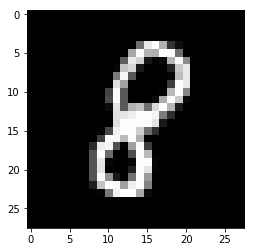

In [11]:
plt.imshow(xtest[45].reshape(28,28), cmap='gray')
print(ytest[45])
print(ytrain.shape)

In [347]:
#run for resetting the index

In [8]:
def PCA(X, new_dim = 2):
    x = X.T
    m = x.shape[1] - 1
    mean = np.mean(x,axis = 1).reshape(-1,1)
    x = x - mean
    cov = np.cov(x.T)
    lam, V = eigh(cov,eigvals=(m - new_dim + 1, m))
    eigen_face = V.T @ x.T
    eigen_face.shape
    signature = (eigen_face @ x)
    return signature.T

In [9]:
xtrain = PCA(xtrain, 256)

In [12]:
xtrain.shape

(6731, 256)

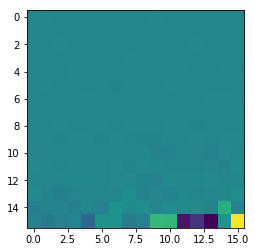

In [13]:
plt.imshow(xtrain[0].reshape(16,16))

In [14]:
#Y = (y > 4) * 1 + (y < 4) * -1
mean = xtrain.mean(axis=0)
std = xtrain.std(axis = 0)
xtrain = (xtrain - mean) / std
xtrain[:10]

array([[ 1.09073815,  2.85054492,  1.06149288, ..., -2.09163041,
         0.19470438,  1.15791249],
       [ 0.49735335, -0.92761893,  0.65216591, ..., -1.41246092,
        -1.59807313, -1.03852827],
       [-3.11856872, -0.88442791, -0.45464869, ..., -0.47563641,
        -2.14161934, -0.61580907],
       ...,
       [ 0.33299655, -0.58234576,  0.75816855, ..., -0.7010439 ,
        -0.24169028,  1.08822947],
       [ 1.59288834,  1.35907892, -0.0407316 , ..., -0.29275501,
        -1.76680611, -1.48020011],
       [ 1.40814302, -0.39055219,  0.43167386, ...,  0.27812549,
        -0.49923781,  1.35905695]])

In [31]:
Y = (ytrain.reshape(-1,1) > 4) * 1 + (ytrain.reshape(-1,1) < 4) * -1

In [16]:
xtest = xtrain[2000:2500,:]
ytest = Y[2000:2500,:]

In [17]:
xtrain = xtrain[:2000,:]

In [18]:
Y = Y[:2000,:]

In [19]:
tol = 1e-3
max_passes = 50

In [20]:
def func(xtrain, x_i, alphas, ytrain, b):
    return ((alphas * ytrain * (xtrain @ x_i.T)).sum(axis = 0)+b).reshape(-1,1)

In [21]:
def find_L(alpha, y, C, i, j):
    if (y[i, 0] == y[j, 0]):
        return max(0, alpha[j, 0] + alpha[i, 0] - C)
    else:
        return max(0, alpha[j, 0] - alpha[i, 0])

In [22]:
def find_H(alpha, y, C, i, j):
    if (y[i] == y[j]):
        return min(C, alpha[j, 0] + alpha[i, 0])
    else:
        return min(C, C + alpha[j, 0] - alpha[i, 0])

In [23]:
def select_rand(a, i):
    num = np.random.randint(0,a)
    if(num == a):
        return num+1
    else:
        return num

In [24]:
def linear(a,b):
    return (a @ b.T)

In [25]:
def sel_alpha(alpha_j, L, H):
    if (alpha_j > H):
        return H
    if (alpha_j < L):
        return L
    return alpha_j

In [26]:
def SMO(xtrain, ytrain, max_passes, tol,C):
    alpha = np.zeros(xtrain.shape[0]).reshape(-1,1)
    b = 0
    passes = 0
    while( passes < max_passes):
        num_changed_alphas = 0;
        print(num_changed_alphas)
        for i in range(xtrain.shape[0]):
            print("iterating through data")
            error_i = func(xtrain, xtrain[[i]],alpha,ytrain,b) - ytrain[i,0]
            #print(error_i.shape)
            if((ytrain[i,0] * error_i < -tol and alpha[i,0] < C) or (ytrain[i,0] * error_i > tol and alpha[i,0] > 0)):
                #print("Inside First if condition")
                j = select_rand(xtrain.shape[0], i)
                print("j = {} and i = {}".format(j, i))
                error_j = func(xtrain, xtrain[[j]], alpha,ytrain,b) - ytrain[j,0]
                alpha_i,alpha_j = alpha[i],alpha[j]
                L = find_L(alpha, ytrain, C, i, j)
                H = find_H(alpha, ytrain, C, i, j)
                if(L == H):
                    continue
                eta = 2 * (xtrain[i] @ xtrain[j]) - (xtrain[i] @ xtrain[i]) - (xtrain[j] @ xtrain[j])
                print("eta = {}".format(eta))
                if(eta >= 0):
                    continue
                alpha_j = alpha[j,0] - (ytrain[j, 0]) * (error_i - error_j) / eta
                alpha_j = sel_alpha(alpha_j, L, H)
                if(np.abs(alpha[j,0] - alpha_j) < 1e-5):
                    continue
                alpha_i = alpha[i,0] + ytrain[i,0] * ytrain[j,0] * (alpha[j,0] - alpha_j)
                b1 = b - error_i - ytrain[i,0] * (alpha_i - alpha[i, 0]) * (xtrain[i] @ xtrain[i]) 
                -ytrain[j,0] * (alpha_j - alpha[j,0]) * (xtrain[i] @ xtrain[j])
                b2 = b - error_j - ytrain[i,0] * (alpha_i - alpha[i, 0]) * (xtrain[i] @ xtrain[j])
                -ytrain[j,0] * (alpha_j - alpha[j,0]) * (xtrain[j] @ xtrain[j])
                
                if(alpha[i] > 0 and alpha[i] < C):
                    b = b1
                if(alpha[j] > 0 and alpha[j] < C):
                    b = b2
                else:
                    b = (b1 + b2) / 2
                alpha[j, 0] = alpha_j
                alpha[i, 0] = alpha_i
                
                num_changed_alphas = num_changed_alphas + 1
                print("Num_changed_alpha = {}".format(num_changed_alphas))
        if(num_changed_alphas == 0):
            passes = passes + 1
        else:
            passes = passes + 1
    return alpha, b
                

In [27]:
alpha, b = SMO(xtrain, Y, 20, tol, C = 1)

0
iterating through data
j = 748 and i = 0
iterating through data
j = 891 and i = 1
iterating through data
j = 894 and i = 2
eta = -615.1966996031621
Num_changed_alpha = 1
iterating through data
j = 127 and i = 3
eta = -360.89250166941775
Num_changed_alpha = 2
iterating through data
j = 306 and i = 4
iterating through data
j = 1900 and i = 5
eta = -725.0095682756405
Num_changed_alpha = 3
iterating through data
j = 768 and i = 6
eta = -827.2947435565106
Num_changed_alpha = 4
iterating through data
j = 1737 and i = 7
iterating through data
j = 1509 and i = 8
eta = -449.2211149269716
Num_changed_alpha = 5
iterating through data
j = 1902 and i = 9
eta = -551.2813152795457
Num_changed_alpha = 6
iterating through data
j = 315 and i = 10
iterating through data
j = 1550 and i = 11
eta = -388.16494083402483
Num_changed_alpha = 7
iterating through data
j = 604 and i = 12
iterating through data
j = 218 and i = 13
eta = -562.4392545153928
Num_changed_alpha = 8
iterating through data
j = 984 and i 

j = 1781 and i = 139
iterating through data
iterating through data
j = 468 and i = 141
iterating through data
iterating through data
j = 686 and i = 143
iterating through data
iterating through data
j = 978 and i = 145
iterating through data
j = 506 and i = 146
eta = -545.6333558762333
Num_changed_alpha = 66
iterating through data
j = 547 and i = 147
iterating through data
j = 579 and i = 148
eta = -611.8302013817193
Num_changed_alpha = 67
iterating through data
j = 1822 and i = 149
iterating through data
j = 779 and i = 150
eta = -473.85105879839864
Num_changed_alpha = 68
iterating through data
j = 15 and i = 151
eta = -471.144280443817
Num_changed_alpha = 69
iterating through data
j = 56 and i = 152
eta = -436.5758178094296
Num_changed_alpha = 70
iterating through data
j = 663 and i = 153
iterating through data
j = 412 and i = 154
eta = -396.7607058212622
Num_changed_alpha = 71
iterating through data
j = 1325 and i = 155
eta = -615.866361647267
Num_changed_alpha = 72
iterating throug

j = 691 and i = 279
iterating through data
iterating through data
j = 550 and i = 281
iterating through data
iterating through data
j = 1313 and i = 283
iterating through data
iterating through data
iterating through data
j = 79 and i = 286
eta = -501.5880801995217
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1742 and i = 291
iterating through data
iterating through data
j = 1680 and i = 293
eta = -825.617644318071
Num_changed_alpha = 125
iterating through data
j = 288 and i = 294
iterating through data
iterating through data
j = 506 and i = 296
eta = -468.65465666916145
Num_changed_alpha = 126
iterating through data
j = 838 and i = 297
iterating through data
j = 685 and i = 298
iterating through data
j = 1633 and i = 299
eta = -467.5541933738774
iterating through data
j = 1081 and i = 300
iterating through data
j = 1293 and i = 301
iterating through data
iterating through data
iterating through data
iterating th

j = 31 and i = 445
eta = -770.6497809013483
Num_changed_alpha = 174
iterating through data
iterating through data
j = 1211 and i = 447
eta = -512.0400127861888
Num_changed_alpha = 175
iterating through data
j = 860 and i = 448
eta = -400.022178547958
Num_changed_alpha = 176
iterating through data
iterating through data
j = 1040 and i = 450
iterating through data
j = 1222 and i = 451
eta = -425.51689410515644
Num_changed_alpha = 177
iterating through data
j = 919 and i = 452
eta = -567.4256962595041
Num_changed_alpha = 178
iterating through data
j = 58 and i = 453
eta = -470.6007766701355
iterating through data
j = 947 and i = 454
iterating through data
iterating through data
j = 58 and i = 456
eta = -602.1978265840312
iterating through data
j = 402 and i = 457
iterating through data
j = 248 and i = 458
iterating through data
iterating through data
j = 427 and i = 460
eta = -477.2138599945475
Num_changed_alpha = 179
iterating through data
j = 1282 and i = 461
iterating through data
j = 

iterating through data
iterating through data
iterating through data
j = 773 and i = 612
eta = -471.43004753166286
iterating through data
j = 1541 and i = 613
eta = -646.7651698409165
Num_changed_alpha = 214
iterating through data
j = 567 and i = 614
iterating through data
j = 1594 and i = 615
iterating through data
j = 1111 and i = 616
iterating through data
iterating through data
j = 931 and i = 618
iterating through data
iterating through data
iterating through data
iterating through data
j = 595 and i = 622
eta = -502.9036825757385
iterating through data
iterating through data
j = 1085 and i = 624
eta = -433.4020337599757
iterating through data
iterating through data
j = 1909 and i = 626
iterating through data
iterating through data
j = 1300 and i = 628
eta = -426.9362104992688
Num_changed_alpha = 215
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 163 and i = 633
iterating through data
j = 1643 and i = 634
iter

eta = -609.1076478115929
Num_changed_alpha = 260
iterating through data
iterating through data
j = 1696 and i = 772
eta = -588.2485794227857
Num_changed_alpha = 261
iterating through data
iterating through data
iterating through data
j = 1398 and i = 775
iterating through data
j = 1684 and i = 776
eta = -382.54045877076794
iterating through data
iterating through data
j = 1508 and i = 778
eta = -389.8717681184754
Num_changed_alpha = 262
iterating through data
j = 1414 and i = 779
eta = -329.7069353646252
Num_changed_alpha = 263
iterating through data
j = 8 and i = 780
eta = -389.47549879414566
Num_changed_alpha = 264
iterating through data
j = 625 and i = 781
eta = -440.93292522498064
Num_changed_alpha = 265
iterating through data
j = 1091 and i = 782
eta = -376.0634490935565
Num_changed_alpha = 266
iterating through data
j = 229 and i = 783
iterating through data
j = 723 and i = 784
eta = -507.08302837975936
iterating through data
j = 1313 and i = 785
eta = -442.50595858344104
iterati

iterating through data
iterating through data
j = 115 and i = 937
eta = -480.7000932625313
Num_changed_alpha = 308
iterating through data
iterating through data
iterating through data
j = 1268 and i = 940
eta = -399.21479587210604
iterating through data
j = 1790 and i = 941
eta = -599.1059411460283
Num_changed_alpha = 309
iterating through data
j = 165 and i = 942
iterating through data
j = 942 and i = 943
eta = -453.5568620339652
Num_changed_alpha = 310
iterating through data
j = 1649 and i = 944
iterating through data
j = 388 and i = 945
eta = -344.43751137220465
Num_changed_alpha = 311
iterating through data
iterating through data
j = 97 and i = 947
iterating through data
iterating through data
iterating through data
j = 433 and i = 950
iterating through data
j = 1727 and i = 951
eta = -426.37448842610837
iterating through data
iterating through data
j = 1415 and i = 953
iterating through data
j = 1314 and i = 954
iterating through data
j = 622 and i = 955
eta = -545.0055087151526
N

eta = -647.1156037550508
Num_changed_alpha = 359
iterating through data
iterating through data
j = 681 and i = 1095
eta = -641.2290497044444
Num_changed_alpha = 360
iterating through data
j = 1613 and i = 1096
eta = -383.04372977886976
iterating through data
iterating through data
iterating through data
iterating through data
j = 1586 and i = 1100
eta = -377.6358729154755
Num_changed_alpha = 361
iterating through data
iterating through data
j = 1904 and i = 1102
eta = -477.03333103137044
Num_changed_alpha = 362
iterating through data
iterating through data
iterating through data
iterating through data
j = 61 and i = 1106
eta = -415.0281791115932
Num_changed_alpha = 363
iterating through data
j = 400 and i = 1107
eta = -548.7564503349075
Num_changed_alpha = 364
iterating through data
iterating through data
j = 1539 and i = 1109
eta = -651.3489849882665
Num_changed_alpha = 365
iterating through data
iterating through data
iterating through data
j = 375 and i = 1112
eta = -651.53846525481

eta = -532.6782126587935
Num_changed_alpha = 407
iterating through data
iterating through data
j = 1016 and i = 1269
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 984 and i = 1274
eta = -470.6875043488659
Num_changed_alpha = 408
iterating through data
j = 1454 and i = 1275
eta = -604.0866567535261
iterating through data
iterating through data
j = 1438 and i = 1277
eta = -491.30821536549075
Num_changed_alpha = 409
iterating through data
j = 735 and i = 1278
eta = -498.23081509876937
Num_changed_alpha = 410
iterating through data
j = 671 and i = 1279
eta = -475.30832783785837
Num_changed_alpha = 411
iterating through data
j = 535 and i = 1280
eta = -859.3244196209453
Num_changed_alpha = 412
iterating through data
iterating through data
iterating through data
j = 61 and i = 1283
eta = -823.7242420735103
Num_changed_alpha = 413
iterating through data
iterating through data
iterating through data
j = 1566 and i = 1286


j = 551 and i = 1429
eta = -435.55457249415633
Num_changed_alpha = 446
iterating through data
j = 1554 and i = 1430
iterating through data
j = 1078 and i = 1431
eta = -604.0856942199108
iterating through data
j = 1661 and i = 1432
eta = -286.2465261341962
Num_changed_alpha = 447
iterating through data
iterating through data
j = 286 and i = 1434
iterating through data
iterating through data
j = 239 and i = 1436
eta = -417.61106991627975
Num_changed_alpha = 448
iterating through data
j = 270 and i = 1437
eta = -479.4483010638765
iterating through data
j = 751 and i = 1438
eta = -364.9390661072692
iterating through data
iterating through data
j = 636 and i = 1440
iterating through data
j = 980 and i = 1441
iterating through data
j = 1055 and i = 1442
eta = -396.17963303349427
Num_changed_alpha = 449
iterating through data
iterating through data
j = 1639 and i = 1444
iterating through data
j = 522 and i = 1445
iterating through data
iterating through data
j = 1 and i = 1447
eta = -709.4209

iterating through data
iterating through data
iterating through data
iterating through data
j = 200 and i = 1600
eta = -407.186278086471
Num_changed_alpha = 491
iterating through data
j = 274 and i = 1601
eta = -434.55835995636005
Num_changed_alpha = 492
iterating through data
iterating through data
j = 1501 and i = 1603
iterating through data
iterating through data
j = 267 and i = 1605
eta = -550.3302457508528
iterating through data
iterating through data
iterating through data
j = 545 and i = 1608
eta = -566.6826312859951
Num_changed_alpha = 493
iterating through data
j = 865 and i = 1609
eta = -405.59819603886046
Num_changed_alpha = 494
iterating through data
iterating through data
j = 688 and i = 1611
eta = -650.610639643131
Num_changed_alpha = 495
iterating through data
iterating through data
iterating through data
iterating through data
j = 516 and i = 1615
eta = -257.54314762375947
Num_changed_alpha = 496
iterating through data
j = 1453 and i = 1616
eta = -778.7924117746036
iter

iterating through data
j = 979 and i = 1762
eta = -660.0502722170919
Num_changed_alpha = 538
iterating through data
iterating through data
j = 1224 and i = 1764
iterating through data
j = 645 and i = 1765
eta = -682.3345699848853
Num_changed_alpha = 539
iterating through data
j = 1657 and i = 1766
eta = -527.5915036446045
iterating through data
j = 632 and i = 1767
iterating through data
iterating through data
j = 99 and i = 1769
eta = -642.8429150584841
iterating through data
j = 809 and i = 1770
iterating through data
j = 871 and i = 1771
iterating through data
iterating through data
j = 598 and i = 1773
eta = -1562.1274913791735
iterating through data
iterating through data
j = 1209 and i = 1775
eta = -584.2231626915008
iterating through data
iterating through data
j = 798 and i = 1777
iterating through data
j = 1519 and i = 1778
eta = -398.2336216880092
iterating through data
j = 18 and i = 1779
iterating through data
iterating through data
j = 774 and i = 1781
eta = -635.728267543

eta = -584.2189243370658
Num_changed_alpha = 582
iterating through data
iterating through data
j = 1570 and i = 1931
eta = -590.4042607897592
iterating through data
iterating through data
j = 763 and i = 1933
eta = -435.9232779271693
iterating through data
j = 12 and i = 1934
eta = -564.9855399656103
iterating through data
iterating through data
iterating through data
j = 1089 and i = 1937
eta = -597.6537281285187
Num_changed_alpha = 583
iterating through data
j = 1442 and i = 1938
eta = -454.86350879984974
Num_changed_alpha = 584
iterating through data
j = 1384 and i = 1939
iterating through data
iterating through data
j = 1601 and i = 1941
eta = -563.2084037489931
iterating through data
j = 1927 and i = 1942
iterating through data
iterating through data
iterating through data
j = 1868 and i = 1945
eta = -722.6651613409647
Num_changed_alpha = 585
iterating through data
j = 1890 and i = 1946
eta = -291.41193923122967
Num_changed_alpha = 586
iterating through data
iterating through data

eta = -468.9783268228399
iterating through data
j = 425 and i = 81
eta = -357.45404898045797
Num_changed_alpha = 48
iterating through data
j = 1876 and i = 82
iterating through data
j = 97 and i = 83
eta = -451.84883543696856
iterating through data
iterating through data
j = 579 and i = 85
eta = -537.8455987549224
iterating through data
j = 1461 and i = 86
eta = -399.00210404399314
iterating through data
j = 229 and i = 87
eta = -562.8037200447549
Num_changed_alpha = 49
iterating through data
j = 1627 and i = 88
eta = -579.8636345531982
Num_changed_alpha = 50
iterating through data
j = 1955 and i = 89
eta = -423.1922484030264
Num_changed_alpha = 51
iterating through data
j = 1487 and i = 90
eta = -798.6495163011994
iterating through data
j = 1866 and i = 91
eta = -328.9275091284412
iterating through data
iterating through data
j = 1584 and i = 93
eta = -385.1607985121221
iterating through data
j = 1863 and i = 94
eta = -410.1287413025532
iterating through data
iterating through data
it

iterating through data
j = 1529 and i = 219
iterating through data
j = 1615 and i = 220
eta = -350.5555729650217
Num_changed_alpha = 90
iterating through data
iterating through data
iterating through data
j = 664 and i = 223
eta = -414.04929392101997
iterating through data
iterating through data
j = 1380 and i = 225
eta = -536.9998734227852
Num_changed_alpha = 91
iterating through data
iterating through data
j = 1560 and i = 227
eta = -451.9779431822344
Num_changed_alpha = 92
iterating through data
j = 365 and i = 228
eta = -479.3778155653349
iterating through data
j = 1138 and i = 229
eta = -458.9282232783868
Num_changed_alpha = 93
iterating through data
iterating through data
j = 1341 and i = 231
eta = -370.50870515017033
iterating through data
j = 183 and i = 232
eta = -642.0969853747205
Num_changed_alpha = 94
iterating through data
iterating through data
j = 1438 and i = 234
eta = -416.6639510837632
Num_changed_alpha = 95
iterating through data
j = 601 and i = 235
eta = -586.049096

iterating through data
j = 1212 and i = 372
eta = -988.2550469590913
iterating through data
iterating through data
j = 114 and i = 374
eta = -593.747323060238
iterating through data
iterating through data
j = 1948 and i = 376
eta = -398.11232836966377
Num_changed_alpha = 140
iterating through data
j = 296 and i = 377
eta = -411.7006849345111
Num_changed_alpha = 141
iterating through data
iterating through data
j = 230 and i = 379
eta = -532.0284538994487
Num_changed_alpha = 142
iterating through data
j = 1099 and i = 380
eta = -508.6632709947591
iterating through data
iterating through data
j = 972 and i = 382
eta = -535.3407847699835
iterating through data
j = 738 and i = 383
eta = -420.6025597545221
iterating through data
j = 423 and i = 384
eta = -473.44544480704866
Num_changed_alpha = 143
iterating through data
j = 1600 and i = 385
eta = -349.71231441372714
Num_changed_alpha = 144
iterating through data
j = 1465 and i = 386
eta = -716.9646663353902
iterating through data
iterating 

eta = -590.5850553368164
Num_changed_alpha = 189
iterating through data
j = 1249 and i = 524
eta = -547.2544303223208
iterating through data
j = 1684 and i = 525
eta = -339.7975211009
iterating through data
iterating through data
j = 383 and i = 527
iterating through data
j = 1607 and i = 528
iterating through data
j = 779 and i = 529
eta = -509.6970435806544
Num_changed_alpha = 190
iterating through data
iterating through data
j = 1184 and i = 531
eta = -664.1223021846808
Num_changed_alpha = 191
iterating through data
j = 286 and i = 532
iterating through data
j = 1733 and i = 533
eta = -478.07626168465947
iterating through data
j = 12 and i = 534
eta = -483.6342177339984
iterating through data
j = 1663 and i = 535
eta = -803.0296251662472
Num_changed_alpha = 192
iterating through data
j = 1189 and i = 536
eta = -717.1625443842643
Num_changed_alpha = 193
iterating through data
j = 1689 and i = 537
eta = -361.6245451167491
iterating through data
j = 136 and i = 538
eta = -462.335765148

j = 407 and i = 669
eta = -777.3013239098166
Num_changed_alpha = 234
iterating through data
iterating through data
iterating through data
j = 277 and i = 672
eta = -279.35851161448716
Num_changed_alpha = 235
iterating through data
iterating through data
iterating through data
j = 893 and i = 675
eta = -533.2343436710163
iterating through data
j = 1322 and i = 676
eta = -534.3835448116345
Num_changed_alpha = 236
iterating through data
j = 1033 and i = 677
eta = -537.2925658301267
Num_changed_alpha = 237
iterating through data
iterating through data
j = 1272 and i = 679
eta = -493.888937319716
Num_changed_alpha = 238
iterating through data
j = 1182 and i = 680
eta = -640.4026961697148
Num_changed_alpha = 239
iterating through data
j = 1651 and i = 681
eta = -578.0811852459298
Num_changed_alpha = 240
iterating through data
j = 1509 and i = 682
eta = -345.77829136923833
Num_changed_alpha = 241
iterating through data
iterating through data
j = 548 and i = 684
eta = -438.3317153186948
iterat

j = 281 and i = 811
eta = -433.0419341866755
iterating through data
j = 1313 and i = 812
eta = -417.264582001362
Num_changed_alpha = 287
iterating through data
iterating through data
iterating through data
iterating through data
j = 1270 and i = 816
eta = -506.36362874661944
Num_changed_alpha = 288
iterating through data
iterating through data
j = 282 and i = 818
iterating through data
j = 1638 and i = 819
eta = -557.1236135423942
Num_changed_alpha = 289
iterating through data
iterating through data
j = 901 and i = 821
eta = -921.2721150569448
Num_changed_alpha = 290
iterating through data
j = 95 and i = 822
eta = -660.825511596769
Num_changed_alpha = 291
iterating through data
j = 1384 and i = 823
iterating through data
j = 1600 and i = 824
eta = -419.5940563656424
iterating through data
j = 1689 and i = 825
eta = -408.36071584753506
iterating through data
j = 497 and i = 826
eta = -571.0532393767842
iterating through data
iterating through data
j = 685 and i = 828
eta = -478.16805998

Num_changed_alpha = 340
iterating through data
iterating through data
iterating through data
j = 125 and i = 964
eta = -417.4380474943734
Num_changed_alpha = 341
iterating through data
iterating through data
j = 185 and i = 966
eta = -364.6134515234685
iterating through data
j = 1128 and i = 967
eta = -483.8995873972672
iterating through data
j = 973 and i = 968
eta = -379.10266177246376
iterating through data
iterating through data
j = 843 and i = 970
eta = -995.8683813380369
Num_changed_alpha = 342
iterating through data
j = 1306 and i = 971
eta = -561.6188642072171
Num_changed_alpha = 343
iterating through data
iterating through data
iterating through data
iterating through data
j = 328 and i = 975
eta = -482.9085823354712
iterating through data
iterating through data
j = 161 and i = 977
eta = -624.1567420201102
iterating through data
j = 952 and i = 978
eta = -556.7588854809517
Num_changed_alpha = 344
iterating through data
j = 984 and i = 979
eta = -513.7028187562692
iterating thr

j = 516 and i = 1107
eta = -264.13282232909353
Num_changed_alpha = 389
iterating through data
j = 1840 and i = 1108
eta = -628.0903574615307
Num_changed_alpha = 390
iterating through data
j = 586 and i = 1109
eta = -544.1914839496025
Num_changed_alpha = 391
iterating through data
iterating through data
j = 204 and i = 1111
eta = -413.1099694066842
Num_changed_alpha = 392
iterating through data
j = 1402 and i = 1112
eta = -667.1059078569415
Num_changed_alpha = 393
iterating through data
j = 363 and i = 1113
eta = -590.4480290134152
Num_changed_alpha = 394
iterating through data
iterating through data
iterating through data
iterating through data
j = 487 and i = 1117
eta = -432.25293436837217
Num_changed_alpha = 395
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1623 and i = 1123
eta = -459.74805778386445
Num_changed_alpha = 396
iterating through data
iterating through data
iterating through da

eta = -496.0547852792039
iterating through data
j = 386 and i = 1268
iterating through data
j = 1177 and i = 1269
eta = -476.0843761076555
iterating through data
j = 1289 and i = 1270
eta = -322.94056521573657
Num_changed_alpha = 442
iterating through data
iterating through data
j = 1479 and i = 1272
eta = -410.35125885169725
iterating through data
iterating through data
j = 729 and i = 1274
eta = -597.1914952030143
iterating through data
iterating through data
iterating through data
j = 1360 and i = 1277
eta = -424.6466659492328
Num_changed_alpha = 443
iterating through data
j = 293 and i = 1278
eta = -474.3457629271662
Num_changed_alpha = 444
iterating through data
j = 353 and i = 1279
eta = -496.79426413546355
Num_changed_alpha = 445
iterating through data
j = 918 and i = 1280
eta = -344.5755263108361
Num_changed_alpha = 446
iterating through data
iterating through data
j = 231 and i = 1282
eta = -422.5420991306811
Num_changed_alpha = 447
iterating through data
j = 1459 and i = 1283

iterating through data
j = 13 and i = 1405
eta = -441.53177867046753
Num_changed_alpha = 496
iterating through data
j = 1739 and i = 1406
eta = -366.59362827177546
iterating through data
iterating through data
j = 596 and i = 1408
eta = -504.8687840895751
iterating through data
j = 1347 and i = 1409
eta = -366.11583474828797
iterating through data
j = 1073 and i = 1410
eta = -393.1664140312614
iterating through data
iterating through data
iterating through data
j = 883 and i = 1413
eta = -665.0746112687523
Num_changed_alpha = 497
iterating through data
iterating through data
iterating through data
iterating through data
j = 1878 and i = 1417
iterating through data
iterating through data
iterating through data
j = 58 and i = 1420
eta = -478.4777700550981
Num_changed_alpha = 498
iterating through data
j = 620 and i = 1421
eta = -609.3966217355699
Num_changed_alpha = 499
iterating through data
iterating through data
j = 601 and i = 1423
eta = -709.2384965250792
Num_changed_alpha = 500
ite

eta = -341.3129421496553
iterating through data
j = 1228 and i = 1547
eta = -466.1868074354793
Num_changed_alpha = 549
iterating through data
j = 1868 and i = 1548
iterating through data
iterating through data
j = 661 and i = 1550
eta = -365.5161269601682
Num_changed_alpha = 550
iterating through data
j = 1131 and i = 1551
eta = -488.7201814038048
iterating through data
j = 139 and i = 1552
eta = -425.35227188995987
iterating through data
iterating through data
iterating through data
j = 1583 and i = 1555
eta = -589.759288038196
Num_changed_alpha = 551
iterating through data
j = 340 and i = 1556
eta = -448.7333868676038
Num_changed_alpha = 552
iterating through data
j = 275 and i = 1557
eta = -539.2614802756901
iterating through data
j = 1571 and i = 1558
eta = -647.427965369325
Num_changed_alpha = 553
iterating through data
iterating through data
j = 1984 and i = 1560
eta = -577.5120321794201
Num_changed_alpha = 554
iterating through data
iterating through data
iterating through data


j = 587 and i = 1699
eta = -524.0560203098541
iterating through data
j = 416 and i = 1700
eta = -527.5321356768172
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1419 and i = 1705
eta = -492.27599338290173
iterating through data
j = 576 and i = 1706
eta = -428.22209414298624
iterating through data
j = 54 and i = 1707
eta = -440.8740827398748
Num_changed_alpha = 599
iterating through data
iterating through data
iterating through data
iterating through data
j = 601 and i = 1711
eta = -598.9278411580235
iterating through data
j = 1786 and i = 1712
eta = -430.3922818150555
iterating through data
iterating through data
j = 1321 and i = 1714
eta = -714.7558485510675
Num_changed_alpha = 600
iterating through data
j = 1860 and i = 1715
eta = -1278.412623499225
iterating through data
j = 1855 and i = 1716
eta = -647.4478472110993
iterating through data
j = 1776 and i = 1717
eta = -515.9165480663952
iterating through data
it

eta = -685.9054563779032
iterating through data
j = 190 and i = 1859
eta = -588.6082584674157
Num_changed_alpha = 637
iterating through data
j = 691 and i = 1860
eta = -604.3912226229464
Num_changed_alpha = 638
iterating through data
j = 458 and i = 1861
eta = -479.5035884943558
iterating through data
j = 920 and i = 1862
eta = -674.898322301729
Num_changed_alpha = 639
iterating through data
iterating through data
j = 106 and i = 1864
eta = -621.5003345957176
Num_changed_alpha = 640
iterating through data
iterating through data
iterating through data
iterating through data
j = 116 and i = 1868
eta = -523.6046380067285
iterating through data
j = 1046 and i = 1869
eta = -343.18404220683726
Num_changed_alpha = 641
iterating through data
j = 1933 and i = 1870
eta = -368.2810627014579
Num_changed_alpha = 642
iterating through data
iterating through data
iterating through data
j = 1590 and i = 1873
eta = -452.43412516628393
iterating through data
iterating through data
j = 574 and i = 1875
e

Num_changed_alpha = 693
iterating through data
j = 169 and i = 1999
eta = -351.87588896830835
Num_changed_alpha = 694
0
iterating through data
iterating through data
j = 1161 and i = 1
eta = -458.6158154049031
iterating through data
j = 1647 and i = 2
eta = -450.9812848436542
Num_changed_alpha = 1
iterating through data
j = 96 and i = 3
eta = -218.63266409591833
Num_changed_alpha = 2
iterating through data
iterating through data
j = 1752 and i = 5
eta = -673.5689610686343
iterating through data
j = 1660 and i = 6
eta = -1218.7243712053325
Num_changed_alpha = 3
iterating through data
j = 141 and i = 7
eta = -310.9241853814274
iterating through data
j = 1317 and i = 8
eta = -360.5557213955382
iterating through data
j = 1124 and i = 9
eta = -518.5457456168098
iterating through data
iterating through data
j = 1971 and i = 11
eta = -447.0625561707607
iterating through data
iterating through data
j = 822 and i = 13
eta = -711.0499904675722
Num_changed_alpha = 4
iterating through data
j = 111

j = 1977 and i = 132
eta = -583.3788251584197
iterating through data
j = 564 and i = 133
iterating through data
j = 70 and i = 134
eta = -577.2821613400533
Num_changed_alpha = 59
iterating through data
j = 632 and i = 135
eta = -628.0240852167184
iterating through data
j = 1459 and i = 136
eta = -513.3173515265227
Num_changed_alpha = 60
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 560 and i = 144
eta = -450.4723528148074
Num_changed_alpha = 61
iterating through data
j = 1886 and i = 145
eta = -472.6301029934805
Num_changed_alpha = 62
iterating through data
j = 1120 and i = 146
eta = -486.88164160663644
iterating through data
j = 693 and i = 147
eta = -472.7684944699429
Num_changed_alpha = 63
iterating through data
j = 1418 and i = 148
eta = -665.5357757343468
Num_changed_alpha = 64
iterating through data
j = 1066 and i = 149
eta = -705.666736633

Num_changed_alpha = 110
iterating through data
j = 340 and i = 262
eta = -304.82866581419546
Num_changed_alpha = 111
iterating through data
j = 1832 and i = 263
eta = -479.6086914165572
iterating through data
j = 1349 and i = 264
eta = -494.19276527451734
Num_changed_alpha = 112
iterating through data
iterating through data
j = 852 and i = 266
eta = -455.8683690877905
Num_changed_alpha = 113
iterating through data
j = 1639 and i = 267
eta = -316.4517744955166
Num_changed_alpha = 114
iterating through data
iterating through data
j = 259 and i = 269
eta = -365.84380055374345
iterating through data
iterating through data
j = 1516 and i = 271
eta = -428.2967543199117
Num_changed_alpha = 115
iterating through data
j = 1423 and i = 272
eta = -857.4673680445834
Num_changed_alpha = 116
iterating through data
j = 423 and i = 273
eta = -353.99996426540685
Num_changed_alpha = 117
iterating through data
j = 1288 and i = 274
eta = -557.8264025230715
Num_changed_alpha = 118
iterating through data
it

iterating through data
iterating through data
j = 1760 and i = 411
eta = -383.27721083366214
iterating through data
j = 1534 and i = 412
eta = -293.2069699019027
Num_changed_alpha = 163
iterating through data
iterating through data
iterating through data
j = 1903 and i = 415
eta = -398.8579869286666
Num_changed_alpha = 164
iterating through data
j = 1425 and i = 416
eta = -447.9378618656417
Num_changed_alpha = 165
iterating through data
j = 1860 and i = 417
eta = -766.1574536847506
Num_changed_alpha = 166
iterating through data
iterating through data
j = 1028 and i = 419
eta = -442.38490171506635
Num_changed_alpha = 167
iterating through data
iterating through data
j = 441 and i = 421
eta = -408.60417191447596
iterating through data
j = 1265 and i = 422
eta = -669.1214625579283
iterating through data
j = 637 and i = 423
eta = -354.40389993982603
iterating through data
iterating through data
j = 238 and i = 425
eta = -337.86537273709257
Num_changed_alpha = 168
iterating through data
j =

Num_changed_alpha = 210
iterating through data
iterating through data
j = 292 and i = 551
eta = -436.34442688298367
iterating through data
j = 1445 and i = 552
eta = -594.8875983578916
Num_changed_alpha = 211
iterating through data
iterating through data
j = 1185 and i = 554
eta = -398.8008232226106
iterating through data
iterating through data
iterating through data
iterating through data
j = 28 and i = 558
eta = -606.40084160131
iterating through data
j = 149 and i = 559
eta = -789.570914247048
Num_changed_alpha = 212
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1190 and i = 564
eta = -495.2118789043957
iterating through data
j = 402 and i = 565
eta = -675.3406504447248
iterating through data
j = 470 and i = 566
eta = -310.7832365533561
iterating through data
j = 1974 and i = 567
eta = -441.1220651928161
iterating through data
j = 688 and i = 568
eta = -571.7530916262267
Num_changed_alpha = 213
iterating throug

j = 166 and i = 690
eta = -519.0821339756915
iterating through data
j = 1656 and i = 691
eta = -388.25875780014206
iterating through data
j = 1421 and i = 692
eta = -497.46238530945834
Num_changed_alpha = 260
iterating through data
j = 160 and i = 693
eta = -553.5062673834475
Num_changed_alpha = 261
iterating through data
j = 603 and i = 694
eta = -346.30826992132063
iterating through data
iterating through data
iterating through data
j = 1994 and i = 697
eta = -442.05274803828894
iterating through data
j = 791 and i = 698
eta = -338.8080491895526
iterating through data
iterating through data
iterating through data
j = 1461 and i = 701
eta = -518.8416613239714
iterating through data
iterating through data
j = 1904 and i = 703
iterating through data
j = 46 and i = 704
eta = -568.4211327212251
Num_changed_alpha = 262
iterating through data
j = 1494 and i = 705
eta = -515.5034697401496
iterating through data
j = 76 and i = 706
eta = -515.0273159276185
iterating through data
j = 603 and i 

eta = -584.9627568450021
Num_changed_alpha = 312
iterating through data
j = 1473 and i = 826
eta = -907.9225659077358
Num_changed_alpha = 313
iterating through data
iterating through data
j = 553 and i = 828
eta = -607.9988520741734
iterating through data
iterating through data
j = 589 and i = 830
eta = -331.4196303938001
iterating through data
j = 1372 and i = 831
iterating through data
j = 850 and i = 832
eta = -439.36544440571083
Num_changed_alpha = 314
iterating through data
iterating through data
iterating through data
j = 1303 and i = 835
eta = -332.9541197439205
Num_changed_alpha = 315
iterating through data
iterating through data
iterating through data
j = 520 and i = 838
eta = -445.62763858365685
Num_changed_alpha = 316
iterating through data
iterating through data
iterating through data
iterating through data
j = 1564 and i = 842
eta = -503.8855903500757
Num_changed_alpha = 317
iterating through data
iterating through data
j = 844 and i = 844
eta = 0.0
iterating through data


j = 1341 and i = 977
eta = -504.1346201866607
iterating through data
iterating through data
j = 824 and i = 979
eta = -512.7679131673774
Num_changed_alpha = 367
iterating through data
iterating through data
j = 705 and i = 981
eta = -544.4211153723226
Num_changed_alpha = 368
iterating through data
j = 708 and i = 982
eta = -538.7597379674012
Num_changed_alpha = 369
iterating through data
iterating through data
j = 1080 and i = 984
eta = -334.5717511141678
Num_changed_alpha = 370
iterating through data
j = 1376 and i = 985
eta = -452.91557030745776
Num_changed_alpha = 371
iterating through data
j = 1896 and i = 986
eta = -561.9864454630946
iterating through data
iterating through data
iterating through data
iterating through data
j = 17 and i = 990
eta = -595.2694628196508
Num_changed_alpha = 372
iterating through data
j = 650 and i = 991
eta = -396.9596532013492
Num_changed_alpha = 373
iterating through data
iterating through data
iterating through data
iterating through data
iterating

j = 3 and i = 1126
eta = -668.8884926967594
Num_changed_alpha = 425
iterating through data
iterating through data
iterating through data
j = 261 and i = 1129
eta = -639.9095286250382
Num_changed_alpha = 426
iterating through data
j = 919 and i = 1130
eta = -727.5835152383692
Num_changed_alpha = 427
iterating through data
iterating through data
j = 357 and i = 1132
iterating through data
iterating through data
j = 1358 and i = 1134
eta = -366.97120427294016
Num_changed_alpha = 428
iterating through data
j = 1619 and i = 1135
eta = -348.3291382389873
Num_changed_alpha = 429
iterating through data
j = 1457 and i = 1136
eta = -374.5927768440154
Num_changed_alpha = 430
iterating through data
iterating through data
iterating through data
j = 181 and i = 1139
eta = -420.0799718929393
Num_changed_alpha = 431
iterating through data
j = 299 and i = 1140
eta = -436.048445565462
Num_changed_alpha = 432
iterating through data
j = 766 and i = 1141
eta = -568.9954147931367
iterating through data
j = 

j = 100 and i = 1278
eta = -632.6557309715577
Num_changed_alpha = 473
iterating through data
j = 860 and i = 1279
eta = -408.66330293772796
Num_changed_alpha = 474
iterating through data
j = 655 and i = 1280
eta = -511.1186469394445
iterating through data
j = 629 and i = 1281
eta = -620.9290979805376
iterating through data
iterating through data
j = 73 and i = 1283
eta = -716.440417311722
Num_changed_alpha = 475
iterating through data
j = 48 and i = 1284
eta = -1306.2828748432853
Num_changed_alpha = 476
iterating through data
iterating through data
iterating through data
j = 1496 and i = 1287
eta = -395.66186963972444
iterating through data
j = 1101 and i = 1288
eta = -515.2279720771169
Num_changed_alpha = 477
iterating through data
j = 220 and i = 1289
eta = -289.22775029246986
Num_changed_alpha = 478
iterating through data
iterating through data
j = 1194 and i = 1291
eta = -491.3472293160107
iterating through data
j = 1112 and i = 1292
eta = -914.8029167741669
Num_changed_alpha = 479

iterating through data
iterating through data
iterating through data
j = 252 and i = 1419
eta = -471.5555302744434
Num_changed_alpha = 520
iterating through data
j = 776 and i = 1420
eta = -464.7685697366669
iterating through data
j = 599 and i = 1421
eta = -370.3751084261829
iterating through data
j = 1239 and i = 1422
eta = -580.9497653011322
iterating through data
j = 595 and i = 1423
eta = -594.1423068611789
Num_changed_alpha = 521
iterating through data
j = 701 and i = 1424
eta = -581.2517199562834
Num_changed_alpha = 522
iterating through data
j = 1651 and i = 1425
eta = -569.6948690916092
Num_changed_alpha = 523
iterating through data
iterating through data
j = 361 and i = 1427
eta = -323.8694511983495
iterating through data
j = 315 and i = 1428
eta = -385.97015090842723
Num_changed_alpha = 524
iterating through data
j = 116 and i = 1429
eta = -478.3676351960483
Num_changed_alpha = 525
iterating through data
j = 855 and i = 1430
eta = -637.2375788410432
Num_changed_alpha = 526
i

j = 1171 and i = 1558
eta = -599.098647106854
Num_changed_alpha = 574
iterating through data
j = 481 and i = 1559
iterating through data
j = 1864 and i = 1560
eta = -540.2583880754329
Num_changed_alpha = 575
iterating through data
iterating through data
j = 786 and i = 1562
eta = -450.3866776915525
Num_changed_alpha = 576
iterating through data
j = 1025 and i = 1563
eta = -388.74889323952226
iterating through data
j = 1910 and i = 1564
eta = -399.5313738614841
iterating through data
j = 894 and i = 1565
eta = -551.3137240946263
Num_changed_alpha = 577
iterating through data
j = 545 and i = 1566
eta = -648.6357806177017
Num_changed_alpha = 578
iterating through data
j = 1872 and i = 1567
iterating through data
iterating through data
j = 1770 and i = 1569
eta = -427.69423066929426
iterating through data
j = 1540 and i = 1570
eta = -505.70779850539986
Num_changed_alpha = 579
iterating through data
j = 891 and i = 1571
eta = -450.56068552589255
iterating through data
iterating through data

Num_changed_alpha = 619
iterating through data
j = 554 and i = 1703
eta = -400.6340549560688
Num_changed_alpha = 620
iterating through data
j = 1220 and i = 1704
eta = -388.2685817460764
Num_changed_alpha = 621
iterating through data
j = 554 and i = 1705
eta = -417.46121005630243
Num_changed_alpha = 622
iterating through data
j = 1949 and i = 1706
eta = -566.9775054914188
Num_changed_alpha = 623
iterating through data
j = 439 and i = 1707
eta = -553.04676433825
Num_changed_alpha = 624
iterating through data
j = 1195 and i = 1708
eta = -341.1618879093036
Num_changed_alpha = 625
iterating through data
iterating through data
iterating through data
j = 192 and i = 1711
eta = -488.4585520709403
Num_changed_alpha = 626
iterating through data
j = 1626 and i = 1712
eta = -672.8967374036145
iterating through data
j = 1140 and i = 1713
eta = -440.08277922341216
Num_changed_alpha = 627
iterating through data
j = 646 and i = 1714
eta = -614.7419744194524
iterating through data
j = 1649 and i = 171

j = 1461 and i = 1860
eta = -427.7988026319182
iterating through data
j = 1300 and i = 1861
eta = -355.6295455330934
Num_changed_alpha = 660
iterating through data
j = 555 and i = 1862
eta = -370.4725359444763
Num_changed_alpha = 661
iterating through data
iterating through data
j = 636 and i = 1864
eta = -464.07103892994235
iterating through data
j = 658 and i = 1865
eta = -471.23944900800217
Num_changed_alpha = 662
iterating through data
iterating through data
j = 191 and i = 1867
eta = -713.300905516219
Num_changed_alpha = 663
iterating through data
iterating through data
j = 1897 and i = 1869
eta = -538.9019107179928
Num_changed_alpha = 664
iterating through data
j = 979 and i = 1870
eta = -523.5196473469789
iterating through data
iterating through data
iterating through data
j = 3 and i = 1873
eta = -392.7227013950456
Num_changed_alpha = 665
iterating through data
iterating through data
j = 1402 and i = 1875
eta = -419.69380097639805
Num_changed_alpha = 666
iterating through data


j = 974 and i = 4
eta = -432.1183429607907
Num_changed_alpha = 2
iterating through data
j = 385 and i = 5
eta = -464.29011740245716
Num_changed_alpha = 3
iterating through data
iterating through data
j = 1996 and i = 7
eta = -411.7795570852451
Num_changed_alpha = 4
iterating through data
j = 1762 and i = 8
eta = -555.9168343063257
Num_changed_alpha = 5
iterating through data
j = 981 and i = 9
eta = -540.7988830855129
Num_changed_alpha = 6
iterating through data
iterating through data
j = 1155 and i = 11
eta = -386.18541155354734
Num_changed_alpha = 7
iterating through data
iterating through data
j = 1775 and i = 13
eta = -518.9777404672529
Num_changed_alpha = 8
iterating through data
iterating through data
j = 1278 and i = 15
eta = -520.7967581089005
Num_changed_alpha = 9
iterating through data
j = 1250 and i = 16
eta = -323.9887000710795
Num_changed_alpha = 10
iterating through data
j = 1138 and i = 17
eta = -362.8817325849824
iterating through data
iterating through data
j = 168 and 

iterating through data
iterating through data
j = 100 and i = 143
eta = -788.1517634616451
Num_changed_alpha = 64
iterating through data
j = 1043 and i = 144
eta = -1065.932223823263
Num_changed_alpha = 65
iterating through data
j = 808 and i = 145
eta = -543.8027899634981
Num_changed_alpha = 66
iterating through data
j = 1212 and i = 146
eta = -863.3953823993199
iterating through data
iterating through data
j = 1944 and i = 148
eta = -496.1757873045119
iterating through data
j = 900 and i = 149
eta = -787.9365012427148
Num_changed_alpha = 67
iterating through data
j = 956 and i = 150
eta = -541.8542976376461
Num_changed_alpha = 68
iterating through data
j = 1385 and i = 151
eta = -356.15823237826066
iterating through data
iterating through data
iterating through data
iterating through data
j = 642 and i = 155
eta = -876.978617651846
Num_changed_alpha = 69
iterating through data
j = 109 and i = 156
eta = -419.43236331844946
Num_changed_alpha = 70
iterating through data
iterating throug

iterating through data
j = 434 and i = 286
eta = -470.592112693524
iterating through data
j = 633 and i = 287
eta = -330.19597690338003
iterating through data
j = 1846 and i = 288
eta = -404.71431273869484
iterating through data
iterating through data
iterating through data
j = 41 and i = 291
eta = -448.96585922149103
Num_changed_alpha = 118
iterating through data
iterating through data
j = 1998 and i = 293
eta = -465.1179645403855
Num_changed_alpha = 119
iterating through data
iterating through data
j = 1060 and i = 295
eta = -619.958349689259
iterating through data
j = 13 and i = 296
eta = -475.23143365515864
Num_changed_alpha = 120
iterating through data
iterating through data
iterating through data
j = 324 and i = 299
eta = -529.2767406340438
Num_changed_alpha = 121
iterating through data
iterating through data
j = 987 and i = 301
eta = -517.8747187222236
iterating through data
iterating through data
iterating through data
iterating through data
j = 1073 and i = 305
eta = -416.3782

eta = -291.09268692496505
Num_changed_alpha = 161
iterating through data
j = 71 and i = 431
eta = -292.98673062332296
iterating through data
iterating through data
iterating through data
iterating through data
j = 395 and i = 435
eta = -452.1396163925018
Num_changed_alpha = 162
iterating through data
iterating through data
iterating through data
iterating through data
j = 1293 and i = 439
eta = -574.0321363504131
iterating through data
iterating through data
j = 731 and i = 441
eta = -555.027524618461
Num_changed_alpha = 163
iterating through data
j = 1009 and i = 442
eta = -277.803170947462
Num_changed_alpha = 164
iterating through data
j = 679 and i = 443
eta = -423.90535483825204
Num_changed_alpha = 165
iterating through data
iterating through data
iterating through data
j = 819 and i = 446
iterating through data
j = 132 and i = 447
eta = -507.80184064533836
Num_changed_alpha = 166
iterating through data
j = 629 and i = 448
eta = -506.76694223607194
iterating through data
iterating 

j = 1487 and i = 574
eta = -748.5535284606929
iterating through data
iterating through data
j = 1465 and i = 576
eta = -430.512045829711
Num_changed_alpha = 208
iterating through data
iterating through data
j = 139 and i = 578
eta = -449.57070463669766
Num_changed_alpha = 209
iterating through data
iterating through data
j = 940 and i = 580
eta = -462.26246298912747
iterating through data
iterating through data
j = 335 and i = 582
eta = -534.9740743453497
Num_changed_alpha = 210
iterating through data
j = 1865 and i = 583
eta = -593.2131507493376
Num_changed_alpha = 211
iterating through data
iterating through data
iterating through data
j = 1639 and i = 586
eta = -507.4344307396674
Num_changed_alpha = 212
iterating through data
iterating through data
j = 1061 and i = 588
eta = -859.1745768356857
Num_changed_alpha = 213
iterating through data
iterating through data
j = 411 and i = 590
eta = -411.7995116309258
iterating through data
iterating through data
j = 1122 and i = 592
eta = -468

j = 598 and i = 716
eta = -1353.8889578335904
iterating through data
j = 79 and i = 717
eta = -556.3707717343525
iterating through data
j = 405 and i = 718
eta = -441.7471584534683
iterating through data
j = 1146 and i = 719
eta = -426.8078499877273
iterating through data
j = 1622 and i = 720
eta = -631.7385552475234
Num_changed_alpha = 258
iterating through data
iterating through data
j = 1801 and i = 722
eta = -637.098091246573
iterating through data
iterating through data
j = 1471 and i = 724
iterating through data
j = 1247 and i = 725
eta = -398.6777395423135
iterating through data
j = 1754 and i = 726
eta = -588.5482188079731
Num_changed_alpha = 259
iterating through data
j = 1112 and i = 727
eta = -654.6455165934998
Num_changed_alpha = 260
iterating through data
iterating through data
j = 1213 and i = 729
eta = -496.9288464477478
iterating through data
j = 35 and i = 730
eta = -533.4242786808084
Num_changed_alpha = 261
iterating through data
j = 1250 and i = 731
eta = -512.129884

eta = -429.25982299700183
iterating through data
j = 1676 and i = 860
eta = -495.8315166136597
Num_changed_alpha = 305
iterating through data
j = 898 and i = 861
eta = -523.539399468809
iterating through data
j = 1119 and i = 862
eta = -568.9550374335145
iterating through data
iterating through data
iterating through data
j = 1641 and i = 865
eta = -374.3394845404857
iterating through data
j = 392 and i = 866
eta = -802.0506157452144
iterating through data
j = 1598 and i = 867
eta = -379.2190207156143
Num_changed_alpha = 306
iterating through data
j = 1676 and i = 868
eta = -599.7714729978386
Num_changed_alpha = 307
iterating through data
j = 743 and i = 869
eta = -438.91909909606767
Num_changed_alpha = 308
iterating through data
iterating through data
iterating through data
iterating through data
j = 743 and i = 873
eta = -386.4313295311632
Num_changed_alpha = 309
iterating through data
j = 1551 and i = 874
eta = -471.0133469515263
Num_changed_alpha = 310
iterating through data
j = 54

eta = -490.6553948202172
Num_changed_alpha = 349
iterating through data
j = 1055 and i = 1002
eta = -553.7137141683439
Num_changed_alpha = 350
iterating through data
iterating through data
iterating through data
iterating through data
j = 1669 and i = 1006
eta = -572.9622896268464
Num_changed_alpha = 351
iterating through data
j = 1071 and i = 1007
eta = -304.3150080347773
iterating through data
iterating through data
j = 981 and i = 1009
eta = -385.8866614988835
Num_changed_alpha = 352
iterating through data
j = 1393 and i = 1010
eta = -507.7962005506133
iterating through data
j = 1624 and i = 1011
eta = -379.288363884321
iterating through data
j = 318 and i = 1012
eta = -533.5546570610645
Num_changed_alpha = 353
iterating through data
iterating through data
j = 1455 and i = 1014
eta = -691.3792097698272
Num_changed_alpha = 354
iterating through data
j = 465 and i = 1015
eta = -637.9512197914405
iterating through data
j = 182 and i = 1016
eta = -526.3211135595561
Num_changed_alpha = 3

eta = -793.8546995296196
iterating through data
iterating through data
j = 1980 and i = 1155
eta = -326.75583629762053
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1217 and i = 1162
eta = -427.30870397424417
Num_changed_alpha = 396
iterating through data
j = 1197 and i = 1163
eta = -478.66835306707435
Num_changed_alpha = 397
iterating through data
iterating through data
j = 995 and i = 1165
eta = -472.71892867941324
Num_changed_alpha = 398
iterating through data
iterating through data
iterating through data
iterating through data
j = 464 and i = 1169
eta = -471.18844232823636
Num_changed_alpha = 399
iterating through data
j = 1442 and i = 1170
eta = -412.87630095271777
iterating through data
j = 1666 and i = 1171
eta = -345.32970159746714
iterating through data
iterating through data
j = 1924 and i = 1173
eta = -406.1250716890353
Num_changed_alpha = 400
iterating thro

j = 804 and i = 1302
eta = -458.19700572989495
Num_changed_alpha = 440
iterating through data
j = 1110 and i = 1303
eta = -321.8563326781556
iterating through data
iterating through data
j = 1748 and i = 1305
eta = -442.9789672044071
Num_changed_alpha = 441
iterating through data
iterating through data
j = 283 and i = 1307
eta = -454.93264052983085
Num_changed_alpha = 442
iterating through data
j = 1433 and i = 1308
eta = -551.0641057662713
iterating through data
j = 1139 and i = 1309
eta = -480.57432738047737
Num_changed_alpha = 443
iterating through data
j = 47 and i = 1310
eta = -421.1299497824057
Num_changed_alpha = 444
iterating through data
j = 1803 and i = 1311
eta = -620.352952397431
Num_changed_alpha = 445
iterating through data
j = 1649 and i = 1312
eta = -468.58068385602127
iterating through data
j = 682 and i = 1313
eta = -482.0563577007374
iterating through data
iterating through data
j = 1515 and i = 1315
eta = -415.6381536116353
iterating through data
j = 266 and i = 131

j = 1486 and i = 1456
eta = -631.619203059186
iterating through data
j = 565 and i = 1457
eta = -464.78047394513567
iterating through data
iterating through data
j = 1978 and i = 1459
eta = -642.195174848199
Num_changed_alpha = 488
iterating through data
j = 976 and i = 1460
eta = -362.82043834460865
iterating through data
iterating through data
iterating through data
j = 1602 and i = 1463
eta = -611.308820652511
Num_changed_alpha = 489
iterating through data
j = 1678 and i = 1464
eta = -1258.7155190789852
Num_changed_alpha = 490
iterating through data
iterating through data
j = 1957 and i = 1466
eta = -311.76473184058534
iterating through data
j = 1692 and i = 1467
eta = -553.2653833907902
iterating through data
j = 534 and i = 1468
eta = -368.87391126439957
Num_changed_alpha = 491
iterating through data
j = 1234 and i = 1469
eta = -561.0178634052535
Num_changed_alpha = 492
iterating through data
j = 1700 and i = 1470
eta = -669.045634580913
iterating through data
iterating through da

iterating through data
iterating through data
j = 171 and i = 1598
eta = -314.9369573194481
Num_changed_alpha = 531
iterating through data
j = 555 and i = 1599
eta = -371.3345181293521
Num_changed_alpha = 532
iterating through data
iterating through data
iterating through data
j = 462 and i = 1602
eta = -543.14233970267
iterating through data
j = 396 and i = 1603
eta = -395.13237387269646
Num_changed_alpha = 533
iterating through data
iterating through data
j = 930 and i = 1605
eta = -543.5463812935367
Num_changed_alpha = 534
iterating through data
iterating through data
j = 197 and i = 1607
eta = -511.0027981583329
Num_changed_alpha = 535
iterating through data
j = 238 and i = 1608
eta = -405.41742046288505
Num_changed_alpha = 536
iterating through data
j = 36 and i = 1609
eta = -388.73703361058153
Num_changed_alpha = 537
iterating through data
j = 69 and i = 1610
eta = -708.6357371699206
iterating through data
j = 35 and i = 1611
eta = -406.8097842819403
iterating through data
j = 10

Num_changed_alpha = 580
iterating through data
j = 1690 and i = 1751
eta = -335.79690368681713
iterating through data
iterating through data
j = 1487 and i = 1753
eta = -584.8969598069262
iterating through data
j = 280 and i = 1754
eta = -709.7096586399816
Num_changed_alpha = 581
iterating through data
j = 1104 and i = 1755
eta = -689.182795526461
Num_changed_alpha = 582
iterating through data
iterating through data
j = 1316 and i = 1757
eta = -480.92224195570697
Num_changed_alpha = 583
iterating through data
iterating through data
j = 1810 and i = 1759
eta = -606.5833956802312
iterating through data
iterating through data
j = 1172 and i = 1761
eta = -654.7693262745489
iterating through data
j = 188 and i = 1762
eta = -581.6701855042134
Num_changed_alpha = 584
iterating through data
iterating through data
iterating through data
j = 865 and i = 1765
eta = -557.4588748236661
Num_changed_alpha = 585
iterating through data
iterating through data
j = 1654 and i = 1767
eta = -400.08547772089

j = 726 and i = 1904
eta = -548.0355873253038
Num_changed_alpha = 625
iterating through data
iterating through data
iterating through data
iterating through data
j = 147 and i = 1908
eta = -347.48553325023545
iterating through data
j = 359 and i = 1909
eta = -614.0373241391571
iterating through data
j = 1032 and i = 1910
eta = -394.8329402546101
iterating through data
j = 1433 and i = 1911
eta = -516.2809073076894
iterating through data
j = 1663 and i = 1912
eta = -521.968450499086
Num_changed_alpha = 626
iterating through data
iterating through data
iterating through data
j = 1539 and i = 1915
eta = -761.4968513293728
iterating through data
j = 552 and i = 1916
eta = -559.116558572216
iterating through data
iterating through data
j = 882 and i = 1918
eta = -814.3984482211472
Num_changed_alpha = 627
iterating through data
j = 915 and i = 1919
eta = -689.920853446899
iterating through data
j = 1497 and i = 1920
eta = -326.052871646673
Num_changed_alpha = 628
iterating through data
itera

j = 1978 and i = 51
eta = -617.7429894243614
Num_changed_alpha = 17
iterating through data
j = 214 and i = 52
eta = -534.2115774255109
iterating through data
j = 1011 and i = 53
eta = -513.9274070980553
Num_changed_alpha = 18
iterating through data
j = 1111 and i = 54
eta = -393.9411699168138
iterating through data
j = 1240 and i = 55
eta = -514.7976399281554
Num_changed_alpha = 19
iterating through data
j = 341 and i = 56
eta = -361.8697827110153
iterating through data
j = 577 and i = 57
eta = -506.0876758991416
Num_changed_alpha = 20
iterating through data
j = 218 and i = 58
eta = -523.4177756606507
Num_changed_alpha = 21
iterating through data
j = 1987 and i = 59
eta = -369.1171154818021
Num_changed_alpha = 22
iterating through data
iterating through data
iterating through data
j = 977 and i = 62
eta = -606.3179094540313
Num_changed_alpha = 23
iterating through data
iterating through data
j = 1557 and i = 64
eta = -376.52051992148245
Num_changed_alpha = 24
iterating through data
j =

j = 1040 and i = 189
eta = -544.6922921707087
iterating through data
j = 1095 and i = 190
eta = -540.9109188350714
Num_changed_alpha = 71
iterating through data
j = 231 and i = 191
eta = -331.25427367344884
Num_changed_alpha = 72
iterating through data
j = 1606 and i = 192
eta = -467.988483262215
iterating through data
j = 20 and i = 193
eta = -363.6498143818216
iterating through data
iterating through data
iterating through data
j = 855 and i = 196
eta = -344.4632794563728
Num_changed_alpha = 73
iterating through data
j = 1898 and i = 197
eta = -547.6119308465837
Num_changed_alpha = 74
iterating through data
j = 628 and i = 198
eta = -384.14862597889703
Num_changed_alpha = 75
iterating through data
j = 1866 and i = 199
eta = -389.8003957885701
iterating through data
j = 1039 and i = 200
eta = -438.45378907861675
Num_changed_alpha = 76
iterating through data
j = 1542 and i = 201
eta = -787.4273531553438
Num_changed_alpha = 77
iterating through data
j = 208 and i = 202
eta = -405.652613

j = 1961 and i = 332
eta = -489.45051260811937
iterating through data
j = 1736 and i = 333
eta = -370.38347161620015
Num_changed_alpha = 115
iterating through data
j = 345 and i = 334
eta = -485.43463109536947
Num_changed_alpha = 116
iterating through data
j = 1083 and i = 335
eta = -474.61397918929794
Num_changed_alpha = 117
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1243 and i = 340
eta = -487.5831858633082
iterating through data
iterating through data
iterating through data
j = 1020 and i = 343
eta = -389.4428698195414
iterating through data
j = 1528 and i = 344
eta = -338.75058512321914
Num_changed_alpha = 118
iterating through data
j = 1297 and i = 345
eta = -502.8999082288829
Num_changed_alpha = 119
iterating through data
j = 109 and i = 346
eta = -483.6114999193769
Num_changed_alpha = 120
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j 

eta = -355.0919943171496
Num_changed_alpha = 160
iterating through data
j = 259 and i = 477
eta = -469.40552601000513
iterating through data
j = 46 and i = 478
eta = -372.34847782878137
Num_changed_alpha = 161
iterating through data
j = 132 and i = 479
eta = -915.0160015811482
Num_changed_alpha = 162
iterating through data
j = 79 and i = 480
iterating through data
iterating through data
iterating through data
iterating through data
j = 1495 and i = 484
eta = -448.2522714605514
Num_changed_alpha = 163
iterating through data
j = 468 and i = 485
eta = -889.7638220052116
iterating through data
iterating through data
j = 1823 and i = 487
eta = -607.0203777322974
Num_changed_alpha = 164
iterating through data
j = 771 and i = 488
eta = -483.2441081441958
Num_changed_alpha = 165
iterating through data
j = 1560 and i = 489
iterating through data
j = 765 and i = 490
eta = -815.8896707178736
iterating through data
j = 1580 and i = 491
eta = -616.1554367324213
Num_changed_alpha = 166
iterating thr

eta = -749.8075166415126
Num_changed_alpha = 212
iterating through data
j = 1947 and i = 618
eta = -600.7992268695477
Num_changed_alpha = 213
iterating through data
iterating through data
iterating through data
j = 1185 and i = 621
eta = -451.9260266230359
iterating through data
j = 1521 and i = 622
eta = -936.4545585052064
Num_changed_alpha = 214
iterating through data
j = 1888 and i = 623
eta = -442.5925610804409
iterating through data
j = 1532 and i = 624
eta = -566.1272963426757
iterating through data
iterating through data
j = 1322 and i = 626
eta = -359.8655446065665
iterating through data
j = 864 and i = 627
eta = -576.6792955164008
iterating through data
j = 174 and i = 628
eta = -414.4808770144631
iterating through data
iterating through data
iterating through data
j = 125 and i = 631
eta = -420.52495718166597
iterating through data
iterating through data
iterating through data
j = 1355 and i = 634
eta = -449.9714294109302
iterating through data
j = 319 and i = 635
eta = -601.

eta = -466.2009989897305
iterating through data
j = 1788 and i = 755
eta = -503.5253990767111
iterating through data
j = 37 and i = 756
eta = -788.736236922157
iterating through data
j = 1855 and i = 757
eta = -517.0452244870563
Num_changed_alpha = 265
iterating through data
j = 1044 and i = 758
eta = -336.1603062717703
Num_changed_alpha = 266
iterating through data
j = 918 and i = 759
eta = -601.1417698417341
Num_changed_alpha = 267
iterating through data
j = 420 and i = 760
eta = -326.05650326566314
iterating through data
iterating through data
j = 918 and i = 762
eta = -442.1927744873673
Num_changed_alpha = 268
iterating through data
j = 1093 and i = 763
eta = -574.6426244801605
Num_changed_alpha = 269
iterating through data
j = 558 and i = 764
eta = -409.30717086048264
iterating through data
iterating through data
j = 171 and i = 766
eta = -252.7252592608905
Num_changed_alpha = 270
iterating through data
j = 664 and i = 767
eta = -373.23175959652957
Num_changed_alpha = 271
iteratin

j = 340 and i = 899
eta = -655.2206879180362
Num_changed_alpha = 316
iterating through data
iterating through data
j = 99 and i = 901
eta = -723.3555530816809
Num_changed_alpha = 317
iterating through data
iterating through data
j = 509 and i = 903
eta = -581.6265892308095
Num_changed_alpha = 318
iterating through data
j = 634 and i = 904
eta = -346.6836549774372
iterating through data
j = 541 and i = 905
eta = -545.5234353506887
iterating through data
j = 397 and i = 906
eta = -738.5781665524764
Num_changed_alpha = 319
iterating through data
j = 495 and i = 907
eta = -583.5169861530269
Num_changed_alpha = 320
iterating through data
iterating through data
iterating through data
j = 240 and i = 910
eta = -378.8329680031109
Num_changed_alpha = 321
iterating through data
j = 194 and i = 911
eta = -666.2046698606774
Num_changed_alpha = 322
iterating through data
iterating through data
j = 1301 and i = 913
eta = -426.7827040478388
Num_changed_alpha = 323
iterating through data
j = 333 and i

eta = -426.30248123349253
iterating through data
iterating through data
iterating through data
j = 1797 and i = 1048
eta = -694.1447536792613
iterating through data
iterating through data
iterating through data
j = 539 and i = 1051
eta = -473.06587716537615
iterating through data
j = 390 and i = 1052
eta = -425.8927982190239
Num_changed_alpha = 358
iterating through data
j = 439 and i = 1053
eta = -548.4386849082402
Num_changed_alpha = 359
iterating through data
iterating through data
j = 51 and i = 1055
eta = -423.20908976848216
iterating through data
j = 1441 and i = 1056
eta = -519.2454657741386
Num_changed_alpha = 360
iterating through data
iterating through data
j = 927 and i = 1058
eta = -375.2221420902842
iterating through data
j = 309 and i = 1059
eta = -348.01758090625515
Num_changed_alpha = 361
iterating through data
iterating through data
j = 1842 and i = 1061
eta = -467.42134815945315
iterating through data
iterating through data
iterating through data
iterating through dat

eta = -444.2578171959093
iterating through data
j = 1559 and i = 1203
eta = -344.3634420521224
Num_changed_alpha = 401
iterating through data
j = 1363 and i = 1204
eta = -560.7489320712458
Num_changed_alpha = 402
iterating through data
iterating through data
iterating through data
j = 1765 and i = 1207
eta = -597.6987488538506
Num_changed_alpha = 403
iterating through data
iterating through data
iterating through data
iterating through data
j = 944 and i = 1211
eta = -465.2152820395093
iterating through data
iterating through data
iterating through data
j = 1628 and i = 1214
eta = -448.7411136615504
iterating through data
iterating through data
j = 856 and i = 1216
eta = -363.30870657073456
iterating through data
j = 271 and i = 1217
eta = -526.7542364708211
Num_changed_alpha = 404
iterating through data
j = 891 and i = 1218
eta = -400.83563582877457
iterating through data
iterating through data
j = 1400 and i = 1220
eta = -545.8534165415242
iterating through data
iterating through dat

iterating through data
j = 292 and i = 1352
eta = -534.5847097626895
Num_changed_alpha = 450
iterating through data
iterating through data
j = 1307 and i = 1354
eta = -474.4343573608585
iterating through data
iterating through data
j = 1422 and i = 1356
eta = -717.9761524140849
Num_changed_alpha = 451
iterating through data
iterating through data
j = 1934 and i = 1358
eta = -415.90445448477846
Num_changed_alpha = 452
iterating through data
j = 1482 and i = 1359
eta = -389.09966986537825
iterating through data
j = 1552 and i = 1360
eta = -393.1089696802739
Num_changed_alpha = 453
iterating through data
iterating through data
j = 1170 and i = 1362
eta = -462.30300052297
Num_changed_alpha = 454
iterating through data
j = 902 and i = 1363
eta = -656.8276219459301
iterating through data
j = 1989 and i = 1364
eta = -674.8128278886436
iterating through data
iterating through data
j = 592 and i = 1366
eta = -378.71549314666345
Num_changed_alpha = 455
iterating through data
j = 1740 and i = 136

Num_changed_alpha = 490
iterating through data
iterating through data
j = 1168 and i = 1502
eta = -455.6152118902249
Num_changed_alpha = 491
iterating through data
j = 997 and i = 1503
eta = -450.8988749956805
Num_changed_alpha = 492
iterating through data
j = 1402 and i = 1504
eta = -559.233964270634
Num_changed_alpha = 493
iterating through data
iterating through data
iterating through data
j = 121 and i = 1507
eta = -719.2128480237351
Num_changed_alpha = 494
iterating through data
j = 493 and i = 1508
eta = -551.2604319798382
Num_changed_alpha = 495
iterating through data
j = 422 and i = 1509
eta = -577.0939888754964
Num_changed_alpha = 496
iterating through data
iterating through data
iterating through data
iterating through data
j = 1806 and i = 1513
eta = -439.29736260619717
Num_changed_alpha = 497
iterating through data
j = 166 and i = 1514
eta = -395.4304343755137
iterating through data
iterating through data
iterating through data
j = 1915 and i = 1517
eta = -430.0290297894572

eta = -586.4045013658367
iterating through data
j = 1336 and i = 1650
eta = -395.24529895997796
Num_changed_alpha = 544
iterating through data
j = 1967 and i = 1651
eta = -618.6491145094525
Num_changed_alpha = 545
iterating through data
iterating through data
j = 1581 and i = 1653
eta = -810.2913332095645
iterating through data
iterating through data
j = 620 and i = 1655
iterating through data
j = 1431 and i = 1656
iterating through data
iterating through data
iterating through data
j = 94 and i = 1659
eta = -384.29841099814985
Num_changed_alpha = 546
iterating through data
iterating through data
j = 1752 and i = 1661
eta = -601.3767877407233
iterating through data
iterating through data
j = 17 and i = 1663
eta = -487.1766640668682
Num_changed_alpha = 547
iterating through data
iterating through data
j = 203 and i = 1665
eta = -455.34940809788554
iterating through data
iterating through data
j = 1063 and i = 1667
eta = -349.5384513393727
iterating through data
j = 1259 and i = 1668
eta

eta = -352.7585484792272
iterating through data
iterating through data
j = 1505 and i = 1793
eta = -385.7086508950112
iterating through data
iterating through data
j = 653 and i = 1795
eta = -423.2656182405316
iterating through data
j = 183 and i = 1796
eta = -517.625678099982
Num_changed_alpha = 585
iterating through data
iterating through data
iterating through data
j = 507 and i = 1799
eta = -324.5042589400555
Num_changed_alpha = 586
iterating through data
j = 1082 and i = 1800
eta = -447.5980530875461
iterating through data
iterating through data
iterating through data
j = 1837 and i = 1803
eta = -500.3551929095092
Num_changed_alpha = 587
iterating through data
j = 27 and i = 1804
eta = -547.2066667739025
iterating through data
j = 910 and i = 1805
eta = -483.60316820162745
Num_changed_alpha = 588
iterating through data
j = 1260 and i = 1806
eta = -386.3444032585834
iterating through data
j = 439 and i = 1807
eta = -670.5584851895848
Num_changed_alpha = 589
iterating through data
i

j = 255 and i = 1948
eta = -319.12603611158073
Num_changed_alpha = 629
iterating through data
j = 1515 and i = 1949
eta = -567.5777876960365
Num_changed_alpha = 630
iterating through data
iterating through data
j = 1413 and i = 1951
eta = -719.8526966914872
iterating through data
j = 653 and i = 1952
eta = -594.4041310909811
Num_changed_alpha = 631
iterating through data
iterating through data
j = 697 and i = 1954
eta = -442.0109792279993
Num_changed_alpha = 632
iterating through data
j = 1793 and i = 1955
eta = -320.07002874915713
Num_changed_alpha = 633
iterating through data
iterating through data
iterating through data
iterating through data
j = 670 and i = 1959
eta = -825.2262169791363
iterating through data
j = 295 and i = 1960
eta = -388.693974398518
iterating through data
j = 1238 and i = 1961
eta = -502.29422640402925
iterating through data
iterating through data
iterating through data
j = 1783 and i = 1964
eta = -325.4031215661157
Num_changed_alpha = 634
iterating through dat

eta = -827.0678533290868
Num_changed_alpha = 32
iterating through data
iterating through data
iterating through data
iterating through data
j = 1785 and i = 104
eta = -497.9830067095792
Num_changed_alpha = 33
iterating through data
iterating through data
iterating through data
j = 1147 and i = 107
eta = -624.2799411552754
iterating through data
j = 501 and i = 108
eta = -446.58316671585374
iterating through data
j = 742 and i = 109
eta = -417.48262234672916
Num_changed_alpha = 34
iterating through data
iterating through data
iterating through data
j = 1998 and i = 112
iterating through data
j = 1007 and i = 113
eta = -568.8079338634066
iterating through data
iterating through data
j = 1246 and i = 115
eta = -349.71566129242353
Num_changed_alpha = 35
iterating through data
iterating through data
iterating through data
j = 1188 and i = 118
eta = -664.0832095666299
iterating through data
iterating through data
iterating through data
j = 1557 and i = 121
eta = -644.7893213895195
Num_change

Num_changed_alpha = 79
iterating through data
j = 1113 and i = 240
eta = -580.1639920710581
Num_changed_alpha = 80
iterating through data
j = 1095 and i = 241
eta = -508.90601933363723
Num_changed_alpha = 81
iterating through data
j = 1885 and i = 242
eta = -311.7292619803147
Num_changed_alpha = 82
iterating through data
j = 834 and i = 243
eta = -588.024018650257
iterating through data
iterating through data
j = 1591 and i = 245
eta = -555.2320076746078
iterating through data
iterating through data
j = 517 and i = 247
eta = -890.2761910040351
iterating through data
iterating through data
iterating through data
iterating through data
j = 1416 and i = 251
eta = -342.98526981387255
iterating through data
j = 979 and i = 252
eta = -473.8972544417439
iterating through data
iterating through data
j = 34 and i = 254
eta = -848.54034851138
Num_changed_alpha = 83
iterating through data
j = 986 and i = 255
eta = -445.6643058973611
iterating through data
j = 1505 and i = 256
eta = -534.184768213

eta = -370.55156215305146
Num_changed_alpha = 129
iterating through data
iterating through data
j = 603 and i = 393
eta = -511.37261782891403
iterating through data
j = 767 and i = 394
eta = -439.8988464096784
iterating through data
j = 1893 and i = 395
eta = -465.76357616407046
iterating through data
j = 1990 and i = 396
eta = -498.27674131037713
iterating through data
j = 1020 and i = 397
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1677 and i = 402
eta = -584.7043495189681
Num_changed_alpha = 130
iterating through data
j = 1531 and i = 403
eta = -588.4218664191709
Num_changed_alpha = 131
iterating through data
j = 1086 and i = 404
eta = -346.9718103018688
Num_changed_alpha = 132
iterating through data
iterating through data
j = 949 and i = 406
eta = -487.25680915009036
iterating through data
j = 835 and i = 407
eta = -502.1919169915979
Num_changed_alpha = 133
iterating through data
j = 1311 and i = 408
eta = -

eta = -520.9360488262944
iterating through data
j = 1321 and i = 537
eta = -671.8045840000361
Num_changed_alpha = 173
iterating through data
j = 372 and i = 538
eta = -507.7488188533897
Num_changed_alpha = 174
iterating through data
j = 1555 and i = 539
eta = -559.5828263405069
iterating through data
j = 1384 and i = 540
eta = -368.9264075918242
iterating through data
iterating through data
j = 692 and i = 542
eta = -443.9496634780179
Num_changed_alpha = 175
iterating through data
j = 1583 and i = 543
eta = -465.9850810781086
Num_changed_alpha = 176
iterating through data
j = 599 and i = 544
eta = -478.6029512296004
iterating through data
j = 1256 and i = 545
eta = -692.1493420894628
Num_changed_alpha = 177
iterating through data
j = 1397 and i = 546
eta = -644.7932130467825
Num_changed_alpha = 178
iterating through data
j = 1365 and i = 547
eta = -434.23458569481693
iterating through data
iterating through data
j = 1063 and i = 549
eta = -370.54551886415845
iterating through data
j = 

eta = -431.79190867345994
iterating through data
j = 1333 and i = 682
eta = -470.23413401159087
iterating through data
j = 645 and i = 683
eta = -548.0159271764684
Num_changed_alpha = 221
iterating through data
j = 1032 and i = 684
eta = -538.2189284126011
iterating through data
j = 1019 and i = 685
eta = -758.5559216380044
iterating through data
j = 1075 and i = 686
eta = -454.97149839761425
iterating through data
iterating through data
iterating through data
iterating through data
j = 623 and i = 690
eta = -590.1100767137265
Num_changed_alpha = 222
iterating through data
iterating through data
j = 977 and i = 692
eta = -476.35178558675466
Num_changed_alpha = 223
iterating through data
j = 1360 and i = 693
eta = -467.23722238994935
Num_changed_alpha = 224
iterating through data
iterating through data
iterating through data
j = 752 and i = 696
eta = -284.50662867798854
iterating through data
j = 235 and i = 697
eta = -369.0607937101338
iterating through data
j = 1360 and i = 698
eta = 

iterating through data
j = 1981 and i = 835
eta = -975.8197185301638
Num_changed_alpha = 270
iterating through data
iterating through data
iterating through data
j = 377 and i = 838
eta = -400.462983233758
Num_changed_alpha = 271
iterating through data
j = 1823 and i = 839
eta = -513.263757811556
Num_changed_alpha = 272
iterating through data
j = 1968 and i = 840
eta = -405.21561997323784
iterating through data
j = 237 and i = 841
eta = -493.5719693040689
iterating through data
j = 959 and i = 842
eta = -712.7105612065427
Num_changed_alpha = 273
iterating through data
iterating through data
j = 1901 and i = 844
eta = -689.5270842068127
iterating through data
j = 449 and i = 845
iterating through data
iterating through data
iterating through data
j = 1213 and i = 848
eta = -480.6347590203983
iterating through data
j = 1389 and i = 849
eta = -499.7515736122828
iterating through data
j = 1736 and i = 850
eta = -444.1315576338416
iterating through data
iterating through data
j = 623 and i 

eta = -493.23468773933985
iterating through data
iterating through data
j = 52 and i = 999
eta = -503.42568381372314
iterating through data
j = 1466 and i = 1000
eta = -555.3058469117515
Num_changed_alpha = 312
iterating through data
j = 1557 and i = 1001
eta = -532.6369058459238
Num_changed_alpha = 313
iterating through data
j = 730 and i = 1002
eta = -629.8206419373569
Num_changed_alpha = 314
iterating through data
iterating through data
iterating through data
iterating through data
j = 811 and i = 1006
eta = -338.30134270174943
Num_changed_alpha = 315
iterating through data
iterating through data
iterating through data
j = 1703 and i = 1009
eta = -439.3443829249128
iterating through data
j = 1787 and i = 1010
eta = -1087.3336593558356
Num_changed_alpha = 316
iterating through data
j = 31 and i = 1011
eta = -390.76689642621443
Num_changed_alpha = 317
iterating through data
j = 756 and i = 1012
eta = -694.2815153406983
Num_changed_alpha = 318
iterating through data
iterating through d

iterating through data
j = 740 and i = 1145
eta = -444.7548720461117
Num_changed_alpha = 356
iterating through data
j = 117 and i = 1146
eta = -554.7646845406287
Num_changed_alpha = 357
iterating through data
iterating through data
iterating through data
j = 277 and i = 1149
eta = -391.767310539562
iterating through data
j = 1030 and i = 1150
eta = -623.8039453798458
Num_changed_alpha = 358
iterating through data
j = 7 and i = 1151
eta = -380.87250735671284
Num_changed_alpha = 359
iterating through data
iterating through data
j = 1667 and i = 1153
eta = -1162.5086970286977
Num_changed_alpha = 360
iterating through data
iterating through data
j = 469 and i = 1155
eta = -322.19944614370263
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1781 and i = 1163
eta = -456.8135243665978
Num_changed_alpha = 361
iterating through data
iterating through data
j 

j = 171 and i = 1294
eta = -309.6826394558094
Num_changed_alpha = 399
iterating through data
j = 1319 and i = 1295
eta = -687.2725801891404
iterating through data
j = 224 and i = 1296
eta = -576.0709703559843
iterating through data
j = 1602 and i = 1297
eta = -499.22637172067215
iterating through data
iterating through data
iterating through data
j = 596 and i = 1300
eta = -481.0008962750836
iterating through data
j = 1370 and i = 1301
eta = -388.36953537300553
Num_changed_alpha = 400
iterating through data
j = 1690 and i = 1302
eta = -394.1958813938901
iterating through data
j = 1423 and i = 1303
eta = -733.0409355132514
Num_changed_alpha = 401
iterating through data
iterating through data
j = 739 and i = 1305
eta = -491.9491778320013
Num_changed_alpha = 402
iterating through data
j = 1923 and i = 1306
iterating through data
j = 835 and i = 1307
eta = -517.1239390691708
Num_changed_alpha = 403
iterating through data
j = 1405 and i = 1308
eta = -389.82045661078587
Num_changed_alpha = 4

iterating through data
iterating through data
j = 6 and i = 1443
eta = -838.417664359225
iterating through data
iterating through data
j = 182 and i = 1445
eta = -485.81947596752417
iterating through data
j = 1821 and i = 1446
eta = -519.1171641256244
Num_changed_alpha = 444
iterating through data
j = 1213 and i = 1447
eta = -740.7854580167054
iterating through data
j = 394 and i = 1448
eta = -347.8094920686174
iterating through data
j = 13 and i = 1449
eta = -582.472603263735
Num_changed_alpha = 445
iterating through data
iterating through data
iterating through data
iterating through data
j = 1975 and i = 1453
eta = -692.4913375202123
iterating through data
j = 1959 and i = 1454
eta = -750.4428360993301
Num_changed_alpha = 446
iterating through data
j = 633 and i = 1455
eta = -557.9885560280735
Num_changed_alpha = 447
iterating through data
j = 1455 and i = 1456
eta = -593.596284197698
Num_changed_alpha = 448
iterating through data
j = 880 and i = 1457
eta = -496.72859970831314
Num_c

eta = -356.30212886779816
Num_changed_alpha = 485
iterating through data
j = 1267 and i = 1587
eta = -446.74650310112867
iterating through data
j = 1430 and i = 1588
eta = -592.5501785879322
Num_changed_alpha = 486
iterating through data
j = 239 and i = 1589
eta = -447.4670760139055
Num_changed_alpha = 487
iterating through data
iterating through data
iterating through data
j = 240 and i = 1592
eta = -385.4813033115541
Num_changed_alpha = 488
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1934 and i = 1598
eta = -333.4280578834567
Num_changed_alpha = 489
iterating through data
j = 991 and i = 1599
eta = -485.73564922276955
Num_changed_alpha = 490
iterating through data
iterating through data
iterating through data
j = 1005 and i = 1602
iterating through data
j = 417 and i = 1603
eta = -504.4221399515575
Num_changed_alpha = 491
iterating through data
iterating through data
j = 1310 and i = 160

eta = -386.7856005601516
Num_changed_alpha = 525
iterating through data
j = 1432 and i = 1731
eta = -359.9945015265375
Num_changed_alpha = 526
iterating through data
j = 59 and i = 1732
eta = -383.7632387085799
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 578 and i = 1737
eta = -602.4612143079353
Num_changed_alpha = 527
iterating through data
j = 316 and i = 1738
eta = -403.3694872780329
iterating through data
iterating through data
j = 903 and i = 1740
eta = -456.97237417874743
Num_changed_alpha = 528
iterating through data
j = 1643 and i = 1741
eta = -567.188053872735
iterating through data
j = 619 and i = 1742
eta = -424.4709480847156
Num_changed_alpha = 529
iterating through data
j = 1251 and i = 1743
eta = -359.042014023153
iterating through data
j = 1744 and i = 1744
iterating through data
j = 100 and i = 1745
eta = -837.2964072409811
Num_changed_alpha = 530
iterating through data
iterating through data
j =

eta = -593.2379071291903
Num_changed_alpha = 567
iterating through data
j = 872 and i = 1898
iterating through data
j = 33 and i = 1899
eta = -668.46983721747
iterating through data
j = 715 and i = 1900
eta = -661.9278241681262
iterating through data
iterating through data
j = 673 and i = 1902
eta = -447.90659624744137
Num_changed_alpha = 568
iterating through data
j = 1058 and i = 1903
eta = -358.4253556519899
Num_changed_alpha = 569
iterating through data
iterating through data
j = 9 and i = 1905
eta = -605.3810310441371
iterating through data
j = 1184 and i = 1906
eta = -478.12428737060105
Num_changed_alpha = 570
iterating through data
j = 1333 and i = 1907
eta = -589.6099064109735
iterating through data
j = 1743 and i = 1908
eta = -383.8495696528614
Num_changed_alpha = 571
iterating through data
iterating through data
j = 1355 and i = 1910
eta = -439.8697576793023
iterating through data
j = 1279 and i = 1911
eta = -464.66090249796554
Num_changed_alpha = 572
iterating through data
i

j = 1016 and i = 61
eta = -454.982745353412
Num_changed_alpha = 20
iterating through data
j = 575 and i = 62
eta = -475.50280085230816
iterating through data
iterating through data
j = 1492 and i = 64
eta = -390.9818219202775
Num_changed_alpha = 21
iterating through data
j = 126 and i = 65
eta = -538.031391379292
Num_changed_alpha = 22
iterating through data
j = 316 and i = 66
eta = -492.9425001915416
iterating through data
j = 1920 and i = 67
eta = -347.74599076083166
Num_changed_alpha = 23
iterating through data
j = 786 and i = 68
eta = -329.93389313581054
Num_changed_alpha = 24
iterating through data
iterating through data
j = 1054 and i = 70
eta = -615.475368105924
iterating through data
iterating through data
iterating through data
j = 862 and i = 73
eta = -553.8188446675014
Num_changed_alpha = 25
iterating through data
j = 1015 and i = 74
eta = -395.314576004419
Num_changed_alpha = 26
iterating through data
j = 1689 and i = 75
eta = -589.9389297621909
Num_changed_alpha = 27
itera

j = 594 and i = 202
eta = -535.5473436853315
Num_changed_alpha = 69
iterating through data
iterating through data
j = 1805 and i = 204
eta = -463.35338379926634
Num_changed_alpha = 70
iterating through data
j = 1127 and i = 205
eta = -719.6216170686927
iterating through data
j = 1965 and i = 206
eta = -589.3587624239377
iterating through data
iterating through data
j = 1989 and i = 208
eta = -635.4406668356492
iterating through data
j = 1248 and i = 209
eta = -1005.4713599072577
iterating through data
j = 268 and i = 210
eta = -468.88424162476804
iterating through data
j = 1047 and i = 211
eta = -548.7901947621241
iterating through data
j = 1461 and i = 212
eta = -570.2352152400824
iterating through data
j = 1938 and i = 213
eta = -503.8043296546131
Num_changed_alpha = 71
iterating through data
j = 1331 and i = 214
eta = -535.790713601569
iterating through data
j = 816 and i = 215
eta = -553.791876367887
Num_changed_alpha = 72
iterating through data
j = 1342 and i = 216
eta = -722.3981

iterating through data
iterating through data
j = 546 and i = 368
eta = -806.6149425567964
Num_changed_alpha = 112
iterating through data
j = 321 and i = 369
eta = -392.48114412696725
iterating through data
j = 795 and i = 370
eta = -428.82190918263154
iterating through data
iterating through data
j = 1015 and i = 372
eta = -469.5829471139632
Num_changed_alpha = 113
iterating through data
j = 1357 and i = 373
eta = -629.5685475878764
iterating through data
iterating through data
j = 1580 and i = 375
eta = -437.26948084100616
iterating through data
iterating through data
j = 1696 and i = 377
eta = -611.6608566028559
Num_changed_alpha = 114
iterating through data
j = 827 and i = 378
eta = -305.1151079756348
iterating through data
j = 1772 and i = 379
eta = -508.17042746680005
iterating through data
j = 1176 and i = 380
eta = -382.81882702328295
iterating through data
iterating through data
j = 1849 and i = 382
eta = -677.7561748539398
iterating through data
j = 329 and i = 383
eta = -496

iterating through data
j = 1882 and i = 523
eta = -616.6481373850058
iterating through data
iterating through data
j = 244 and i = 525
eta = -519.0846672741376
Num_changed_alpha = 153
iterating through data
iterating through data
j = 1645 and i = 527
eta = -407.30316167785645
iterating through data
j = 1757 and i = 528
eta = -439.21178102109525
Num_changed_alpha = 154
iterating through data
j = 1044 and i = 529
eta = -487.73209226170843
Num_changed_alpha = 155
iterating through data
iterating through data
j = 1408 and i = 531
eta = -494.9009574505118
iterating through data
j = 1153 and i = 532
eta = -866.608080880131
Num_changed_alpha = 156
iterating through data
j = 1173 and i = 533
eta = -511.80034196221527
Num_changed_alpha = 157
iterating through data
j = 1518 and i = 534
eta = -524.1609607203502
iterating through data
j = 37 and i = 535
eta = -1033.6967698923675
iterating through data
j = 548 and i = 536
eta = -618.1583801827949
iterating through data
j = 384 and i = 537
eta = -41

j = 1204 and i = 666
eta = -392.6084105728279
Num_changed_alpha = 196
iterating through data
j = 216 and i = 667
eta = -777.4485108196955
Num_changed_alpha = 197
iterating through data
iterating through data
j = 1927 and i = 669
eta = -709.0052699626708
iterating through data
j = 1378 and i = 670
eta = -669.8105073510792
iterating through data
j = 39 and i = 671
eta = -403.8401799222578
iterating through data
j = 1786 and i = 672
eta = -313.2458947558463
iterating through data
j = 164 and i = 673
eta = -610.181042319797
iterating through data
j = 396 and i = 674
eta = -353.3070567043478
iterating through data
j = 836 and i = 675
eta = -489.87896470241685
iterating through data
j = 1121 and i = 676
eta = -934.5315197265821
iterating through data
iterating through data
j = 762 and i = 678
eta = -734.2252524108883
iterating through data
j = 181 and i = 679
eta = -430.53341152059596
Num_changed_alpha = 198
iterating through data
j = 1109 and i = 680
eta = -630.7529330475359
Num_changed_alp

j = 22 and i = 820
eta = -611.1816475008284
iterating through data
j = 1402 and i = 821
eta = -583.2094783189
Num_changed_alpha = 232
iterating through data
j = 1690 and i = 822
eta = -646.781859235994
iterating through data
j = 706 and i = 823
eta = -332.89881920632797
Num_changed_alpha = 233
iterating through data
iterating through data
j = 1118 and i = 825
eta = -541.7349477664297
iterating through data
j = 387 and i = 826
eta = -680.6821607108958
iterating through data
iterating through data
j = 323 and i = 828
eta = -442.0251522972216
Num_changed_alpha = 234
iterating through data
iterating through data
j = 1888 and i = 830
eta = -445.5150592572801
iterating through data
iterating through data
j = 1121 and i = 832
eta = -871.5845330407556
iterating through data
iterating through data
iterating through data
j = 119 and i = 835
eta = -475.09824400316245
iterating through data
j = 547 and i = 836
eta = -359.2600244202795
Num_changed_alpha = 235
iterating through data
iterating throug

j = 395 and i = 966
eta = -437.88087768439533
Num_changed_alpha = 272
iterating through data
iterating through data
j = 1701 and i = 968
eta = -306.5843610799683
iterating through data
iterating through data
j = 881 and i = 970
eta = -818.5207067989961
Num_changed_alpha = 273
iterating through data
j = 241 and i = 971
eta = -373.16041732687177
Num_changed_alpha = 274
iterating through data
iterating through data
iterating through data
j = 1176 and i = 974
eta = -370.4122307494311
iterating through data
j = 450 and i = 975
eta = -548.423681363792
Num_changed_alpha = 275
iterating through data
iterating through data
j = 597 and i = 977
eta = -485.9879666339852
Num_changed_alpha = 276
iterating through data
j = 1259 and i = 978
eta = -679.9720892154419
Num_changed_alpha = 277
iterating through data
iterating through data
iterating through data
j = 1892 and i = 981
eta = -513.8785321486868
Num_changed_alpha = 278
iterating through data
j = 1646 and i = 982
eta = -516.8350854716166
iteratin

j = 667 and i = 1126
eta = -874.7234354395155
iterating through data
iterating through data
iterating through data
j = 1459 and i = 1129
eta = -541.1680683524526
Num_changed_alpha = 317
iterating through data
j = 1202 and i = 1130
eta = -754.6602925242914
Num_changed_alpha = 318
iterating through data
iterating through data
j = 1954 and i = 1132
eta = -504.2477774515292
iterating through data
iterating through data
j = 1416 and i = 1134
eta = -338.3753814315825
iterating through data
j = 474 and i = 1135
eta = -391.61302347609364
iterating through data
j = 1342 and i = 1136
eta = -423.5963199599919
Num_changed_alpha = 319
iterating through data
iterating through data
iterating through data
j = 172 and i = 1139
eta = -540.824495239091
Num_changed_alpha = 320
iterating through data
j = 259 and i = 1140
eta = -429.00145945089974
Num_changed_alpha = 321
iterating through data
j = 1349 and i = 1141
eta = -685.4875755082147
Num_changed_alpha = 322
iterating through data
j = 968 and i = 1142


j = 192 and i = 1286
eta = -535.1404425266437
Num_changed_alpha = 360
iterating through data
j = 159 and i = 1287
eta = -478.35258168906597
Num_changed_alpha = 361
iterating through data
j = 273 and i = 1288
eta = -556.5223815518473
Num_changed_alpha = 362
iterating through data
j = 1030 and i = 1289
eta = -417.07355882890084
Num_changed_alpha = 363
iterating through data
iterating through data
j = 630 and i = 1291
eta = -539.2298809676464
iterating through data
j = 623 and i = 1292
eta = -843.1756656968317
Num_changed_alpha = 364
iterating through data
iterating through data
j = 985 and i = 1294
eta = -424.61980803760616
Num_changed_alpha = 365
iterating through data
j = 243 and i = 1295
eta = -666.4901359012255
Num_changed_alpha = 366
iterating through data
j = 199 and i = 1296
eta = -536.5726792696648
Num_changed_alpha = 367
iterating through data
j = 914 and i = 1297
eta = -477.3955923807306
Num_changed_alpha = 368
iterating through data
iterating through data
iterating through dat

j = 1490 and i = 1445
eta = -523.6471611988065
iterating through data
j = 892 and i = 1446
eta = -415.60313002432656
Num_changed_alpha = 401
iterating through data
j = 687 and i = 1447
eta = -651.377523675963
Num_changed_alpha = 402
iterating through data
j = 535 and i = 1448
eta = -784.1862684459909
Num_changed_alpha = 403
iterating through data
iterating through data
iterating through data
j = 676 and i = 1451
eta = -580.9310616468492
Num_changed_alpha = 404
iterating through data
iterating through data
j = 425 and i = 1453
eta = -447.3709716078121
Num_changed_alpha = 405
iterating through data
j = 1636 and i = 1454
eta = -507.03217628097224
Num_changed_alpha = 406
iterating through data
j = 1407 and i = 1455
eta = -755.449042670098
iterating through data
j = 572 and i = 1456
eta = -443.84623655851044
iterating through data
j = 1515 and i = 1457
eta = -368.37772376505313
Num_changed_alpha = 407
iterating through data
iterating through data
j = 128 and i = 1459
eta = -583.014043765618

eta = -355.63929056497295
Num_changed_alpha = 444
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 114 and i = 1598
eta = -487.3679344204905
iterating through data
j = 116 and i = 1599
eta = -423.9576192831248
iterating through data
j = 1329 and i = 1600
eta = -366.70379471858115
iterating through data
iterating through data
iterating through data
j = 583 and i = 1603
eta = -415.85392531698676
Num_changed_alpha = 445
iterating through data
iterating through data
j = 1425 and i = 1605
eta = -591.3096714366459
iterating through data
iterating through data
j = 1364 and i = 1607
eta = -268.0154394212109
Num_changed_alpha = 446
iterating through data
j = 1887 and i = 1608
eta = -562.4996407720769
iterating through data
j = 1169 and i = 1609
eta = -477.0999560577139
Num_changed_alpha = 447
iterating through data
j = 1813 and i = 1610
eta = -543.148981280005
iterating through data
j = 220 and i = 1611

Num_changed_alpha = 481
iterating through data
j = 36 and i = 1745
eta = -432.41240491835595
Num_changed_alpha = 482
iterating through data
iterating through data
j = 115 and i = 1747
eta = -452.6298083051155
Num_changed_alpha = 483
iterating through data
j = 1890 and i = 1748
eta = -457.0859791562649
iterating through data
iterating through data
j = 1240 and i = 1750
eta = -556.2084107840888
Num_changed_alpha = 484
iterating through data
j = 133 and i = 1751
eta = -396.1420420543839
iterating through data
j = 1351 and i = 1752
iterating through data
j = 980 and i = 1753
eta = -437.2872556795738
iterating through data
j = 1660 and i = 1754
eta = -923.3483928008384
iterating through data
j = 566 and i = 1755
eta = -825.369580285138
iterating through data
j = 1330 and i = 1756
eta = -452.5425836455331
Num_changed_alpha = 485
iterating through data
j = 540 and i = 1757
eta = -439.40064216536007
Num_changed_alpha = 486
iterating through data
iterating through data
iterating through data
j 

eta = -386.32947984965716
iterating through data
j = 1043 and i = 1907
eta = -828.2287147489908
Num_changed_alpha = 531
iterating through data
j = 409 and i = 1908
eta = -555.824452924004
Num_changed_alpha = 532
iterating through data
j = 1240 and i = 1909
eta = -619.0974432092517
iterating through data
j = 1334 and i = 1910
eta = -408.40687327803823
iterating through data
j = 1292 and i = 1911
eta = -700.8743546375323
Num_changed_alpha = 533
iterating through data
iterating through data
iterating through data
iterating through data
j = 308 and i = 1915
eta = -389.4596605044194
Num_changed_alpha = 534
iterating through data
j = 1175 and i = 1916
eta = -851.2053138669594
Num_changed_alpha = 535
iterating through data
j = 638 and i = 1917
eta = -397.4141623087047
iterating through data
j = 248 and i = 1918
eta = -654.5939213766208
iterating through data
j = 475 and i = 1919
eta = -521.6958420968399
iterating through data
j = 1808 and i = 1920
eta = -336.6933021043561
Num_changed_alpha = 

eta = -573.5375975698194
iterating through data
iterating through data
iterating through data
j = 937 and i = 70
eta = -615.0995507183061
iterating through data
iterating through data
j = 657 and i = 72
eta = -484.26419627988184
iterating through data
j = 1367 and i = 73
eta = -363.5000983933875
Num_changed_alpha = 19
iterating through data
j = 77 and i = 74
eta = -306.64402059213546
iterating through data
j = 278 and i = 75
eta = -579.38348265431
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1310 and i = 80
eta = -640.1698100826566
Num_changed_alpha = 20
iterating through data
j = 477 and i = 81
eta = -456.62420636386616
Num_changed_alpha = 21
iterating through data
iterating through data
j = 47 and i = 83
eta = -488.3364931947913
iterating through data
j = 844 and i = 84
eta = -526.9077512938861
iterating through data
iterating through data
j = 1447 and i = 86
eta = -709.8991507443641
Num_changed_alpha = 22
iter

j = 807 and i = 213
eta = -632.3027296725141
Num_changed_alpha = 62
iterating through data
j = 156 and i = 214
eta = -720.1579775728161
Num_changed_alpha = 63
iterating through data
iterating through data
j = 763 and i = 216
eta = -540.0017552210633
Num_changed_alpha = 64
iterating through data
j = 36 and i = 217
eta = -333.00577227057744
Num_changed_alpha = 65
iterating through data
j = 1818 and i = 218
eta = -540.5786481845618
iterating through data
iterating through data
j = 329 and i = 220
eta = -333.448432882632
Num_changed_alpha = 66
iterating through data
iterating through data
iterating through data
j = 1867 and i = 223
eta = -753.8622936902442
Num_changed_alpha = 67
iterating through data
iterating through data
j = 35 and i = 225
eta = -407.30297399554917
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 651 and i = 231
eta = -298.68608417452947
iterating through data
j = 471 and i = 23

iterating through data
j = 865 and i = 368
eta = -550.3524342007631
Num_changed_alpha = 102
iterating through data
j = 79 and i = 369
eta = -537.4137546503187
iterating through data
iterating through data
iterating through data
j = 1205 and i = 372
eta = -562.6244282453903
iterating through data
j = 1049 and i = 373
eta = -482.9184377043855
iterating through data
iterating through data
j = 1435 and i = 375
eta = -428.46243347094116
iterating through data
iterating through data
j = 1131 and i = 377
eta = -379.67230521503797
iterating through data
j = 1643 and i = 378
eta = -421.96957947564465
iterating through data
j = 1985 and i = 379
eta = -409.8086868470868
Num_changed_alpha = 103
iterating through data
iterating through data
iterating through data
j = 1919 and i = 382
eta = -491.64945352351145
Num_changed_alpha = 104
iterating through data
iterating through data
j = 19 and i = 384
eta = -749.4935607775037
Num_changed_alpha = 105
iterating through data
j = 1921 and i = 385
eta = -319

Num_changed_alpha = 145
iterating through data
iterating through data
j = 1164 and i = 531
eta = -508.3791489014434
iterating through data
j = 1985 and i = 532
eta = -431.7066938902192
Num_changed_alpha = 146
iterating through data
j = 168 and i = 533
eta = -529.0431257214796
Num_changed_alpha = 147
iterating through data
j = 1409 and i = 534
eta = -366.79819079823875
iterating through data
j = 700 and i = 535
eta = -676.4259045677362
Num_changed_alpha = 148
iterating through data
j = 1127 and i = 536
eta = -450.6334012743797
iterating through data
j = 211 and i = 537
eta = -614.7394772581634
Num_changed_alpha = 149
iterating through data
j = 196 and i = 538
eta = -561.843873310446
Num_changed_alpha = 150
iterating through data
j = 1440 and i = 539
eta = -455.35121155068555
iterating through data
j = 10 and i = 540
eta = -441.9714639399986
iterating through data
iterating through data
j = 1225 and i = 542
eta = -474.84351988713956
iterating through data
j = 544 and i = 543
eta = -552.8

j = 1736 and i = 686
eta = -356.1387563697666
iterating through data
j = 1636 and i = 687
eta = -367.6107792974657
Num_changed_alpha = 189
iterating through data
iterating through data
j = 1811 and i = 689
iterating through data
j = 226 and i = 690
eta = -605.6510653999609
iterating through data
iterating through data
j = 1641 and i = 692
eta = -445.6715583111445
Num_changed_alpha = 190
iterating through data
iterating through data
iterating through data
j = 958 and i = 695
eta = -494.9472813085308
iterating through data
j = 229 and i = 696
eta = -424.80132837092935
iterating through data
j = 1387 and i = 697
eta = -337.56398179562666
Num_changed_alpha = 191
iterating through data
j = 1795 and i = 698
eta = -349.06277111959224
Num_changed_alpha = 192
iterating through data
iterating through data
j = 1812 and i = 700
eta = -517.8084253757665
iterating through data
j = 1341 and i = 701
eta = -416.6659076716251
iterating through data
iterating through data
j = 1603 and i = 703
eta = -696.

iterating through data
iterating through data
iterating through data
iterating through data
j = 1367 and i = 848
eta = -387.1837566800872
iterating through data
j = 1173 and i = 849
eta = -469.57350424993143
Num_changed_alpha = 232
iterating through data
j = 184 and i = 850
eta = -706.8449881622921
iterating through data
j = 585 and i = 851
eta = -343.14268663752284
iterating through data
j = 622 and i = 852
eta = -460.8518086065103
Num_changed_alpha = 233
iterating through data
j = 1826 and i = 853
eta = -409.84480225550817
iterating through data
j = 1318 and i = 854
eta = -432.5860219594129
iterating through data
iterating through data
iterating through data
j = 381 and i = 857
eta = -414.6132779321375
iterating through data
j = 816 and i = 858
eta = -442.71913586965223
Num_changed_alpha = 234
iterating through data
j = 1989 and i = 859
eta = -604.2124436713383
iterating through data
j = 518 and i = 860
eta = -883.7416210182322
iterating through data
j = 909 and i = 861
eta = -650.71

j = 915 and i = 1004
eta = -495.32695494280165
iterating through data
iterating through data
j = 1149 and i = 1006
eta = -369.33506584975424
Num_changed_alpha = 272
iterating through data
iterating through data
iterating through data
j = 1021 and i = 1009
eta = -610.9957436271793
iterating through data
j = 684 and i = 1010
eta = -596.8021411123862
Num_changed_alpha = 273
iterating through data
j = 1477 and i = 1011
eta = -525.7383376159197
Num_changed_alpha = 274
iterating through data
j = 1417 and i = 1012
eta = -581.6935702187087
Num_changed_alpha = 275
iterating through data
iterating through data
iterating through data
j = 1571 and i = 1015
eta = -561.3336214867822
Num_changed_alpha = 276
iterating through data
j = 1474 and i = 1016
eta = -1063.012528894621
iterating through data
j = 607 and i = 1017
eta = -505.6896511061989
iterating through data
j = 1679 and i = 1018
eta = -400.92677686426873
Num_changed_alpha = 277
iterating through data
j = 1874 and i = 1019
iterating through d

iterating through data
j = 1164 and i = 1171
eta = -440.24580502129953
iterating through data
iterating through data
iterating through data
iterating through data
j = 1508 and i = 1175
eta = -850.2065340059148
Num_changed_alpha = 311
iterating through data
j = 1873 and i = 1176
eta = -503.2037893938296
iterating through data
iterating through data
iterating through data
j = 1726 and i = 1179
eta = -554.5788426558603
iterating through data
iterating through data
j = 1020 and i = 1181
eta = -885.4092911753562
iterating through data
j = 1329 and i = 1182
eta = -486.43467444219533
iterating through data
j = 1930 and i = 1183
eta = -579.2054622323002
Num_changed_alpha = 312
iterating through data
iterating through data
iterating through data
iterating through data
j = 121 and i = 1187
eta = -657.5550609853691
Num_changed_alpha = 313
iterating through data
iterating through data
j = 4 and i = 1189
eta = -491.17246309081236
iterating through data
j = 1180 and i = 1190
eta = -314.303453764495


iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 695 and i = 1336
eta = -480.2428003002061
iterating through data
j = 442 and i = 1337
eta = -404.4346228998397
iterating through data
iterating through data
j = 1670 and i = 1339
eta = -328.56353367288
iterating through data
iterating through data
iterating through data
j = 133 and i = 1342
eta = -476.6531437959715
iterating through data
j = 1333 and i = 1343
eta = -504.3879989183681
iterating through data
j = 369 and i = 1344
eta = -558.869683196803
Num_changed_alpha = 346
iterating through data
iterating through data
j = 1020 and i = 1346
eta = -404.8213990834991
iterating through data
iterating through data
iterating through data
j = 157 and i = 1349
eta = -462.2152060831313
iterating through data
iterating through data
iterating through data
j = 1461 and i = 1352
eta = -487.24456028558154
iterating through data
iterating through data
j = 1425 and i = 1354
eta = -44

eta = -561.7284443404237
Num_changed_alpha = 379
iterating through data
j = 353 and i = 1508
eta = -532.4535471739041
Num_changed_alpha = 380
iterating through data
iterating through data
j = 1438 and i = 1510
eta = -514.517836042732
Num_changed_alpha = 381
iterating through data
j = 331 and i = 1511
eta = -427.2316323181654
iterating through data
iterating through data
j = 1475 and i = 1513
eta = -576.0554157564999
iterating through data
j = 1541 and i = 1514
eta = -485.79024928283627
iterating through data
j = 656 and i = 1515
eta = -489.7617977590415
iterating through data
j = 1918 and i = 1516
eta = -529.7927704781096
Num_changed_alpha = 382
iterating through data
iterating through data
j = 839 and i = 1518
eta = -459.1158529101274
Num_changed_alpha = 383
iterating through data
iterating through data
iterating through data
j = 458 and i = 1521
eta = -636.7256763958302
iterating through data
j = 1022 and i = 1522
eta = -881.2251226945831
iterating through data
iterating through data

j = 506 and i = 1661
eta = -474.46222834593414
Num_changed_alpha = 415
iterating through data
iterating through data
j = 1525 and i = 1663
eta = -623.6256677855474
Num_changed_alpha = 416
iterating through data
j = 397 and i = 1664
eta = -739.9482987846488
Num_changed_alpha = 417
iterating through data
j = 634 and i = 1665
eta = -400.8122176854517
Num_changed_alpha = 418
iterating through data
iterating through data
j = 477 and i = 1667
eta = -357.2752779849991
Num_changed_alpha = 419
iterating through data
j = 1899 and i = 1668
eta = -676.8816193764172
Num_changed_alpha = 420
iterating through data
j = 574 and i = 1669
eta = -572.5604956182151
iterating through data
iterating through data
iterating through data
j = 1877 and i = 1672
eta = -417.9299541475314
iterating through data
j = 274 and i = 1673
eta = -523.5717830628117
Num_changed_alpha = 421
iterating through data
iterating through data
j = 187 and i = 1675
eta = -675.4560910941757
iterating through data
j = 1364 and i = 1676
e

iterating through data
iterating through data
iterating through data
iterating through data
j = 456 and i = 1815
eta = -507.2463825109092
Num_changed_alpha = 455
iterating through data
iterating through data
iterating through data
iterating through data
j = 797 and i = 1819
eta = -636.6335079984233
iterating through data
j = 1838 and i = 1820
eta = -638.1390240634787
Num_changed_alpha = 456
iterating through data
j = 367 and i = 1821
eta = -446.00416055824877
iterating through data
iterating through data
j = 676 and i = 1823
eta = -794.8010149845416
Num_changed_alpha = 457
iterating through data
j = 1150 and i = 1824
eta = -416.25163556842426
iterating through data
j = 599 and i = 1825
eta = -382.88824972208414
iterating through data
iterating through data
iterating through data
j = 1817 and i = 1828
eta = -562.6378167473479
Num_changed_alpha = 458
iterating through data
iterating through data
iterating through data
j = 128 and i = 1831
eta = -426.419525454063
Num_changed_alpha = 459
i

j = 38 and i = 1981
eta = -1035.4269195184618
iterating through data
iterating through data
iterating through data
j = 1881 and i = 1984
eta = -413.52518179849005
iterating through data
j = 1431 and i = 1985
eta = -453.28881415738505
iterating through data
j = 761 and i = 1986
eta = -643.3083517401691
iterating through data
iterating through data
j = 1083 and i = 1988
eta = -547.2906680698998
Num_changed_alpha = 492
iterating through data
iterating through data
j = 1307 and i = 1990
eta = -528.7765245476576
iterating through data
iterating through data
j = 1428 and i = 1992
eta = -361.33533306118784
Num_changed_alpha = 493
iterating through data
iterating through data
iterating through data
iterating through data
j = 740 and i = 1996
eta = -352.5694308466061
Num_changed_alpha = 494
iterating through data
iterating through data
iterating through data
0
iterating through data
iterating through data
j = 546 and i = 1
eta = -552.5145457316993
iterating through data
iterating through data
i

iterating through data
j = 1293 and i = 155
eta = -460.0513241095919
iterating through data
j = 1533 and i = 156
eta = -424.5280250197271
Num_changed_alpha = 39
iterating through data
iterating through data
j = 285 and i = 158
eta = -778.1566980501093
Num_changed_alpha = 40
iterating through data
iterating through data
j = 1327 and i = 160
eta = -555.9406763981581
iterating through data
iterating through data
j = 3 and i = 162
eta = -311.5405533112637
iterating through data
iterating through data
j = 1628 and i = 164
eta = -658.0428274610324
iterating through data
iterating through data
iterating through data
iterating through data
j = 85 and i = 168
eta = -462.05982136154864
iterating through data
j = 270 and i = 169
eta = -371.2278114875693
iterating through data
j = 739 and i = 170
eta = -737.8960332432937
iterating through data
j = 1955 and i = 171
eta = -312.15691021135484
Num_changed_alpha = 41
iterating through data
j = 1586 and i = 172
eta = -490.8029656939249
iterating through

Num_changed_alpha = 71
iterating through data
iterating through data
iterating through data
j = 1257 and i = 308
eta = -341.3489661854071
iterating through data
iterating through data
iterating through data
j = 1996 and i = 311
eta = -1018.5358349207945
Num_changed_alpha = 72
iterating through data
j = 304 and i = 312
eta = -768.7989409440172
iterating through data
j = 471 and i = 313
eta = -518.6872478732479
iterating through data
iterating through data
j = 134 and i = 315
eta = -517.4852124692655
Num_changed_alpha = 73
iterating through data
iterating through data
j = 607 and i = 317
eta = -453.85853562342334
iterating through data
j = 821 and i = 318
eta = -601.1610925617045
Num_changed_alpha = 74
iterating through data
iterating through data
iterating through data
j = 150 and i = 321
iterating through data
j = 1021 and i = 322
eta = -616.7872209510982
iterating through data
j = 975 and i = 323
eta = -535.8420248848752
Num_changed_alpha = 75
iterating through data
j = 862 and i = 32

iterating through data
iterating through data
j = 1304 and i = 473
eta = -332.7109326019139
iterating through data
j = 1219 and i = 474
eta = -654.5264983866992
iterating through data
iterating through data
j = 1799 and i = 476
eta = -444.4900506564986
iterating through data
j = 1548 and i = 477
eta = -459.4689097649002
Num_changed_alpha = 113
iterating through data
j = 1552 and i = 478
eta = -318.016043276905
iterating through data
j = 207 and i = 479
eta = -698.8197361817981
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1594 and i = 484
iterating through data
j = 576 and i = 485
eta = -959.8703552703032
Num_changed_alpha = 114
iterating through data
iterating through data
j = 387 and i = 487
eta = -694.7318922494298
iterating through data
j = 1883 and i = 488
eta = -563.9448042262263
iterating through data
j = 953 and i = 489
eta = -366.35458721414693
Num_changed_alpha = 115
iterating through data
j = 42 and i =

Num_changed_alpha = 155
iterating through data
j = 950 and i = 628
eta = -388.8255141948892
iterating through data
iterating through data
iterating through data
j = 211 and i = 631
eta = -589.411202123306
iterating through data
iterating through data
iterating through data
j = 1362 and i = 634
eta = -411.9154380434395
iterating through data
j = 1934 and i = 635
eta = -483.563432548558
Num_changed_alpha = 156
iterating through data
j = 678 and i = 636
eta = -651.1806113667365
Num_changed_alpha = 157
iterating through data
iterating through data
j = 1762 and i = 638
eta = -656.9524497789143
Num_changed_alpha = 158
iterating through data
iterating through data
j = 352 and i = 640
eta = -317.8394718926337
Num_changed_alpha = 159
iterating through data
j = 888 and i = 641
eta = -285.7823879138772
Num_changed_alpha = 160
iterating through data
iterating through data
j = 867 and i = 643
eta = -459.11311973355373
Num_changed_alpha = 161
iterating through data
iterating through data
j = 729 and

j = 33 and i = 774
eta = -681.1970712431279
iterating through data
j = 1768 and i = 775
eta = -312.53707187992467
iterating through data
iterating through data
iterating through data
iterating through data
j = 1650 and i = 779
eta = -415.2839050058009
Num_changed_alpha = 208
iterating through data
j = 1071 and i = 780
iterating through data
iterating through data
iterating through data
j = 1112 and i = 783
eta = -1009.7833057219973
Num_changed_alpha = 209
iterating through data
iterating through data
j = 941 and i = 785
eta = -420.32268358669523
Num_changed_alpha = 210
iterating through data
j = 447 and i = 786
eta = -403.0301713706279
iterating through data
j = 727 and i = 787
iterating through data
j = 596 and i = 788
eta = -588.431855498645
iterating through data
j = 1594 and i = 789
eta = -603.2209263563832
iterating through data
j = 1902 and i = 790
eta = -353.99378594853016
iterating through data
iterating through data
j = 1461 and i = 792
eta = -299.0804063680637
iterating throu

Num_changed_alpha = 241
iterating through data
j = 0 and i = 929
eta = -506.061985162607
iterating through data
j = 1184 and i = 930
eta = -594.1220799391266
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 440 and i = 935
eta = -773.7474560785344
iterating through data
j = 54 and i = 936
eta = -420.7185406535456
iterating through data
iterating through data
iterating through data
iterating through data
j = 805 and i = 940
eta = -338.87030473545053
Num_changed_alpha = 242
iterating through data
j = 1080 and i = 941
eta = -358.18107185775716
Num_changed_alpha = 243
iterating through data
j = 25 and i = 942
eta = -514.0598396333761
iterating through data
j = 719 and i = 943
eta = -382.47186295794506
iterating through data
iterating through data
j = 650 and i = 945
eta = -357.2760441219194
Num_changed_alpha = 244
iterating through data
iterating through data
j = 885 and i = 947
eta = -385.022651629487
iterating through 

eta = -579.1675523480486
iterating through data
iterating through data
j = 1794 and i = 1093
eta = -533.5637356834575
iterating through data
j = 1477 and i = 1094
eta = -481.0754632509253
Num_changed_alpha = 275
iterating through data
j = 333 and i = 1095
eta = -478.53814203045204
iterating through data
iterating through data
iterating through data
j = 1506 and i = 1098
eta = -439.3972240641227
iterating through data
iterating through data
iterating through data
j = 1234 and i = 1101
eta = -447.3096830764051
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 467 and i = 1107
eta = -460.4076191953685
iterating through data
iterating through data
j = 769 and i = 1109
eta = -537.682039394474
Num_changed_alpha = 276
iterating through data
iterating through data
j = 1982 and i = 1111
eta = -497.6026653251332
iterating through data
iterating through data
j = 934 and i = 1113
eta = -690.7720591322386
Nu

j = 431 and i = 1266
eta = -544.9475302116088
iterating through data
iterating through data
j = 1249 and i = 1268
eta = -389.28691220914374
Num_changed_alpha = 314
iterating through data
iterating through data
j = 1692 and i = 1270
eta = -544.5678842983788
iterating through data
iterating through data
iterating through data
iterating through data
j = 1506 and i = 1274
eta = -533.2559532157738
Num_changed_alpha = 315
iterating through data
iterating through data
j = 1482 and i = 1276
eta = -485.2386375004662
iterating through data
j = 360 and i = 1277
eta = -724.6293692612765
iterating through data
iterating through data
j = 1712 and i = 1279
eta = -453.19154486446195
Num_changed_alpha = 316
iterating through data
j = 39 and i = 1280
eta = -390.7144530123901
Num_changed_alpha = 317
iterating through data
j = 1910 and i = 1281
eta = -372.7860222553458
iterating through data
iterating through data
j = 1349 and i = 1283
eta = -861.6288901044625
Num_changed_alpha = 318
iterating through dat

eta = -504.190411774086
Num_changed_alpha = 352
iterating through data
j = 56 and i = 1429
eta = -477.99914107508374
Num_changed_alpha = 353
iterating through data
j = 1246 and i = 1430
eta = -660.328774990692
Num_changed_alpha = 354
iterating through data
iterating through data
j = 194 and i = 1432
eta = -437.6735961114573
iterating through data
iterating through data
iterating through data
j = 1571 and i = 1435
eta = -532.7732134997043
Num_changed_alpha = 355
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1683 and i = 1440
eta = -544.588702137388
Num_changed_alpha = 356
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 71 and i = 1445
eta = -477.2301820582336
iterating through data
iterating through data
j = 1639 and i = 1447
eta = -609.9713688072965
Num_changed_alpha = 357
iterating through data
j = 1665 and i = 1448
eta = -371.74865410070424
N

eta = -384.5517986023063
iterating through data
j = 696 and i = 1589
eta = -368.50407155882584
Num_changed_alpha = 385
iterating through data
iterating through data
iterating through data
j = 393 and i = 1592
eta = -400.32362312531694
Num_changed_alpha = 386
iterating through data
iterating through data
j = 1136 and i = 1594
eta = -393.1970326765484
iterating through data
iterating through data
iterating through data
iterating through data
j = 1255 and i = 1598
eta = -400.02781937321845
Num_changed_alpha = 387
iterating through data
j = 1750 and i = 1599
eta = -388.65927184318934
Num_changed_alpha = 388
iterating through data
iterating through data
iterating through data
iterating through data
j = 1669 and i = 1603
eta = -462.00430208554246
Num_changed_alpha = 389
iterating through data
iterating through data
j = 48 and i = 1605
eta = -731.2324073797049
iterating through data
iterating through data
j = 364 and i = 1607
eta = -769.5956302052693
iterating through data
j = 1495 and i = 16

j = 1536 and i = 1745
eta = -560.3285245618705
Num_changed_alpha = 426
iterating through data
iterating through data
j = 1432 and i = 1747
eta = -431.12296431477216
iterating through data
j = 1317 and i = 1748
eta = -443.8931755647595
iterating through data
iterating through data
j = 1547 and i = 1750
eta = -408.7228175028206
iterating through data
j = 807 and i = 1751
eta = -415.5909394981669
Num_changed_alpha = 427
iterating through data
j = 869 and i = 1752
eta = -556.7434823837253
iterating through data
j = 1088 and i = 1753
eta = -522.1341026489824
Num_changed_alpha = 428
iterating through data
j = 1390 and i = 1754
eta = -455.37732866731665
iterating through data
iterating through data
j = 1549 and i = 1756
eta = -313.0746369197937
iterating through data
j = 102 and i = 1757
eta = -623.7197851620674
Num_changed_alpha = 429
iterating through data
j = 629 and i = 1758
eta = -516.5959765592056
iterating through data
iterating through data
j = 1514 and i = 1760
eta = -425.02605993342

Num_changed_alpha = 459
iterating through data
iterating through data
iterating through data
iterating through data
j = 1928 and i = 1903
eta = -407.9934478246554
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1687 and i = 1908
eta = -755.4486567923482
iterating through data
j = 507 and i = 1909
eta = -418.86859980022854
iterating through data
j = 1874 and i = 1910
eta = -290.0533410411601
iterating through data
j = 1695 and i = 1911
eta = -518.3276731130006
iterating through data
iterating through data
iterating through data
iterating through data
j = 749 and i = 1915
eta = -375.6155500953562
iterating through data
iterating through data
j = 1425 and i = 1917
eta = -349.90087047032443
Num_changed_alpha = 460
iterating through data
j = 311 and i = 1918
eta = -1142.2330476869313
Num_changed_alpha = 461
iterating through data
j = 483 and i = 1919
eta = -484.4696161554457
iterating through data
iterating through data


eta = -537.5799866693266
iterating through data
iterating through data
j = 1890 and i = 64
eta = -364.2916823573775
iterating through data
j = 375 and i = 65
eta = -564.9303737362549
Num_changed_alpha = 13
iterating through data
j = 1700 and i = 66
eta = -438.18427391900434
iterating through data
j = 1685 and i = 67
eta = -384.77920015064905
iterating through data
iterating through data
iterating through data
j = 1484 and i = 70
eta = -552.6705625214674
iterating through data
iterating through data
iterating through data
j = 1282 and i = 73
eta = -421.1567610060515
iterating through data
j = 1439 and i = 74
eta = -333.7702492050464
iterating through data
j = 1650 and i = 75
eta = -530.148436043528
Num_changed_alpha = 14
iterating through data
iterating through data
j = 1118 and i = 77
iterating through data
j = 1735 and i = 78
eta = -448.6702273589935
iterating through data
j = 652 and i = 79
eta = -429.01734881975176
Num_changed_alpha = 15
iterating through data
j = 598 and i = 80
eta

eta = -479.74312307873345
Num_changed_alpha = 47
iterating through data
j = 1410 and i = 214
eta = -641.6306986087872
Num_changed_alpha = 48
iterating through data
j = 1598 and i = 215
eta = -522.1746983095768
Num_changed_alpha = 49
iterating through data
j = 1467 and i = 216
eta = -599.1393808005193
iterating through data
j = 0 and i = 217
eta = -554.5645584429253
Num_changed_alpha = 50
iterating through data
j = 548 and i = 218
iterating through data
iterating through data
j = 1131 and i = 220
eta = -388.8447470525146
iterating through data
iterating through data
iterating through data
j = 528 and i = 223
eta = -404.5483574564402
Num_changed_alpha = 51
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 741 and i = 231
eta = -411.6733990310268
iterating through data
j = 1052 and i = 232
eta = -601.1084958668016
Num_changed_alpha = 52
iterating throug

j = 469 and i = 384
eta = -461.68981203676674
iterating through data
j = 1295 and i = 385
eta = -641.4290597201159
iterating through data
j = 890 and i = 386
eta = -835.6426920848672
iterating through data
j = 844 and i = 387
eta = -650.9824336240304
iterating through data
iterating through data
iterating through data
iterating through data
j = 245 and i = 391
eta = -541.6549544684574
Num_changed_alpha = 82
iterating through data
iterating through data
j = 52 and i = 393
eta = -380.03425203905783
iterating through data
iterating through data
j = 1423 and i = 395
eta = -704.6088615812166
iterating through data
j = 1889 and i = 396
eta = -441.78604967136516
iterating through data
j = 352 and i = 397
eta = -787.2040563420312
Num_changed_alpha = 83
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 836 and i = 404
eta = -325.9404753842123
iterating through data
iterating throug

j = 1199 and i = 534
iterating through data
j = 965 and i = 535
eta = -714.8221728886183
iterating through data
j = 808 and i = 536
eta = -596.4091855721956
Num_changed_alpha = 126
iterating through data
j = 241 and i = 537
eta = -444.328524973685
Num_changed_alpha = 127
iterating through data
j = 1777 and i = 538
eta = -521.7135081870406
Num_changed_alpha = 128
iterating through data
iterating through data
j = 1759 and i = 540
eta = -515.3640213350311
iterating through data
iterating through data
iterating through data
j = 797 and i = 543
eta = -522.1700467243998
iterating through data
iterating through data
j = 737 and i = 545
eta = -502.2191215014267
iterating through data
j = 1216 and i = 546
eta = -652.2691080909215
iterating through data
j = 1285 and i = 547
eta = -579.827139889708
iterating through data
iterating through data
j = 1153 and i = 549
eta = -930.7523973415168
iterating through data
j = 1103 and i = 550
eta = -654.2065797422464
iterating through data
j = 1834 and i = 

j = 197 and i = 686
eta = -683.5003949023487
iterating through data
iterating through data
iterating through data
j = 828 and i = 689
eta = -627.574221690152
iterating through data
j = 51 and i = 690
eta = -712.2247909204766
iterating through data
j = 1941 and i = 691
eta = -488.7810026586625
Num_changed_alpha = 166
iterating through data
j = 532 and i = 692
eta = -356.55206069898765
Num_changed_alpha = 167
iterating through data
j = 1574 and i = 693
eta = -816.5159769876016
iterating through data
iterating through data
j = 12 and i = 695
iterating through data
j = 386 and i = 696
eta = -627.3684086230742
Num_changed_alpha = 168
iterating through data
j = 939 and i = 697
eta = -536.8426176881843
iterating through data
j = 314 and i = 698
eta = -289.22777524079606
iterating through data
j = 910 and i = 699
eta = -396.22214858185873
iterating through data
j = 1490 and i = 700
eta = -340.7152868143012
iterating through data
j = 489 and i = 701
eta = -405.34046401724726
Num_changed_alpha =

eta = -534.3009553838565
iterating through data
j = 734 and i = 835
eta = -440.84677028695376
Num_changed_alpha = 201
iterating through data
iterating through data
iterating through data
j = 1889 and i = 838
eta = -470.44529353329153
Num_changed_alpha = 202
iterating through data
iterating through data
j = 1130 and i = 840
eta = -613.4099249350263
Num_changed_alpha = 203
iterating through data
j = 1179 and i = 841
eta = -350.3258165882729
iterating through data
j = 760 and i = 842
eta = -502.09209321576014
iterating through data
iterating through data
iterating through data
j = 430 and i = 845
eta = -578.6678595167191
Num_changed_alpha = 204
iterating through data
iterating through data
iterating through data
j = 1995 and i = 848
eta = -413.0355008595658
iterating through data
j = 1268 and i = 849
eta = -838.9185990138735
Num_changed_alpha = 205
iterating through data
j = 73 and i = 850
eta = -395.96769752385126
Num_changed_alpha = 206
iterating through data
iterating through data
j = 

Num_changed_alpha = 239
iterating through data
j = 1240 and i = 1001
eta = -496.5622530393003
Num_changed_alpha = 240
iterating through data
j = 32 and i = 1002
eta = -615.764161974027
Num_changed_alpha = 241
iterating through data
iterating through data
iterating through data
iterating through data
j = 1744 and i = 1006
eta = -333.1389281863036
Num_changed_alpha = 242
iterating through data
iterating through data
iterating through data
j = 512 and i = 1009
eta = -313.9250536896206
iterating through data
j = 1903 and i = 1010
eta = -500.06542234665346
Num_changed_alpha = 243
iterating through data
j = 42 and i = 1011
eta = -372.6825713286186
Num_changed_alpha = 244
iterating through data
j = 1583 and i = 1012
eta = -536.8681329069132
iterating through data
iterating through data
iterating through data
j = 1036 and i = 1015
eta = -429.2199847236109
iterating through data
j = 1252 and i = 1016
eta = -1149.8378178230446
iterating through data
j = 1639 and i = 1017
eta = -384.7076093170022

eta = -667.3875746947276
iterating through data
iterating through data
iterating through data
j = 55 and i = 1168
eta = -406.4837822680171
iterating through data
j = 1355 and i = 1169
eta = -552.4694571222169
iterating through data
iterating through data
j = 163 and i = 1171
eta = -466.4851959254274
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1611 and i = 1176
eta = -475.05223278998426
Num_changed_alpha = 275
iterating through data
iterating through data
iterating through data
j = 580 and i = 1179
eta = -461.73449390727944
Num_changed_alpha = 276
iterating through data
iterating through data
j = 1500 and i = 1181
eta = -708.3885088095595
Num_changed_alpha = 277
iterating through data
j = 596 and i = 1182
eta = -500.0393857758032
iterating through data
j = 847 and i = 1183
eta = -521.5364896278778
iterating through data
j = 1876 and i = 1184
eta = -451.42731142661177
iterating through data
iterating through data


iterating through data
iterating through data
iterating through data
j = 322 and i = 1321
eta = -579.9628935118865
iterating through data
j = 510 and i = 1322
eta = -391.6726172986722
iterating through data
iterating through data
iterating through data
j = 549 and i = 1325
eta = -513.673702497149
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1200 and i = 1330
eta = -598.6086811610369
Num_changed_alpha = 318
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 527 and i = 1336
eta = -436.30142661476884
Num_changed_alpha = 319
iterating through data
j = 43 and i = 1337
eta = -481.2017073447502
iterating through data
iterating through data
j = 1606 and i = 1339
eta = -460.390999406533
Num_changed_alpha = 320
iterating through data
iterating through data
iterating through data
j = 1674 and i = 1342
eta = -493.1794682970466
Num_cha

eta = -720.291407119612
iterating through data
iterating through data
iterating through data
j = 456 and i = 1491
eta = -489.8623275675834
Num_changed_alpha = 354
iterating through data
j = 1828 and i = 1492
eta = -577.0726286611823
iterating through data
iterating through data
iterating through data
j = 1814 and i = 1495
eta = -422.8135579629601
iterating through data
iterating through data
j = 1064 and i = 1497
eta = -445.2981142837001
iterating through data
j = 1196 and i = 1498
eta = -507.91264568165195
Num_changed_alpha = 355
iterating through data
iterating through data
j = 1770 and i = 1500
eta = -486.2248797349091
iterating through data
iterating through data
iterating through data
j = 29 and i = 1503
eta = -427.22404902976314
iterating through data
j = 1372 and i = 1504
eta = -434.49018767945574
iterating through data
iterating through data
j = 1337 and i = 1506
eta = -394.0617835132322
Num_changed_alpha = 356
iterating through data
j = 984 and i = 1507
eta = -393.390453212152

iterating through data
j = 501 and i = 1661
eta = -430.3791120933808
iterating through data
iterating through data
j = 158 and i = 1663
eta = -666.6988412256696
Num_changed_alpha = 386
iterating through data
iterating through data
j = 660 and i = 1665
eta = -535.1922491489382
iterating through data
iterating through data
j = 1892 and i = 1667
eta = -325.395204336863
Num_changed_alpha = 387
iterating through data
j = 1792 and i = 1668
eta = -418.6662116512316
iterating through data
j = 737 and i = 1669
eta = -483.56930186202703
iterating through data
iterating through data
iterating through data
j = 1501 and i = 1672
eta = -433.0599458263897
iterating through data
j = 1583 and i = 1673
eta = -574.0884732986202
Num_changed_alpha = 388
iterating through data
j = 1040 and i = 1674
eta = -766.9123548474288
iterating through data
j = 642 and i = 1675
eta = -747.6854509502969
iterating through data
j = 1979 and i = 1676
eta = -656.9422455163378
iterating through data
j = 376 and i = 1677
eta 

iterating through data
j = 1522 and i = 1810
eta = -640.8622099204588
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 162 and i = 1817
eta = -379.0109773884385
Num_changed_alpha = 421
iterating through data
iterating through data
j = 1811 and i = 1819
eta = -942.6648867894593
iterating through data
j = 617 and i = 1820
eta = -649.922790140059
Num_changed_alpha = 422
iterating through data
j = 814 and i = 1821
eta = -448.8898619320946
Num_changed_alpha = 423
iterating through data
iterating through data
j = 1857 and i = 1823
eta = -569.9186763343095
Num_changed_alpha = 424
iterating through data
j = 1872 and i = 1824
eta = -337.7368664307788
iterating through data
j = 898 and i = 1825
eta = -376.26572963245883
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1888 and i = 1831
eta 

iterating through data
j = 520 and i = 1971
eta = -539.1319336031555
iterating through data
j = 551 and i = 1972
eta = -310.6372729718748
Num_changed_alpha = 455
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 618 and i = 1978
eta = -671.5716281538614
Num_changed_alpha = 456
iterating through data
j = 1241 and i = 1979
eta = -465.55783219070906
iterating through data
j = 1529 and i = 1980
iterating through data
j = 1828 and i = 1981
eta = -1008.392194157604
iterating through data
iterating through data
j = 320 and i = 1983
iterating through data
j = 359 and i = 1984
eta = -707.4290301839403
Num_changed_alpha = 457
iterating through data
j = 1283 and i = 1985
eta = -874.5780251647715
Num_changed_alpha = 458
iterating through data
j = 1484 and i = 1986
eta = -516.3640914642353
Num_changed_alpha = 459
iterating through data
j = 893 and i = 1987
eta = -338.75945450130655
iterating through data
j =

j = 429 and i = 135
eta = -617.3383336897894
iterating through data
j = 469 and i = 136
eta = -379.43328119227823
iterating through data
j = 1563 and i = 137
eta = -417.787068016054
iterating through data
iterating through data
j = 1981 and i = 139
eta = -938.0296993553486
iterating through data
iterating through data
iterating through data
iterating through data
j = 79 and i = 143
eta = -398.0178785512825
iterating through data
j = 1565 and i = 144
eta = -439.4999438250534
Num_changed_alpha = 29
iterating through data
j = 1255 and i = 145
eta = -494.9341321826272
Num_changed_alpha = 30
iterating through data
j = 850 and i = 146
eta = -585.1285046926503
Num_changed_alpha = 31
iterating through data
j = 1777 and i = 147
eta = -415.36283779905915
iterating through data
j = 882 and i = 148
eta = -744.5534631068024
Num_changed_alpha = 32
iterating through data
j = 1271 and i = 149
eta = -776.9721911794609
iterating through data
iterating through data
iterating through data
iterating throug

iterating through data
j = 1984 and i = 291
eta = -427.27422403767986
Num_changed_alpha = 70
iterating through data
j = 1702 and i = 292
eta = -792.082756182304
iterating through data
iterating through data
j = 725 and i = 294
eta = -384.41131265828574
Num_changed_alpha = 71
iterating through data
iterating through data
j = 289 and i = 296
eta = -459.7897594222997
iterating through data
j = 1883 and i = 297
eta = -372.5343614167488
iterating through data
iterating through data
iterating through data
j = 1838 and i = 300
eta = -735.2591567155503
Num_changed_alpha = 72
iterating through data
j = 1025 and i = 301
eta = -305.75314333628415
iterating through data
iterating through data
iterating through data
iterating through data
j = 1930 and i = 305
eta = -363.9557406064092
iterating through data
iterating through data
iterating through data
j = 1208 and i = 308
eta = -449.972453421597
iterating through data
iterating through data
iterating through data
j = 704 and i = 311
eta = -935.1474

eta = -360.7750357811731
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 41 and i = 470
eta = -453.71425594059565
Num_changed_alpha = 103
iterating through data
iterating through data
iterating through data
j = 1977 and i = 473
eta = -398.0948775700008
iterating through data
iterating through data
j = 135 and i = 475
eta = -660.6660794508628
iterating through data
iterating through data
j = 1467 and i = 477
eta = -412.64245417368727
iterating through data
j = 1843 and i = 478
iterating through data
j = 670 and i = 479
eta = -1143.3850039835622
Num_changed_alpha = 104
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1598 and i = 485
eta = -996.1183716568083
Num_changed_alpha = 105
iterating through data
iterating through data
j = 484 and i = 487
eta = -377.2287516324765
iterating through data
j = 1107 a

j = 1310 and i = 626
eta = -512.2454612964361
Num_changed_alpha = 131
iterating through data
j = 923 and i = 627
eta = -455.19205824285257
Num_changed_alpha = 132
iterating through data
j = 1920 and i = 628
eta = -491.8579036368059
Num_changed_alpha = 133
iterating through data
iterating through data
iterating through data
j = 926 and i = 631
eta = -449.09746253901005
iterating through data
iterating through data
iterating through data
j = 1831 and i = 634
eta = -375.3275563417462
iterating through data
iterating through data
j = 691 and i = 636
eta = -411.7670103912659
iterating through data
iterating through data
j = 1853 and i = 638
eta = -670.9577650349302
Num_changed_alpha = 134
iterating through data
iterating through data
j = 980 and i = 640
eta = -454.82330755926466
iterating through data
j = 1428 and i = 641
eta = -397.5441118666943
Num_changed_alpha = 135
iterating through data
iterating through data
j = 43 and i = 643
eta = -626.8527158710131
iterating through data
iterating

j = 1676 and i = 774
eta = -760.2131328814407
Num_changed_alpha = 173
iterating through data
j = 1478 and i = 775
eta = -400.17309185019326
Num_changed_alpha = 174
iterating through data
iterating through data
iterating through data
iterating through data
j = 1207 and i = 779
eta = -486.4747656463743
Num_changed_alpha = 175
iterating through data
iterating through data
iterating through data
j = 232 and i = 782
eta = -565.9259197573481
Num_changed_alpha = 176
iterating through data
j = 1135 and i = 783
eta = -769.1036766777786
Num_changed_alpha = 177
iterating through data
iterating through data
j = 73 and i = 785
eta = -399.2875892949626
Num_changed_alpha = 178
iterating through data
iterating through data
j = 1547 and i = 787
eta = -531.9081311063836
iterating through data
j = 172 and i = 788
eta = -517.0241234081784
Num_changed_alpha = 179
iterating through data
j = 258 and i = 789
eta = -533.9248186645004
iterating through data
j = 1764 and i = 790
eta = -462.3007647343968
iteratin

iterating through data
iterating through data
iterating through data
j = 1641 and i = 935
eta = -741.733996371184
Num_changed_alpha = 211
iterating through data
j = 1087 and i = 936
eta = -506.3219218232924
Num_changed_alpha = 212
iterating through data
iterating through data
iterating through data
j = 323 and i = 939
eta = -548.2135089752569
Num_changed_alpha = 213
iterating through data
iterating through data
j = 1789 and i = 941
eta = -390.04282065311565
iterating through data
j = 1836 and i = 942
eta = -526.3630912241358
iterating through data
j = 1410 and i = 943
eta = -449.3104729990371
Num_changed_alpha = 214
iterating through data
j = 1722 and i = 944
eta = -518.9572384385556
iterating through data
j = 1956 and i = 945
eta = -366.9993998497285
iterating through data
j = 1269 and i = 946
eta = -522.6360554787088
iterating through data
j = 908 and i = 947
eta = -344.9017488821599
iterating through data
iterating through data
iterating through data
iterating through data
j = 1015 

eta = -499.4254757935254
iterating through data
iterating through data
iterating through data
iterating through data
j = 1849 and i = 1104
eta = -574.0944199892689
iterating through data
j = 1833 and i = 1105
eta = -477.2183088188241
Num_changed_alpha = 243
iterating through data
iterating through data
j = 128 and i = 1107
eta = -412.78654338038507
Num_changed_alpha = 244
iterating through data
iterating through data
j = 1310 and i = 1109
eta = -492.29721155695603
Num_changed_alpha = 245
iterating through data
iterating through data
j = 538 and i = 1111
eta = -579.1068361166574
Num_changed_alpha = 246
iterating through data
iterating through data
j = 1332 and i = 1113
eta = -607.5740923753306
iterating through data
j = 252 and i = 1114
eta = -444.1994296130041
iterating through data
iterating through data
iterating through data
j = 681 and i = 1117
eta = -598.4283599146042
Num_changed_alpha = 247
iterating through data
iterating through data
iterating through data
iterating through dat

iterating through data
iterating through data
iterating through data
iterating through data
j = 1884 and i = 1268
eta = -511.41323152196514
iterating through data
j = 1663 and i = 1269
eta = -541.2067089687649
Num_changed_alpha = 277
iterating through data
j = 1211 and i = 1270
eta = -482.67022864450377
Num_changed_alpha = 278
iterating through data
iterating through data
iterating through data
iterating through data
j = 949 and i = 1274
eta = -541.8441262281201
iterating through data
iterating through data
iterating through data
j = 846 and i = 1277
eta = -683.1005015775381
iterating through data
iterating through data
j = 251 and i = 1279
eta = -338.94229755202787
Num_changed_alpha = 279
iterating through data
iterating through data
j = 835 and i = 1281
eta = -463.789215033226
Num_changed_alpha = 280
iterating through data
iterating through data
j = 364 and i = 1283
eta = -1134.1343402240836
iterating through data
j = 10 and i = 1284
eta = -867.9713087706605
iterating through data
it

eta = -502.6924530442527
iterating through data
iterating through data
iterating through data
j = 1643 and i = 1435
eta = -474.7780767081945
iterating through data
iterating through data
j = 1703 and i = 1437
eta = -439.1024106231097
iterating through data
iterating through data
iterating through data
j = 1058 and i = 1440
eta = -373.26275558876375
Num_changed_alpha = 310
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1367 and i = 1445
eta = -504.0525471231169
Num_changed_alpha = 311
iterating through data
iterating through data
j = 1405 and i = 1447
eta = -752.0387651695471
Num_changed_alpha = 312
iterating through data
j = 562 and i = 1448
eta = -579.8230439416132
Num_changed_alpha = 313
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1640 and i = 1453
eta = -551.1590858927646
Num_changed_alpha = 314
iterating through data
j = 1235 and i = 145

iterating through data
iterating through data
j = 1555 and i = 1598
eta = -449.5325576902772
Num_changed_alpha = 352
iterating through data
j = 487 and i = 1599
eta = -344.2070406910609
Num_changed_alpha = 353
iterating through data
j = 863 and i = 1600
eta = -318.89755291017525
iterating through data
iterating through data
iterating through data
j = 932 and i = 1603
eta = -378.47649011120006
iterating through data
iterating through data
j = 316 and i = 1605
eta = -486.57643548833414
iterating through data
iterating through data
j = 1386 and i = 1607
eta = -330.25980537213957
iterating through data
j = 1278 and i = 1608
eta = -477.3393935473629
Num_changed_alpha = 354
iterating through data
j = 1625 and i = 1609
eta = -494.17541833025507
iterating through data
j = 1512 and i = 1610
eta = -730.9672223591828
iterating through data
j = 634 and i = 1611
eta = -342.2686822193374
Num_changed_alpha = 355
iterating through data
j = 748 and i = 1612
eta = -888.3511945625735
iterating through da

eta = -387.1238079140651
iterating through data
j = 1515 and i = 1751
eta = -370.12075950838437
Num_changed_alpha = 386
iterating through data
iterating through data
j = 638 and i = 1753
eta = -491.1687213424369
Num_changed_alpha = 387
iterating through data
j = 789 and i = 1754
eta = -607.1603970601717
Num_changed_alpha = 388
iterating through data
iterating through data
j = 62 and i = 1756
eta = -528.4418673410843
Num_changed_alpha = 389
iterating through data
j = 1427 and i = 1757
eta = -386.29174553951907
Num_changed_alpha = 390
iterating through data
iterating through data
iterating through data
j = 1179 and i = 1760
eta = -337.0169313643521
iterating through data
j = 567 and i = 1761
eta = -755.0612828570838
Num_changed_alpha = 391
iterating through data
j = 1218 and i = 1762
eta = -482.05385124557233
Num_changed_alpha = 392
iterating through data
iterating through data
iterating through data
j = 1134 and i = 1765
eta = -501.7094338250748
Num_changed_alpha = 393
iterating through

iterating through data
iterating through data
j = 747 and i = 1928
eta = -451.6869385099727
iterating through data
iterating through data
iterating through data
j = 764 and i = 1931
eta = -401.0451989993368
Num_changed_alpha = 424
iterating through data
j = 137 and i = 1932
eta = -313.06426145793483
iterating through data
j = 493 and i = 1933
eta = -483.82473439798093
iterating through data
j = 987 and i = 1934
eta = -566.3051158343824
iterating through data
iterating through data
iterating through data
j = 33 and i = 1937
eta = -542.0066242246769
iterating through data
j = 414 and i = 1938
eta = -421.94069403227456
Num_changed_alpha = 425
iterating through data
j = 1527 and i = 1939
eta = -618.6784725675763
iterating through data
iterating through data
j = 1299 and i = 1941
eta = -503.6395859298852
iterating through data
iterating through data
j = 246 and i = 1943
eta = -612.9616559947497
iterating through data
iterating through data
j = 1741 and i = 1945
eta = -812.4724569583673
iter

Num_changed_alpha = 18
iterating through data
iterating through data
iterating through data
j = 1083 and i = 107
eta = -643.3025072822898
Num_changed_alpha = 19
iterating through data
j = 205 and i = 108
eta = -435.47346362523325
iterating through data
j = 1645 and i = 109
eta = -375.2850951911577
iterating through data
iterating through data
iterating through data
iterating through data
j = 1026 and i = 113
eta = -672.0896831195917
iterating through data
iterating through data
j = 1003 and i = 115
eta = -592.7567333836951
iterating through data
iterating through data
iterating through data
j = 573 and i = 118
eta = -609.3639957780499
iterating through data
iterating through data
iterating through data
j = 694 and i = 121
eta = -630.6347871357852
iterating through data
j = 1133 and i = 122
eta = -996.3033069525027
iterating through data
iterating through data
j = 98 and i = 124
eta = -554.6488791130255
iterating through data
iterating through data
j = 1923 and i = 126
eta = -401.097115

Num_changed_alpha = 52
iterating through data
j = 1446 and i = 267
eta = -472.21645583751297
iterating through data
j = 1377 and i = 268
eta = -444.5422169201256
iterating through data
j = 1601 and i = 269
eta = -538.0375341917097
iterating through data
j = 1793 and i = 270
eta = -423.1416181595937
iterating through data
iterating through data
iterating through data
j = 1766 and i = 273
eta = -444.8356450241062
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1572 and i = 279
eta = -544.7494523634421
iterating through data
j = 1145 and i = 280
eta = -854.0974282660064
Num_changed_alpha = 53
iterating through data
j = 1774 and i = 281
eta = -413.49315780735367
iterating through data
iterating through data
j = 777 and i = 283
eta = -520.4608302220188
iterating through data
iterating through data
iterating through data
j = 1998 and i = 286
eta = -414.35434273891616
iterating through data
iterating

eta = -431.22829712604585
iterating through data
iterating through data
j = 1035 and i = 450
eta = -420.6702909051031
Num_changed_alpha = 77
iterating through data
j = 1085 and i = 451
eta = -416.66525837034345
iterating through data
j = 108 and i = 452
eta = -463.287880520204
Num_changed_alpha = 78
iterating through data
j = 761 and i = 453
eta = -631.1563541367562
iterating through data
j = 254 and i = 454
eta = -597.6304681405857
Num_changed_alpha = 79
iterating through data
j = 1058 and i = 455
eta = -322.07228509573156
Num_changed_alpha = 80
iterating through data
j = 1257 and i = 456
eta = -486.57720176044546
Num_changed_alpha = 81
iterating through data
j = 1533 and i = 457
eta = -470.40301422094046
Num_changed_alpha = 82
iterating through data
iterating through data
iterating through data
iterating through data
j = 1341 and i = 461
eta = -321.0983461783466
iterating through data
iterating through data
iterating through data
j = 642 and i = 464
eta = -752.6060182740596
iterating

iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1801 and i = 611
eta = -515.9228101473168
iterating through data
iterating through data
iterating through data
j = 1604 and i = 614
eta = -455.94366488701803
iterating through data
j = 1154 and i = 615
eta = -626.5525561627101
iterating through data
iterating through data
j = 1592 and i = 617
eta = -601.3135810428835
Num_changed_alpha = 117
iterating through data
j = 641 and i = 618
eta = -450.5390936871251
Num_changed_alpha = 118
iterating through data
iterating through data
iterating through data
j = 665 and i = 621
eta = -508.0707331250563
Num_changed_alpha = 119
iterating through data
j = 161 and i = 622
eta = -712.1973792028261
iterating through data
iterating through data
j = 1401 and i = 624
eta = -481.9227491614719
iterating through data
iterating through data
j = 940 and i = 626
eta = -357.7138794025012
iterating through data
j = 1284 and i = 627
eta = -964.57

eta = -384.51309980389885
iterating through data
j = 629 and i = 769
eta = -551.3901135754063
iterating through data
iterating through data
j = 346 and i = 771
eta = -462.4146208527473
Num_changed_alpha = 159
iterating through data
iterating through data
j = 626 and i = 773
eta = -522.8637699813778
Num_changed_alpha = 160
iterating through data
j = 273 and i = 774
eta = -575.2948502525417
Num_changed_alpha = 161
iterating through data
j = 211 and i = 775
eta = -591.5816485046678
iterating through data
iterating through data
iterating through data
iterating through data
j = 1676 and i = 779
eta = -657.3675466406614
iterating through data
iterating through data
iterating through data
j = 1455 and i = 782
eta = -612.9840850699911
Num_changed_alpha = 162
iterating through data
j = 1320 and i = 783
eta = -840.0086770098916
iterating through data
iterating through data
j = 1365 and i = 785
eta = -493.46255870351365
iterating through data
iterating through data
j = 892 and i = 787
eta = -815.

eta = -527.8622161142475
iterating through data
j = 1737 and i = 929
eta = -435.57325899235167
iterating through data
j = 435 and i = 930
eta = -395.16881297219686
Num_changed_alpha = 189
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 291 and i = 935
eta = -679.6170865363779
Num_changed_alpha = 190
iterating through data
j = 1635 and i = 936
eta = -415.35556555638834
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1068 and i = 941
eta = -339.4738229256778
iterating through data
j = 636 and i = 942
eta = -390.55503185458485
Num_changed_alpha = 191
iterating through data
j = 1610 and i = 943
eta = -675.2573452603599
Num_changed_alpha = 192
iterating through data
iterating through data
j = 591 and i = 945
eta = -343.12843662405675
iterating through data
iterating through data
j = 1995 and i = 947
eta = -373.81984269087326
Num_changed_alpha = 193
it

iterating through data
j = 271 and i = 1101
iterating through data
iterating through data
iterating through data
iterating through data
j = 1750 and i = 1105
eta = -520.070279048565
Num_changed_alpha = 225
iterating through data
iterating through data
j = 499 and i = 1107
eta = -632.4801074799748
iterating through data
iterating through data
j = 848 and i = 1109
eta = -303.148001754623
iterating through data
iterating through data
j = 972 and i = 1111
eta = -420.81029126747364
iterating through data
j = 822 and i = 1112
eta = -819.2097168754553
Num_changed_alpha = 226
iterating through data
j = 1751 and i = 1113
eta = -551.2690978953127
Num_changed_alpha = 227
iterating through data
j = 242 and i = 1114
eta = -385.20806764694623
iterating through data
iterating through data
iterating through data
j = 1173 and i = 1117
eta = -467.36056555448346
iterating through data
iterating through data
iterating through data
iterating through data
j = 1911 and i = 1121
eta = -658.3437256386557
itera

j = 1552 and i = 1258
eta = -358.53127461307525
Num_changed_alpha = 260
iterating through data
j = 1468 and i = 1259
eta = -728.717125999065
Num_changed_alpha = 261
iterating through data
iterating through data
iterating through data
j = 304 and i = 1262
eta = -604.4318335936325
iterating through data
j = 761 and i = 1263
eta = -913.2012893864212
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 439 and i = 1268
eta = -561.9167041424647
Num_changed_alpha = 262
iterating through data
iterating through data
j = 831 and i = 1270
eta = -432.9653610928293
iterating through data
iterating through data
iterating through data
iterating through data
j = 1794 and i = 1274
eta = -462.35766581044345
iterating through data
iterating through data
iterating through data
j = 56 and i = 1277
eta = -462.57416428994935
Num_changed_alpha = 263
iterating through data
iterating through data
j = 1994 and i = 1279
eta = -445.95884732712244
N

iterating through data
j = 1553 and i = 1422
eta = -550.6732348058686
iterating through data
iterating through data
j = 1853 and i = 1424
eta = -872.3189535988984
iterating through data
j = 1888 and i = 1425
eta = -393.5722744384691
iterating through data
iterating through data
iterating through data
j = 662 and i = 1428
eta = -313.6214032045318
Num_changed_alpha = 289
iterating through data
j = 85 and i = 1429
eta = -671.5558905948894
iterating through data
j = 100 and i = 1430
eta = -1019.2565666217589
Num_changed_alpha = 290
iterating through data
iterating through data
j = 1754 and i = 1432
eta = -474.4521827696444
Num_changed_alpha = 291
iterating through data
iterating through data
iterating through data
j = 255 and i = 1435
eta = -407.1090801821876
Num_changed_alpha = 292
iterating through data
iterating through data
j = 363 and i = 1437
eta = -528.8667447575006
iterating through data
iterating through data
iterating through data
j = 962 and i = 1440
eta = -451.8090069120303
Num

eta = -444.06078613816885
iterating through data
iterating through data
iterating through data
j = 125 and i = 1592
eta = -380.91960272632923
iterating through data
j = 1074 and i = 1593
eta = -291.0621348075516
iterating through data
j = 915 and i = 1594
eta = -598.0345556603718
iterating through data
iterating through data
iterating through data
iterating through data
j = 971 and i = 1598
eta = -338.47361682217536
Num_changed_alpha = 323
iterating through data
iterating through data
j = 27 and i = 1600
iterating through data
iterating through data
iterating through data
j = 1583 and i = 1603
eta = -399.2742576660765
iterating through data
iterating through data
j = 1754 and i = 1605
eta = -547.4172145664058
iterating through data
iterating through data
j = 480 and i = 1607
eta = -372.23439794599483
iterating through data
j = 426 and i = 1608
eta = -426.30829869153825
Num_changed_alpha = 324
iterating through data
iterating through data
j = 71 and i = 1610
eta = -467.65993139601653
it

j = 1250 and i = 1747
eta = -520.5740652880199
iterating through data
j = 1377 and i = 1748
eta = -412.2394327415569
iterating through data
iterating through data
j = 1584 and i = 1750
eta = -390.0500550790704
iterating through data
j = 3 and i = 1751
eta = -295.0728001646622
iterating through data
iterating through data
j = 59 and i = 1753
eta = -330.52746118051914
iterating through data
j = 1745 and i = 1754
eta = -808.9954754533355
iterating through data
iterating through data
j = 293 and i = 1756
eta = -428.4233679880671
iterating through data
j = 158 and i = 1757
eta = -683.6521209797311
Num_changed_alpha = 352
iterating through data
iterating through data
iterating through data
j = 358 and i = 1760
eta = -363.9972147130302
iterating through data
j = 1787 and i = 1761
eta = -593.5529075484716
iterating through data
j = 628 and i = 1762
eta = -562.8589182621972
iterating through data
iterating through data
iterating through data
j = 1313 and i = 1765
eta = -583.1553145594237
Num_ch

eta = -422.8924901586315
Num_changed_alpha = 383
iterating through data
iterating through data
iterating through data
j = 1150 and i = 1922
eta = -436.83002357721637
iterating through data
iterating through data
j = 1269 and i = 1924
eta = -401.1896407314082
iterating through data
iterating through data
iterating through data
iterating through data
j = 1311 and i = 1928
eta = -431.2303097028597
Num_changed_alpha = 384
iterating through data
iterating through data
iterating through data
j = 501 and i = 1931
eta = -412.6863102229205
iterating through data
j = 983 and i = 1932
eta = -846.9827546012882
iterating through data
j = 922 and i = 1933
eta = -663.9507805752188
Num_changed_alpha = 385
iterating through data
j = 47 and i = 1934
eta = -391.9991396813593
Num_changed_alpha = 386
iterating through data
j = 1307 and i = 1935
eta = -540.9580543380812
iterating through data
iterating through data
j = 982 and i = 1937
eta = -1148.3779638357769
Num_changed_alpha = 387
iterating through data

eta = -463.7783888029435
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 706 and i = 96
eta = -302.92036079928835
iterating through data
iterating through data
iterating through data
j = 450 and i = 99
eta = -467.2152104266026
iterating through data
j = 676 and i = 100
eta = -904.7168573970101
Num_changed_alpha = 18
iterating through data
iterating through data
iterating through data
iterating through data
j = 200 and i = 104
eta = -663.8074917044341
Num_changed_alpha = 19
iterating through data
iterating through data
iterating through data
j = 291 and i = 107
eta = -589.5176800336847
iterating through data
j = 510 and i = 108
eta = -387.6662206833419
Num_changed_alpha = 20
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1217 and i = 113
eta = -677.4955615776553
iterating through data
iterating through data
j = 1800 and i =

iterating through data
iterating through data
j = 665 and i = 260
eta = -416.87211841883504
Num_changed_alpha = 49
iterating through data
j = 99 and i = 261
eta = -714.2514384001176
Num_changed_alpha = 50
iterating through data
j = 1795 and i = 262
eta = -344.96959024605934
Num_changed_alpha = 51
iterating through data
j = 701 and i = 263
eta = -533.3683691802078
iterating through data
j = 1750 and i = 264
eta = -466.0695580018298
Num_changed_alpha = 52
iterating through data
j = 886 and i = 265
eta = -357.2724167483267
iterating through data
j = 417 and i = 266
eta = -653.8414002750633
Num_changed_alpha = 53
iterating through data
j = 1393 and i = 267
eta = -380.33912532167153
Num_changed_alpha = 54
iterating through data
j = 76 and i = 268
eta = -425.41934370226164
iterating through data
j = 736 and i = 269
eta = -421.5205204797426
iterating through data
j = 682 and i = 270
eta = -434.99216303453863
iterating through data
iterating through data
iterating through data
j = 1773 and i =

Num_changed_alpha = 83
iterating through data
j = 80 and i = 435
eta = -466.7934330892795
Num_changed_alpha = 84
iterating through data
iterating through data
iterating through data
iterating through data
j = 440 and i = 439
eta = -588.3653044611333
iterating through data
iterating through data
iterating through data
iterating through data
j = 1081 and i = 443
eta = -519.2229815522015
iterating through data
j = 1271 and i = 444
eta = -435.23508777114716
iterating through data
iterating through data
iterating through data
iterating through data
j = 1764 and i = 448
eta = -426.8405543240278
iterating through data
iterating through data
j = 702 and i = 450
eta = -391.4617985129511
iterating through data
j = 1743 and i = 451
eta = -381.16589528362397
Num_changed_alpha = 85
iterating through data
j = 82 and i = 452
eta = -517.9580264138027
iterating through data
j = 584 and i = 453
eta = -512.3410532876064
iterating through data
j = 614 and i = 454
eta = -406.8794569855773
Num_changed_alpha

iterating through data
iterating through data
iterating through data
j = 1697 and i = 605
eta = -708.9149155194586
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1379 and i = 611
eta = -407.82198865099076
Num_changed_alpha = 119
iterating through data
j = 536 and i = 612
eta = -607.1818784828448
iterating through data
iterating through data
j = 350 and i = 614
eta = -609.8124804568356
iterating through data
j = 1350 and i = 615
eta = -547.2549692477698
iterating through data
iterating through data
j = 1347 and i = 617
eta = -650.6958788792725
iterating through data
j = 715 and i = 618
eta = -707.5203539752449
iterating through data
iterating through data
iterating through data
j = 182 and i = 621
eta = -496.56993205875676
iterating through data
j = 463 and i = 622
eta = -847.7856390397269
iterating through data
j = 478 and i = 623
eta = -342.83204276820686
iterating through data
j = 789 and i

eta = -465.0870942289794
Num_changed_alpha = 155
iterating through data
j = 716 and i = 769
eta = -638.1680434836396
iterating through data
iterating through data
j = 412 and i = 771
eta = -351.3822175942303
iterating through data
iterating through data
j = 1718 and i = 773
eta = -379.25959661236186
iterating through data
j = 1485 and i = 774
eta = -687.4050395967215
iterating through data
j = 1524 and i = 775
eta = -390.61491263263395
iterating through data
iterating through data
iterating through data
iterating through data
j = 1163 and i = 779
eta = -431.5993313892684
Num_changed_alpha = 156
iterating through data
j = 125 and i = 780
eta = -501.05714242654244
iterating through data
iterating through data
j = 642 and i = 782
eta = -635.8670328441326
iterating through data
j = 1525 and i = 783
eta = -892.6425957564625
iterating through data
iterating through data
j = 756 and i = 785
eta = -475.44931968117453
Num_changed_alpha = 157
iterating through data
iterating through data
j = 167

eta = -656.7652654858368
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1831 and i = 941
eta = -449.79586983502804
Num_changed_alpha = 189
iterating through data
j = 4 and i = 942
eta = -481.90191663562246
iterating through data
j = 684 and i = 943
eta = -487.8600326085451
Num_changed_alpha = 190
iterating through data
iterating through data
j = 411 and i = 945
eta = -463.02998459685966
iterating through data
iterating through data
j = 1259 and i = 947
eta = -655.5018283520644
Num_changed_alpha = 191
iterating through data
iterating through data
iterating through data
iterating through data
j = 816 and i = 951
eta = -471.26740544254056
iterating through data
j = 1028 and i = 952
eta = -461.4988905747839
iterating through data
j = 917 and i = 953
eta = -493.65824529399276
iterating through data
j = 1146 and i = 954
eta = -472.415171134271
iterating through data
j = 295 and i = 955
eta = -458.2

eta = -511.7923980109128
iterating through data
j = 182 and i = 1113
eta = -513.179843422165
iterating through data
j = 841 and i = 1114
eta = -282.4689755872132
iterating through data
j = 546 and i = 1115
eta = -533.3712184966862
Num_changed_alpha = 225
iterating through data
j = 548 and i = 1116
eta = -322.3640909384175
iterating through data
j = 841 and i = 1117
eta = -491.09822750992146
iterating through data
iterating through data
iterating through data
iterating through data
j = 1561 and i = 1121
eta = -643.5040242731134
iterating through data
iterating through data
j = 1342 and i = 1123
eta = -517.6852682716063
Num_changed_alpha = 226
iterating through data
iterating through data
iterating through data
j = 172 and i = 1126
eta = -813.4252220337117
iterating through data
iterating through data
iterating through data
j = 1264 and i = 1129
eta = -473.02695324013644
Num_changed_alpha = 227
iterating through data
j = 1789 and i = 1130
eta = -648.227958659472
iterating through data
it

iterating through data
iterating through data
j = 76 and i = 1274
eta = -569.8944855911321
Num_changed_alpha = 260
iterating through data
iterating through data
j = 1342 and i = 1276
eta = -557.2465348075814
iterating through data
j = 1205 and i = 1277
eta = -630.7655438626746
iterating through data
iterating through data
j = 1930 and i = 1279
eta = -392.7383332935857
iterating through data
j = 908 and i = 1280
eta = -417.5315210911595
iterating through data
j = 1928 and i = 1281
eta = -433.04955231352767
iterating through data
iterating through data
j = 1925 and i = 1283
eta = -800.4791320154642
iterating through data
j = 1828 and i = 1284
eta = -952.9997079609898
iterating through data
iterating through data
j = 753 and i = 1286
eta = -404.80138849264245
iterating through data
j = 196 and i = 1287
eta = -477.76407326522343
Num_changed_alpha = 261
iterating through data
j = 1201 and i = 1288
eta = -547.0498534227627
Num_changed_alpha = 262
iterating through data
j = 1465 and i = 1289


eta = -594.6757837455772
iterating through data
iterating through data
j = 320 and i = 1437
eta = -474.75449169262924
iterating through data
iterating through data
iterating through data
j = 1065 and i = 1440
eta = -307.4353670205635
Num_changed_alpha = 297
iterating through data
j = 321 and i = 1441
iterating through data
iterating through data
iterating through data
j = 682 and i = 1444
eta = -382.49345380325326
Num_changed_alpha = 298
iterating through data
j = 189 and i = 1445
eta = -545.6236459806107
Num_changed_alpha = 299
iterating through data
iterating through data
j = 1964 and i = 1447
eta = -638.1789009383024
Num_changed_alpha = 300
iterating through data
j = 244 and i = 1448
eta = -479.5311950246928
Num_changed_alpha = 301
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1393 and i = 1453
eta = -458.435251644919
Num_changed_alpha = 302
iterating through data
j = 76 and i = 1454
eta = -455.7155146618375
Nu

Num_changed_alpha = 339
iterating through data
j = 1444 and i = 1589
eta = -450.9861740711535
Num_changed_alpha = 340
iterating through data
iterating through data
iterating through data
j = 993 and i = 1592
eta = -365.804414143553
iterating through data
j = 1037 and i = 1593
eta = -417.4517258644348
iterating through data
j = 1158 and i = 1594
eta = -538.92878537175
Num_changed_alpha = 341
iterating through data
iterating through data
iterating through data
iterating through data
j = 1084 and i = 1598
eta = -594.3424267674249
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1069 and i = 1603
eta = -260.46262702066525
iterating through data
iterating through data
j = 1040 and i = 1605
eta = -644.55325571651
iterating through data
iterating through data
j = 1658 and i = 1607
eta = -331.86812366452375
Num_changed_alpha = 342
iterating through data
j = 1944 and i = 1608
eta = -382.4353105997245
Num_changed_alpha = 343
i

Num_changed_alpha = 372
iterating through data
iterating through data
iterating through data
j = 998 and i = 1757
eta = -474.5955093538693
iterating through data
iterating through data
iterating through data
j = 1551 and i = 1760
eta = -353.7836923516642
iterating through data
j = 1037 and i = 1761
eta = -795.0926409265288
iterating through data
j = 1994 and i = 1762
eta = -589.6338702767367
Num_changed_alpha = 373
iterating through data
iterating through data
iterating through data
j = 761 and i = 1765
eta = -738.4984067855758
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1504 and i = 1773
eta = -772.1015524848398
Num_changed_alpha = 374
iterating through data
j = 1634 and i = 1774
eta = -491.06584684205575
Num_changed_alpha = 375
iterating through data
j = 465 and i = 1775
eta = -508.53268078287977
iterating through data
j = 381 and i = 1776
et

j = 1741 and i = 1932
eta = -656.9703245738328
Num_changed_alpha = 408
iterating through data
j = 397 and i = 1933
eta = -673.9853226687471
Num_changed_alpha = 409
iterating through data
iterating through data
iterating through data
iterating through data
j = 1162 and i = 1937
eta = -589.9747396164871
Num_changed_alpha = 410
iterating through data
j = 704 and i = 1938
eta = -450.28824179597325
iterating through data
iterating through data
iterating through data
j = 1150 and i = 1941
eta = -518.6345230667923
iterating through data
iterating through data
iterating through data
j = 74 and i = 1944
eta = -436.6778832985408
Num_changed_alpha = 411
iterating through data
iterating through data
j = 868 and i = 1946
eta = -230.45304772039603
iterating through data
iterating through data
j = 1815 and i = 1948
eta = -420.2665757724042
iterating through data
j = 1572 and i = 1949
eta = -716.9883058852088
iterating through data
iterating through data
iterating through data
j = 321 and i = 1952
eta

j = 596 and i = 110
eta = -640.7872012071871
iterating through data
j = 1895 and i = 111
eta = -308.4254011501651
iterating through data
iterating through data
j = 483 and i = 113
eta = -553.0753603496671
iterating through data
j = 1755 and i = 114
eta = -639.7216270522727
iterating through data
j = 1332 and i = 115
eta = -367.7640663037108
iterating through data
iterating through data
iterating through data
j = 1281 and i = 118
eta = -662.9578192404866
Num_changed_alpha = 20
iterating through data
iterating through data
iterating through data
j = 762 and i = 121
eta = -753.2301093433454
iterating through data
j = 1753 and i = 122
eta = -472.71986285920485
Num_changed_alpha = 21
iterating through data
j = 332 and i = 123
eta = -379.3588495276708
iterating through data
j = 1592 and i = 124
eta = -465.1481192191617
Num_changed_alpha = 22
iterating through data
iterating through data
j = 1422 and i = 126
eta = -492.69414265503906
Num_changed_alpha = 23
iterating through data
j = 99 and i 

eta = -391.1958082656697
iterating through data
j = 1034 and i = 268
eta = -622.6588626563782
iterating through data
j = 1554 and i = 269
eta = -554.2180101897595
iterating through data
j = 325 and i = 270
eta = -604.7197580319132
iterating through data
iterating through data
iterating through data
j = 643 and i = 273
eta = -418.2522959470364
Num_changed_alpha = 51
iterating through data
iterating through data
iterating through data
iterating through data
j = 1977 and i = 277
eta = -476.97711104066275
iterating through data
iterating through data
j = 1366 and i = 279
eta = -333.39077124915946
Num_changed_alpha = 52
iterating through data
j = 164 and i = 280
eta = -898.2624734101815
iterating through data
j = 1265 and i = 281
eta = -396.10637910412606
iterating through data
iterating through data
j = 170 and i = 283
eta = -556.7989221083067
iterating through data
iterating through data
j = 527 and i = 285
eta = -811.035584388543
Num_changed_alpha = 53
iterating through data
j = 1881 and

j = 301 and i = 456
eta = -488.3408195628846
Num_changed_alpha = 75
iterating through data
j = 1245 and i = 457
eta = -477.96941298265733
Num_changed_alpha = 76
iterating through data
iterating through data
iterating through data
iterating through data
j = 333 and i = 461
eta = -300.45568955256834
iterating through data
iterating through data
iterating through data
j = 976 and i = 464
eta = -522.6283701529574
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 593 and i = 473
eta = -352.5244498772523
iterating through data
j = 1908 and i = 474
eta = -356.81331202557607
Num_changed_alpha = 77
iterating through data
j = 1543 and i = 475
eta = -487.798240444625
iterating through data
iterating through data
j = 505 and i = 477
eta = -457.12219685031636
iterating through data
j = 727 and i = 478
eta = -399.7307546105253
Num_changed_al

iterating through data
iterating through data
j = 1665 and i = 634
eta = -400.8122176854517
Num_changed_alpha = 105
iterating through data
iterating through data
j = 131 and i = 636
eta = -448.7616470814811
iterating through data
iterating through data
j = 626 and i = 638
eta = -502.1940463759481
iterating through data
iterating through data
j = 1523 and i = 640
eta = -364.0657739338685
iterating through data
j = 1004 and i = 641
eta = -389.0298442281404
iterating through data
iterating through data
j = 1665 and i = 643
eta = -391.3416131453546
Num_changed_alpha = 106
iterating through data
iterating through data
j = 648 and i = 645
eta = -524.8965514638087
iterating through data
iterating through data
j = 472 and i = 647
eta = -633.3898877814545
iterating through data
iterating through data
j = 1516 and i = 649
eta = -376.9127122721577
iterating through data
iterating through data
iterating through data
j = 1028 and i = 652
eta = -438.51531579215157
Num_changed_alpha = 107
iterating t

eta = -341.7326871284447
iterating through data
j = 1244 and i = 787
eta = -391.3892281607744
iterating through data
j = 1966 and i = 788
eta = -360.6294916071116
iterating through data
j = 704 and i = 789
eta = -534.1841719840528
iterating through data
j = 1423 and i = 790
eta = -706.106076524758
iterating through data
iterating through data
iterating through data
j = 1113 and i = 793
eta = -604.0021087914502
Num_changed_alpha = 135
iterating through data
j = 1181 and i = 794
eta = -707.2959408119057
Num_changed_alpha = 136
iterating through data
iterating through data
j = 959 and i = 796
eta = -512.7696105050361
iterating through data
iterating through data
iterating through data
j = 508 and i = 799
eta = -723.8104718229301
iterating through data
j = 866 and i = 800
eta = -583.8267100587369
Num_changed_alpha = 137
iterating through data
iterating through data
iterating through data
iterating through data
j = 820 and i = 804
eta = -831.0148034270962
iterating through data
j = 238 and 

eta = -764.0711259048595
iterating through data
j = 1146 and i = 957
eta = -594.4200912560614
iterating through data
j = 1478 and i = 958
eta = -543.0541962496591
iterating through data
j = 545 and i = 959
eta = -606.1175861869015
iterating through data
j = 1537 and i = 960
eta = -287.86223594589944
iterating through data
iterating through data
iterating through data
iterating through data
j = 1468 and i = 964
eta = -329.4137042068938
iterating through data
iterating through data
j = 568 and i = 966
eta = -379.91940990998
Num_changed_alpha = 167
iterating through data
iterating through data
j = 939 and i = 968
eta = -541.9542023603218
iterating through data
iterating through data
j = 1382 and i = 970
eta = -833.6883629157592
Num_changed_alpha = 168
iterating through data
j = 726 and i = 971
eta = -465.7622642604008
Num_changed_alpha = 169
iterating through data
iterating through data
iterating through data
j = 1636 and i = 974
eta = -382.60186581881584
iterating through data
j = 468 an

eta = -470.0573429345227
iterating through data
j = 1408 and i = 1130
eta = -670.0119959466274
iterating through data
iterating through data
j = 1754 and i = 1132
eta = -489.71027346341214
Num_changed_alpha = 198
iterating through data
iterating through data
j = 1580 and i = 1134
eta = -353.704127151915
Num_changed_alpha = 199
iterating through data
j = 814 and i = 1135
eta = -470.804499491282
Num_changed_alpha = 200
iterating through data
j = 408 and i = 1136
eta = -387.52967678745625
Num_changed_alpha = 201
iterating through data
iterating through data
iterating through data
j = 579 and i = 1139
eta = -457.9081323998622
iterating through data
iterating through data
iterating through data
j = 1315 and i = 1142
eta = -512.2063172580206
Num_changed_alpha = 202
iterating through data
j = 1154 and i = 1143
eta = -501.6703533145651
iterating through data
iterating through data
j = 23 and i = 1145
eta = -479.0961543645419
iterating through data
iterating through data
iterating through data


eta = -338.6144569469984
iterating through data
iterating through data
j = 1000 and i = 1300
eta = -402.196215061295
Num_changed_alpha = 235
iterating through data
j = 707 and i = 1301
eta = -538.3102586491814
Num_changed_alpha = 236
iterating through data
j = 1792 and i = 1302
eta = -266.23248413190913
iterating through data
iterating through data
iterating through data
j = 1035 and i = 1305
eta = -342.6262762286468
Num_changed_alpha = 237
iterating through data
iterating through data
iterating through data
j = 1044 and i = 1308
eta = -447.10410153807265
Num_changed_alpha = 238
iterating through data
iterating through data
j = 1204 and i = 1310
eta = -462.13413636498336
iterating through data
j = 1823 and i = 1311
eta = -664.8193749435691
Num_changed_alpha = 239
iterating through data
j = 58 and i = 1312
eta = -477.91007710038605
Num_changed_alpha = 240
iterating through data
j = 1381 and i = 1313
eta = -476.5786452863322
iterating through data
iterating through data
j = 662 and i = 1

eta = -516.0093772546479
iterating through data
j = 1063 and i = 1459
eta = -471.84198242031925
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1523 and i = 1465
eta = -396.49872770586705
iterating through data
j = 476 and i = 1466
eta = -430.4001504650365
Num_changed_alpha = 272
iterating through data
iterating through data
j = 1295 and i = 1468
eta = -709.5074659178841
Num_changed_alpha = 273
iterating through data
j = 1921 and i = 1469
eta = -515.7626345750201
iterating through data
j = 763 and i = 1470
eta = -749.8882712637262
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1764 and i = 1475
eta = -462.5027270321714
iterating through data
j = 462 and i = 1476
eta = -531.1554601289533
iterating through data
j = 1600 and i = 1477
eta = -418.67214978893026
iterating through data
iterating through data
iterating through dat

eta = -540.2084030388633
Num_changed_alpha = 297
iterating through data
j = 1026 and i = 1622
eta = -547.2475681335268
iterating through data
j = 1676 and i = 1623
eta = -558.0720919015532
iterating through data
iterating through data
j = 844 and i = 1625
eta = -524.7998700860097
iterating through data
iterating through data
j = 213 and i = 1627
eta = -746.1046729609479
Num_changed_alpha = 298
iterating through data
iterating through data
iterating through data
j = 1350 and i = 1630
eta = -376.83829038217743
iterating through data
j = 238 and i = 1631
eta = -374.3093987185009
iterating through data
iterating through data
iterating through data
j = 1442 and i = 1634
eta = -417.0698913277868
iterating through data
iterating through data
j = 1896 and i = 1636
eta = -533.5999207290583
iterating through data
j = 399 and i = 1637
iterating through data
j = 1997 and i = 1638
eta = -391.9671651802812
iterating through data
iterating through data
j = 1839 and i = 1640
eta = -491.0120434884851
i

Num_changed_alpha = 320
iterating through data
iterating through data
j = 1208 and i = 1793
eta = -491.31584406870303
Num_changed_alpha = 321
iterating through data
iterating through data
j = 827 and i = 1795
eta = -381.0266214899906
iterating through data
j = 1049 and i = 1796
eta = -389.2312615426484
iterating through data
iterating through data
iterating through data
j = 1466 and i = 1799
eta = -356.57791356410473
Num_changed_alpha = 322
iterating through data
j = 1961 and i = 1800
eta = -548.1687281575211
iterating through data
iterating through data
iterating through data
j = 1179 and i = 1803
eta = -514.2275509126962
Num_changed_alpha = 323
iterating through data
j = 33 and i = 1804
eta = -536.0375974332305
iterating through data
j = 1530 and i = 1805
eta = -532.4757115953311
Num_changed_alpha = 324
iterating through data
j = 129 and i = 1806
eta = -441.02268865775676
iterating through data
j = 123 and i = 1807
eta = -618.1782669539535
Num_changed_alpha = 325
iterating through da

eta = -423.4144355243417
iterating through data
iterating through data
j = 1553 and i = 1978
eta = -547.674240806364
iterating through data
iterating through data
iterating through data
j = 1449 and i = 1981
eta = -998.9316670131984
iterating through data
iterating through data
j = 1877 and i = 1983
eta = -342.93314654299314
iterating through data
j = 221 and i = 1984
eta = -686.6285694977512
iterating through data
j = 381 and i = 1985
eta = -621.3116297347095
iterating through data
iterating through data
iterating through data
j = 1045 and i = 1988
eta = -546.6702720586775
iterating through data
iterating through data
iterating through data
iterating through data
j = 945 and i = 1992
eta = -436.99304342780204
Num_changed_alpha = 343
iterating through data
iterating through data
iterating through data
j = 1548 and i = 1995
eta = -482.3144521905301
iterating through data
iterating through data
iterating through data
iterating through data
0
iterating through data
iterating through data


eta = -564.7724790014279
iterating through data
iterating through data
iterating through data
iterating through data
j = 1297 and i = 164
eta = -679.3885956218021
iterating through data
j = 578 and i = 165
eta = -445.55103518774916
iterating through data
iterating through data
iterating through data
j = 789 and i = 168
eta = -514.9232627804163
Num_changed_alpha = 38
iterating through data
j = 780 and i = 169
eta = -374.5729488558662
Num_changed_alpha = 39
iterating through data
j = 742 and i = 170
eta = -542.9911511273497
Num_changed_alpha = 40
iterating through data
j = 1768 and i = 171
eta = -334.589261250735
iterating through data
j = 214 and i = 172
eta = -646.5818746174775
iterating through data
j = 83 and i = 173
eta = -447.8854140386763
Num_changed_alpha = 41
iterating through data
iterating through data
iterating through data
j = 1004 and i = 176
eta = -601.2507558382586
iterating through data
j = 558 and i = 177
eta = -640.4973982820833
iterating through data
j = 1681 and i = 

j = 1425 and i = 317
eta = -352.67404609299774
iterating through data
j = 894 and i = 318
eta = -527.2038308621247
iterating through data
iterating through data
j = 322 and i = 320
iterating through data
j = 343 and i = 321
iterating through data
iterating through data
iterating through data
j = 77 and i = 324
eta = -490.7958072051414
iterating through data
j = 209 and i = 325
eta = -601.5250256890547
iterating through data
j = 1794 and i = 326
eta = -447.74696443752885
iterating through data
iterating through data
iterating through data
iterating through data
j = 1320 and i = 330
eta = -562.3361970629092
iterating through data
j = 243 and i = 331
eta = -436.93417449528647
Num_changed_alpha = 75
iterating through data
iterating through data
iterating through data
iterating through data
j = 905 and i = 335
eta = -529.5938704553296
Num_changed_alpha = 76
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 979 and i = 340


iterating through data
j = 1123 and i = 508
eta = -550.3297650333011
Num_changed_alpha = 107
iterating through data
iterating through data
j = 1348 and i = 510
eta = -343.6695662994183
iterating through data
j = 628 and i = 511
eta = -443.63273514184
iterating through data
iterating through data
j = 802 and i = 513
eta = -378.3562495245424
iterating through data
j = 160 and i = 514
eta = -452.04056290494316
Num_changed_alpha = 108
iterating through data
j = 1138 and i = 515
eta = -457.82164153618277
iterating through data
j = 1309 and i = 516
eta = -372.5479349417615
iterating through data
iterating through data
iterating through data
iterating through data
j = 1760 and i = 520
eta = -366.4304786590217
iterating through data
iterating through data
iterating through data
j = 1217 and i = 523
eta = -602.0789068215388
iterating through data
iterating through data
iterating through data
iterating through data
j = 1715 and i = 527
eta = -1181.1170148885449
iterating through data
j = 1170 an

j = 1858 and i = 674
eta = -319.20714507331894
Num_changed_alpha = 135
iterating through data
j = 284 and i = 675
eta = -651.2277724103272
iterating through data
j = 1106 and i = 676
eta = -633.4579894772726
iterating through data
iterating through data
j = 946 and i = 678
eta = -754.149311861627
iterating through data
j = 756 and i = 679
eta = -519.0410540891608
Num_changed_alpha = 136
iterating through data
j = 944 and i = 680
eta = -684.0689126779657
iterating through data
j = 392 and i = 681
eta = -621.5213410689128
iterating through data
j = 1225 and i = 682
eta = -539.6897933405496
iterating through data
j = 598 and i = 683
eta = -1295.3729932300355
Num_changed_alpha = 137
iterating through data
j = 680 and i = 684
eta = -707.1220638983966
Num_changed_alpha = 138
iterating through data
iterating through data
j = 1493 and i = 686
eta = -684.6915081279818
iterating through data
iterating through data
iterating through data
j = 1262 and i = 689
eta = -521.8230032532349
iterating thr

iterating through data
iterating through data
iterating through data
j = 899 and i = 832
eta = -838.4388681788778
Num_changed_alpha = 178
iterating through data
iterating through data
iterating through data
j = 1808 and i = 835
eta = -414.62312428265886
Num_changed_alpha = 179
iterating through data
j = 965 and i = 836
eta = -482.1837471738191
iterating through data
j = 854 and i = 837
eta = -470.3170947485951
iterating through data
j = 760 and i = 838
eta = -458.90289100391465
Num_changed_alpha = 180
iterating through data
iterating through data
iterating through data
iterating through data
j = 915 and i = 842
eta = -785.5353014327486
Num_changed_alpha = 181
iterating through data
j = 1307 and i = 843
eta = -431.52562109860514
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1982 and i = 848
eta = -467.83587668509574
iterating through data
j = 344 and i = 849
eta = -617.9603452296866
Num_changed_alpha = 182
iteratin

iterating through data
j = 822 and i = 996
eta = -675.830323999994
Num_changed_alpha = 214
iterating through data
j = 1434 and i = 997
eta = -466.77116450715425
iterating through data
iterating through data
j = 1573 and i = 999
eta = -706.7482994577736
iterating through data
j = 1969 and i = 1000
eta = -468.5904248942638
Num_changed_alpha = 215
iterating through data
j = 1048 and i = 1001
eta = -468.9531226580712
Num_changed_alpha = 216
iterating through data
j = 1383 and i = 1002
eta = -584.5333003321157
iterating through data
iterating through data
iterating through data
j = 634 and i = 1005
eta = -404.32653067511535
iterating through data
j = 488 and i = 1006
eta = -555.7496857818126
iterating through data
iterating through data
iterating through data
j = 649 and i = 1009
eta = -341.9309029146762
Num_changed_alpha = 217
iterating through data
j = 537 and i = 1010
eta = -477.27279531347614
Num_changed_alpha = 218
iterating through data
j = 108 and i = 1011
eta = -365.30601616449246
N

Num_changed_alpha = 251
iterating through data
iterating through data
j = 1115 and i = 1171
eta = -383.9283878851199
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1744 and i = 1176
eta = -452.2514484719161
iterating through data
iterating through data
j = 1164 and i = 1178
eta = -585.8423746197441
iterating through data
j = 215 and i = 1179
eta = -506.4387406476824
Num_changed_alpha = 252
iterating through data
j = 1953 and i = 1180
eta = -410.9901965253388
iterating through data
j = 935 and i = 1181
eta = -1256.2384147242387
Num_changed_alpha = 253
iterating through data
j = 1210 and i = 1182
eta = -526.239638735152
iterating through data
j = 1892 and i = 1183
eta = -789.7136277725617
Num_changed_alpha = 254
iterating through data
j = 613 and i = 1184
eta = -557.3617657559962
iterating through data
iterating through data
iterating through data
j = 1620 and i = 1187
eta = -308.96470425368534
Num_changed_alpha = 25

eta = -442.93349581251744
iterating through data
iterating through data
j = 333 and i = 1330
eta = -472.17514747881523
iterating through data
iterating through data
iterating through data
j = 325 and i = 1333
eta = -623.6908837082709
iterating through data
iterating through data
iterating through data
j = 622 and i = 1336
eta = -541.2806146835712
Num_changed_alpha = 283
iterating through data
iterating through data
iterating through data
j = 879 and i = 1339
eta = -384.16499633171566
iterating through data
iterating through data
iterating through data
j = 831 and i = 1342
eta = -460.81645300316325
iterating through data
j = 1299 and i = 1343
eta = -529.3408188627258
iterating through data
j = 473 and i = 1344
eta = -363.3292815224737
iterating through data
iterating through data
j = 1777 and i = 1346
eta = -558.454642544653
Num_changed_alpha = 284
iterating through data
iterating through data
iterating through data
j = 498 and i = 1349
eta = -693.7106678864623
Num_changed_alpha = 285
i

j = 661 and i = 1503
eta = -463.0218680800916
Num_changed_alpha = 308
iterating through data
j = 1882 and i = 1504
eta = -543.0294368680934
iterating through data
iterating through data
j = 1771 and i = 1506
eta = -432.1487410782985
iterating through data
j = 1881 and i = 1507
eta = -364.6271327135901
iterating through data
j = 1832 and i = 1508
eta = -427.3196293499808
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 84 and i = 1513
eta = -586.410754142031
Num_changed_alpha = 309
iterating through data
j = 1503 and i = 1514
eta = -433.08346709032264
iterating through data
j = 669 and i = 1515
eta = -661.0377933098379
Num_changed_alpha = 310
iterating through data
iterating through data
j = 1965 and i = 1517
eta = -433.00995207153983
iterating through data
j = 397 and i = 1518
eta = -737.4557534093269
Num_changed_alpha = 311
iterating through data
iterating through data
iterating through data
j = 964 and i = 1521
eta

j = 112 and i = 1665
eta = -397.13405474773873
iterating through data
iterating through data
j = 547 and i = 1667
eta = -349.95572277352755
Num_changed_alpha = 342
iterating through data
j = 1563 and i = 1668
eta = -514.188113857154
Num_changed_alpha = 343
iterating through data
j = 363 and i = 1669
eta = -429.1787672643071
iterating through data
iterating through data
iterating through data
j = 1666 and i = 1672
eta = -327.29871447619684
iterating through data
j = 770 and i = 1673
eta = -656.587221271938
iterating through data
iterating through data
iterating through data
iterating through data
j = 724 and i = 1677
eta = -668.0527884309797
iterating through data
j = 844 and i = 1678
eta = -702.6366885629438
iterating through data
j = 986 and i = 1679
eta = -459.0446404007542
iterating through data
j = 1846 and i = 1680
eta = -813.9190678131828
iterating through data
j = 337 and i = 1681
eta = -731.0511196995305
iterating through data
iterating through data
iterating through data
j = 1

iterating through data
j = 390 and i = 1828
iterating through data
iterating through data
iterating through data
j = 612 and i = 1831
eta = -428.5628847850214
iterating through data
iterating through data
j = 406 and i = 1833
eta = -499.5268885071965
Num_changed_alpha = 372
iterating through data
iterating through data
j = 207 and i = 1835
eta = -404.49537025416254
iterating through data
iterating through data
j = 1632 and i = 1837
eta = -482.0945106162023
iterating through data
j = 594 and i = 1838
eta = -507.25917890457674
Num_changed_alpha = 373
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 752 and i = 1851
eta = -775.4263785143497
iterating through data
iterating through data
j = 1018 and i = 1853
eta = -563.6849144142429
Num_cha

j = 0 and i = 30
iterating through data
j = 1388 and i = 31
eta = -363.12873176901587
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1840 and i = 36
eta = -633.5409934501268
iterating through data
iterating through data
j = 1207 and i = 38
eta = -437.71820453286193
iterating through data
j = 292 and i = 39
eta = -424.3028361693225
iterating through data
iterating through data
j = 55 and i = 41
eta = -430.7348474164837
iterating through data
iterating through data
iterating through data
j = 103 and i = 44
eta = -350.8043841000265
iterating through data
iterating through data
iterating through data
j = 1083 and i = 47
eta = -411.3913858376967
Num_changed_alpha = 6
iterating through data
iterating through data
j = 990 and i = 49
eta = -535.1387622542509
Num_changed_alpha = 7
iterating through data
iterating through data
iterating through data
j = 238 and i = 52
eta = -315.59049406861396
iterating through data
j = 1218

j = 16 and i = 192
eta = -326.55684837065826
iterating through data
j = 1816 and i = 193
eta = -356.144104787139
iterating through data
j = 1193 and i = 194
eta = -445.5268973361247
iterating through data
iterating through data
j = 594 and i = 196
eta = -392.7321631595163
Num_changed_alpha = 33
iterating through data
iterating through data
j = 348 and i = 198
eta = -593.4670701494874
iterating through data
j = 1704 and i = 199
eta = -399.0072214703328
Num_changed_alpha = 34
iterating through data
j = 1590 and i = 200
eta = -629.5620366913415
iterating through data
iterating through data
j = 419 and i = 202
eta = -529.3628730579142
iterating through data
iterating through data
j = 1361 and i = 204
eta = -501.9244791890434
iterating through data
iterating through data
iterating through data
iterating through data
j = 953 and i = 208
eta = -372.19225034106415
Num_changed_alpha = 35
iterating through data
j = 1648 and i = 209
eta = -508.98245268472095
iterating through data
iterating throu

j = 284 and i = 369
eta = -434.58885682824393
iterating through data
j = 957 and i = 370
eta = -459.36973582696044
Num_changed_alpha = 60
iterating through data
iterating through data
j = 1337 and i = 372
eta = -525.3788508400853
Num_changed_alpha = 61
iterating through data
j = 79 and i = 373
eta = -377.20122021322925
iterating through data
iterating through data
iterating through data
j = 1778 and i = 376
iterating through data
j = 609 and i = 377
eta = -446.78111825879614
iterating through data
iterating through data
j = 208 and i = 379
eta = -401.9402804693322
Num_changed_alpha = 62
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 73 and i = 384
eta = -444.9891002490731
Num_changed_alpha = 63
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1014 and i = 391
eta = -533.7812001438875
iterating through

eta = -431.988855285599
iterating through data
j = 766 and i = 546
eta = -501.1234530372791
Num_changed_alpha = 89
iterating through data
j = 1554 and i = 547
eta = -545.076396444785
iterating through data
iterating through data
j = 129 and i = 549
eta = -466.6443300134081
iterating through data
j = 905 and i = 550
eta = -655.2102709110186
Num_changed_alpha = 90
iterating through data
iterating through data
j = 948 and i = 552
eta = -567.4323910574647
iterating through data
iterating through data
iterating through data
j = 1090 and i = 555
eta = -340.00186428129257
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1794 and i = 562
eta = -637.9564078172275
iterating through data
iterating through data
iterating through data
j = 1590 and i = 565
eta = -730.5612466528327
iterating through data
j = 1785 and i = 566
eta = -451.3254639619165
Num_changed_alpha = 91
iterating thro

Num_changed_alpha = 117
iterating through data
j = 1710 and i = 714
eta = -420.96907352176277
iterating through data
iterating through data
iterating through data
iterating through data
j = 13 and i = 718
eta = -454.6108777038363
Num_changed_alpha = 118
iterating through data
j = 1130 and i = 719
eta = -740.83039074874
iterating through data
j = 933 and i = 720
eta = -450.5830873783518
iterating through data
iterating through data
j = 280 and i = 722
eta = -960.4075794695146
Num_changed_alpha = 119
iterating through data
j = 836 and i = 723
eta = -402.91147143798764
iterating through data
iterating through data
j = 1373 and i = 725
eta = -471.3369776455768
Num_changed_alpha = 120
iterating through data
iterating through data
j = 699 and i = 727
eta = -440.9235189943149
iterating through data
iterating through data
iterating through data
j = 1925 and i = 730
eta = -494.91844297091365
Num_changed_alpha = 121
iterating through data
j = 1387 and i = 731
eta = -523.8455305439122
Num_changed

eta = -416.24025005980064
iterating through data
iterating through data
iterating through data
iterating through data
j = 1319 and i = 892
eta = -692.42753379491
iterating through data
iterating through data
j = 224 and i = 894
eta = -465.7952319489121
iterating through data
j = 145 and i = 895
eta = -500.7569607040306
iterating through data
j = 589 and i = 896
eta = -417.703159571298
iterating through data
j = 1972 and i = 897
eta = -634.7694148071706
Num_changed_alpha = 150
iterating through data
iterating through data
j = 457 and i = 899
eta = -676.9125556435642
Num_changed_alpha = 151
iterating through data
iterating through data
j = 69 and i = 901
eta = -689.2705552578949
iterating through data
iterating through data
iterating through data
iterating through data
j = 1577 and i = 905
eta = -497.0322238256516
iterating through data
j = 1512 and i = 906
eta = -639.7449285291078
iterating through data
j = 1917 and i = 907
eta = -440.8411753650531
Num_changed_alpha = 152
iterating thro

j = 105 and i = 1056
eta = -720.1882726726458
iterating through data
iterating through data
j = 497 and i = 1058
eta = -499.3561453107933
Num_changed_alpha = 180
iterating through data
j = 649 and i = 1059
eta = -482.3748623931164
Num_changed_alpha = 181
iterating through data
iterating through data
j = 1779 and i = 1061
eta = -441.9765628840973
Num_changed_alpha = 182
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 621 and i = 1067
eta = -599.7688082378801
Num_changed_alpha = 183
iterating through data
j = 650 and i = 1068
eta = -337.92073343121416
iterating through data
iterating through data
j = 383 and i = 1070
eta = -403.8910845521515
iterating through data
iterating through data
j = 825 and i = 1072
eta = -592.7761388745342
iterating through data
j = 1347 and i = 1073
eta = -450.8573355120251
iterating through data
iterating through data
iterating through data
iterating through data
j = 

iterating through data
j = 148 and i = 1237
eta = -769.2545836870565
Num_changed_alpha = 209
iterating through data
iterating through data
iterating through data
j = 1456 and i = 1240
eta = -612.0935425443349
Num_changed_alpha = 210
iterating through data
iterating through data
j = 1419 and i = 1242
eta = -631.8582542526299
Num_changed_alpha = 211
iterating through data
iterating through data
iterating through data
j = 317 and i = 1245
eta = -416.2917272333788
iterating through data
j = 932 and i = 1246
eta = -438.0650602910183
iterating through data
iterating through data
iterating through data
j = 336 and i = 1249
eta = -550.1084009618346
iterating through data
j = 882 and i = 1250
eta = -584.1782218566682
Num_changed_alpha = 212
iterating through data
iterating through data
iterating through data
iterating through data
j = 1291 and i = 1254
eta = -366.13064293914226
Num_changed_alpha = 213
iterating through data
j = 852 and i = 1255
eta = -384.35796143234586
Num_changed_alpha = 214


Num_changed_alpha = 243
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1580 and i = 1419
eta = -475.2593760142913
Num_changed_alpha = 244
iterating through data
iterating through data
iterating through data
j = 480 and i = 1422
eta = -580.7867431685501
Num_changed_alpha = 245
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1412 and i = 1428
eta = -446.100065941307
iterating through data
j = 113 and i = 1429
eta = -685.748244557969
iterating through data
j = 1111 and i = 1430
eta = -786.4596866193042
iterating through data
iterating through data
j = 513 and i = 1432
eta = -336.57014685715745
Num_changed_alpha = 246
iterating through data
iterating through data
iterating through data
j = 1937 and i = 1435
eta = -705.1924109991245
Num_changed_alpha = 247
iterating through data
iterating through data
j =

j = 1004 and i = 1581
eta = -471.205104572986
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1451 and i = 1587
eta = -414.98754225085383
iterating through data
j = 820 and i = 1588
eta = -609.2711127471857
iterating through data
j = 1409 and i = 1589
eta = -493.3328008865283
iterating through data
iterating through data
iterating through data
j = 537 and i = 1592
eta = -302.48540907428924
Num_changed_alpha = 276
iterating through data
iterating through data
j = 184 and i = 1594
eta = -665.5818379932872
iterating through data
iterating through data
iterating through data
iterating through data
j = 1072 and i = 1598
eta = -429.27238387798565
Num_changed_alpha = 277
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1978 and i = 1603
eta = -513.6266766962938
Num_changed_alpha = 278
iterating through data
iterating through data
j

eta = -661.9069978259845
iterating through data
j = 534 and i = 1748
eta = -420.58704985084796
Num_changed_alpha = 314
iterating through data
iterating through data
j = 227 and i = 1750
eta = -417.80406387021196
iterating through data
j = 287 and i = 1751
eta = -365.52776023944216
Num_changed_alpha = 315
iterating through data
iterating through data
j = 18 and i = 1753
eta = -551.4453445738236
Num_changed_alpha = 316
iterating through data
j = 1286 and i = 1754
eta = -516.6807425562432
iterating through data
iterating through data
j = 304 and i = 1756
eta = -482.56913315025616
iterating through data
j = 1850 and i = 1757
eta = -855.0297711693547
iterating through data
iterating through data
iterating through data
j = 765 and i = 1760
eta = -496.77911351481066
iterating through data
j = 678 and i = 1761
eta = -903.4362841718771
Num_changed_alpha = 317
iterating through data
j = 307 and i = 1762
eta = -452.9547001933519
iterating through data
iterating through data
j = 1125 and i = 1764


j = 685 and i = 1922
eta = -342.16960808280834
iterating through data
j = 703 and i = 1923
eta = -661.9299809379279
iterating through data
j = 1985 and i = 1924
eta = -514.6322105112456
Num_changed_alpha = 346
iterating through data
j = 956 and i = 1925
eta = -582.1058165653412
Num_changed_alpha = 347
iterating through data
j = 1508 and i = 1926
eta = -433.87848440235985
Num_changed_alpha = 348
iterating through data
iterating through data
iterating through data
iterating through data
j = 1318 and i = 1930
eta = -283.5440785174868
iterating through data
j = 359 and i = 1931
eta = -553.0832213237786
Num_changed_alpha = 349
iterating through data
j = 200 and i = 1932
eta = -317.63358976724953
Num_changed_alpha = 350
iterating through data
j = 853 and i = 1933
eta = -440.50306613892235
Num_changed_alpha = 351
iterating through data
iterating through data
iterating through data
iterating through data
j = 594 and i = 1937
eta = -612.7861474159191
Num_changed_alpha = 352
iterating through da

j = 1887 and i = 89
eta = -570.1011344878323
iterating through data
j = 65 and i = 90
eta = -689.454689203337
Num_changed_alpha = 17
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1803 and i = 96
eta = -472.6114106010304
Num_changed_alpha = 18
iterating through data
iterating through data
iterating through data
j = 1446 and i = 99
eta = -459.862944795786
iterating through data
j = 1851 and i = 100
eta = -852.9777084401779
Num_changed_alpha = 19
iterating through data
iterating through data
iterating through data
iterating through data
j = 1278 and i = 104
eta = -436.3579849450332
iterating through data
iterating through data
iterating through data
j = 141 and i = 107
eta = -575.200200116676
iterating through data
j = 1967 and i = 108
eta = -368.2676892399894
Num_changed_alpha = 20
iterating through data
iterating through data
iterating through data
iterating through data
iterating through dat

eta = -551.7849426317705
Num_changed_alpha = 50
iterating through data
iterating through data
j = 576 and i = 252
eta = -456.31642946021435
Num_changed_alpha = 51
iterating through data
j = 1924 and i = 253
eta = -403.84374704089686
iterating through data
j = 1813 and i = 254
eta = -632.0655209417312
Num_changed_alpha = 52
iterating through data
j = 1095 and i = 255
eta = -500.5247182589166
Num_changed_alpha = 53
iterating through data
j = 1047 and i = 256
eta = -555.7647195072327
iterating through data
iterating through data
iterating through data
iterating through data
j = 1861 and i = 260
eta = -319.64255833429047
Num_changed_alpha = 54
iterating through data
j = 201 and i = 261
eta = -854.5629259412368
iterating through data
j = 1121 and i = 262
eta = -695.7720847809558
Num_changed_alpha = 55
iterating through data
j = 394 and i = 263
eta = -427.3932751354995
iterating through data
j = 986 and i = 264
eta = -501.84430013715775
iterating through data
iterating through data
j = 1339 

j = 942 and i = 435
eta = -455.4098994709633
Num_changed_alpha = 81
iterating through data
iterating through data
iterating through data
iterating through data
j = 321 and i = 439
eta = -533.93259108626
Num_changed_alpha = 82
iterating through data
iterating through data
iterating through data
iterating through data
j = 16 and i = 443
eta = -293.5126123589191
iterating through data
j = 1415 and i = 444
eta = -592.5974783359125
iterating through data
j = 563 and i = 445
eta = -655.7683564683621
iterating through data
j = 651 and i = 446
eta = -463.56308650369976
iterating through data
iterating through data
j = 1925 and i = 448
eta = -451.28462913331896
iterating through data
iterating through data
j = 1193 and i = 450
eta = -365.7368151306156
iterating through data
j = 1495 and i = 451
eta = -411.4564492355473
Num_changed_alpha = 83
iterating through data
j = 37 and i = 452
eta = -812.840559119744
iterating through data
j = 1208 and i = 453
eta = -518.8502291574091
Num_changed_alpha = 

iterating through data
iterating through data
iterating through data
iterating through data
j = 1162 and i = 611
eta = -362.7301471720282
Num_changed_alpha = 113
iterating through data
iterating through data
iterating through data
j = 472 and i = 614
eta = -653.2966191176572
Num_changed_alpha = 114
iterating through data
j = 879 and i = 615
eta = -563.8710303930391
iterating through data
iterating through data
j = 1420 and i = 617
eta = -691.4490893626391
iterating through data
j = 554 and i = 618
eta = -535.80277324452
iterating through data
j = 963 and i = 619
iterating through data
iterating through data
j = 1868 and i = 621
eta = -763.6055873798596
iterating through data
j = 203 and i = 622
eta = -553.3952795719151
iterating through data
iterating through data
j = 1020 and i = 624
eta = -499.24646286793666
iterating through data
iterating through data
j = 392 and i = 626
eta = -675.9103932074825
iterating through data
j = 1864 and i = 627
eta = -424.93224191227864
iterating through

eta = -554.4389530901009
Num_changed_alpha = 143
iterating through data
j = 123 and i = 764
eta = -531.7233207147034
iterating through data
j = 186 and i = 765
eta = -689.5559157925735
iterating through data
j = 1212 and i = 766
eta = -896.9832935023485
iterating through data
iterating through data
j = 160 and i = 768
eta = -348.2772961188092
Num_changed_alpha = 144
iterating through data
j = 1834 and i = 769
eta = -493.3350079088945
iterating through data
iterating through data
j = 445 and i = 771
eta = -682.9746076580834
Num_changed_alpha = 145
iterating through data
iterating through data
j = 788 and i = 773
eta = -549.2509425562821
Num_changed_alpha = 146
iterating through data
j = 587 and i = 774
eta = -605.3540344976094
iterating through data
j = 1483 and i = 775
eta = -463.34988677806757
iterating through data
iterating through data
iterating through data
iterating through data
j = 1585 and i = 779
eta = -1048.6674729110027
iterating through data
iterating through data
iterating

iterating through data
iterating through data
iterating through data
j = 761 and i = 941
eta = -539.1651582569784
iterating through data
j = 341 and i = 942
eta = -475.41803202218813
iterating through data
j = 1048 and i = 943
eta = -456.2677325776363
Num_changed_alpha = 172
iterating through data
iterating through data
j = 285 and i = 945
eta = -650.4001429050695
Num_changed_alpha = 173
iterating through data
iterating through data
j = 193 and i = 947
eta = -413.72087398991823
iterating through data
iterating through data
iterating through data
iterating through data
j = 1634 and i = 951
eta = -413.02964370383404
iterating through data
j = 128 and i = 952
eta = -418.2954434915383
Num_changed_alpha = 174
iterating through data
j = 110 and i = 953
eta = -475.83128723513187
iterating through data
j = 1717 and i = 954
eta = -345.08778583748835
iterating through data
j = 1832 and i = 955
eta = -361.7039877856122
iterating through data
j = 1880 and i = 956
eta = -351.15490115211907
Num_chan

eta = -830.0949060891229
Num_changed_alpha = 195
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 525 and i = 1126
eta = -756.56069220749
iterating through data
iterating through data
iterating through data
j = 577 and i = 1129
eta = -526.6795696172401
Num_changed_alpha = 196
iterating through data
j = 48 and i = 1130
eta = -967.3817402912009
iterating through data
iterating through data
j = 1833 and i = 1132
eta = -404.2159228378555
Num_changed_alpha = 197
iterating through data
iterating through data
j = 1600 and i = 1134
eta = -329.1187671811124
iterating through data
j = 1530 and i = 1135
eta = -449.7695288237859
Num_changed_alpha = 198
iterating through data
j = 1806 and i = 1136
eta = -304.9546179530113
Num_changed_alpha = 199
iterating through data
iterating through data
iterating through data
j = 28 and i = 1139
eta = -713.0227877512668
Num_changed_alpha = 200
iterating through data
iterating through data
ite

Num_changed_alpha = 231
iterating through data
iterating through data
iterating through data
j = 1584 and i = 1294
eta = -332.9561017113459
iterating through data
j = 86 and i = 1295
eta = -622.5841684093879
Num_changed_alpha = 232
iterating through data
j = 1031 and i = 1296
eta = -971.5747070074564
iterating through data
j = 1319 and i = 1297
eta = -479.373780948781
Num_changed_alpha = 233
iterating through data
iterating through data
iterating through data
j = 339 and i = 1300
eta = -591.2181989897733
iterating through data
j = 68 and i = 1301
eta = -418.8810101126858
iterating through data
j = 1964 and i = 1302
eta = -330.6409853981099
iterating through data
j = 867 and i = 1303
eta = -417.6280424686586
Num_changed_alpha = 234
iterating through data
iterating through data
j = 460 and i = 1305
eta = -456.1516675568529
iterating through data
iterating through data
iterating through data
j = 67 and i = 1308
eta = -483.15351518728966
Num_changed_alpha = 235
iterating through data
j = 1

eta = -794.9018657707181
iterating through data
j = 1850 and i = 1460
eta = -741.6960072223869
iterating through data
iterating through data
j = 756 and i = 1462
eta = -399.0624954035045
iterating through data
iterating through data
j = 497 and i = 1464
eta = -796.4672007637301
Num_changed_alpha = 256
iterating through data
j = 483 and i = 1465
eta = -401.04272616562207
iterating through data
j = 1958 and i = 1466
eta = -373.9897795517792
iterating through data
iterating through data
j = 282 and i = 1468
eta = -691.477045433296
iterating through data
j = 1236 and i = 1469
eta = -862.6547132333098
iterating through data
j = 114 and i = 1470
eta = -672.8659051188376
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1749 and i = 1475
eta = -441.31355060985265
iterating through data
iterating through data
j = 1030 and i = 1477
eta = -532.5211791829471
iterating through data
j = 1176 and i = 1478
eta = -417.5540158630328
N

iterating through data
j = 557 and i = 1622
eta = -478.5708160208017
iterating through data
j = 93 and i = 1623
eta = -406.3307952280919
iterating through data
j = 1900 and i = 1624
eta = -659.488641256137
Num_changed_alpha = 287
iterating through data
j = 1717 and i = 1625
eta = -451.4887625060281
iterating through data
iterating through data
j = 1140 and i = 1627
eta = -716.6652027049765
iterating through data
iterating through data
iterating through data
j = 285 and i = 1630
eta = -549.784658267265
Num_changed_alpha = 288
iterating through data
iterating through data
iterating through data
iterating through data
j = 1594 and i = 1634
eta = -359.7796243631442
Num_changed_alpha = 289
iterating through data
j = 1553 and i = 1635
iterating through data
iterating through data
iterating through data
j = 140 and i = 1638
eta = -478.9151396056606
iterating through data
j = 1575 and i = 1639
eta = -329.0738528251146
iterating through data
j = 1818 and i = 1640
eta = -537.9516169570195
iterat

Num_changed_alpha = 314
iterating through data
iterating through data
j = 415 and i = 1779
eta = -571.0813523444315
Num_changed_alpha = 315
iterating through data
iterating through data
iterating through data
j = 1015 and i = 1782
eta = -819.5445038084429
iterating through data
j = 172 and i = 1783
eta = -424.3015621167897
Num_changed_alpha = 316
iterating through data
j = 1215 and i = 1784
eta = -468.5915497785436
iterating through data
j = 1311 and i = 1785
eta = -460.49989215131956
Num_changed_alpha = 317
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 30 and i = 1791
eta = -714.1978845704944
iterating through data
iterating through data
j = 1400 and i = 1793
eta = -584.9985192682891
iterating through data
iterating through data
j = 1778 and i = 1795
eta = -366.84550407542736
iterating through data
j = 192 and i = 1796
eta = -431.80024899969374
Num_changed_alpha = 318
iterating through data

eta = -562.9092096553135
iterating through data
iterating through data
j = 583 and i = 1954
eta = -624.0015883075032
Num_changed_alpha = 337
iterating through data
j = 1355 and i = 1955
eta = -439.57026170458096
iterating through data
iterating through data
iterating through data
iterating through data
j = 1419 and i = 1959
eta = -606.2090924418783
Num_changed_alpha = 338
iterating through data
j = 431 and i = 1960
eta = -383.25502099605535
iterating through data
j = 1213 and i = 1961
eta = -593.9843669202612
iterating through data
j = 1460 and i = 1962
eta = -378.55127114489596
Num_changed_alpha = 339
iterating through data
iterating through data
j = 1834 and i = 1964
eta = -384.1713631218067
iterating through data
iterating through data
j = 1574 and i = 1966
eta = -553.0267787836802
iterating through data
j = 1501 and i = 1967
eta = -443.81108166867676
iterating through data
iterating through data
j = 1476 and i = 1969
eta = -496.52911798737597
Num_changed_alpha = 340
iterating throu

eta = -656.8979576452168
iterating through data
iterating through data
j = 1384 and i = 137
eta = -379.1490438474987
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1445 and i = 143
eta = -559.1890946157512
Num_changed_alpha = 20
iterating through data
j = 514 and i = 144
eta = -553.9467788163065
Num_changed_alpha = 21
iterating through data
j = 291 and i = 145
eta = -424.781304152954
iterating through data
j = 1446 and i = 146
eta = -512.9154332934264
iterating through data
j = 270 and i = 147
eta = -331.1653077008082
iterating through data
iterating through data
j = 1373 and i = 149
eta = -786.7991479922896
Num_changed_alpha = 22
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1039 and i = 155
eta = -565.2655404620854
iterating through data
j = 141 and i = 156
eta = -383.7400677497027
iterating thro

iterating through data
iterating through data
j = 1073 and i = 311
eta = -989.2682187402963
iterating through data
iterating through data
j = 1998 and i = 313
eta = -498.80806879965587
Num_changed_alpha = 45
iterating through data
iterating through data
j = 1587 and i = 315
eta = -343.392407929805
Num_changed_alpha = 46
iterating through data
iterating through data
iterating through data
j = 1200 and i = 318
eta = -450.4926295102308
Num_changed_alpha = 47
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1581 and i = 324
eta = -691.4779193555586
iterating through data
iterating through data
j = 1688 and i = 326
eta = -403.64938515889656
iterating through data
iterating through data
iterating through data
iterating through data
j = 132 and i = 330
eta = -617.5585008558055
Num_changed_alpha = 48
iterating through data
iterating through data
iterating through data
iterating through data
iterating t

eta = -654.3511753754763
Num_changed_alpha = 81
iterating through data
j = 1084 and i = 489
eta = -496.158107423964
iterating through data
j = 1474 and i = 490
eta = -1107.3573705485587
iterating through data
j = 1874 and i = 491
eta = -568.6094893553293
iterating through data
iterating through data
iterating through data
j = 902 and i = 494
eta = -548.3645034513905
iterating through data
iterating through data
j = 984 and i = 496
eta = -317.0373748178809
iterating through data
j = 575 and i = 497
eta = -391.64748913354794
iterating through data
j = 542 and i = 498
eta = -653.9167646904666
iterating through data
j = 1262 and i = 499
eta = -615.3814677791786
iterating through data
j = 603 and i = 500
eta = -488.0726531083392
iterating through data
iterating through data
j = 511 and i = 502
eta = -567.3269063871412
Num_changed_alpha = 82
iterating through data
iterating through data
j = 1563 and i = 504
eta = -547.6927409412384
Num_changed_alpha = 83
iterating through data
iterating thro

Num_changed_alpha = 113
iterating through data
j = 100 and i = 653
eta = -583.0348404898257
Num_changed_alpha = 114
iterating through data
iterating through data
j = 1990 and i = 655
eta = -506.2440781847482
iterating through data
iterating through data
iterating through data
j = 1684 and i = 658
eta = -315.6423623280109
Num_changed_alpha = 115
iterating through data
iterating through data
iterating through data
j = 926 and i = 661
eta = -447.2676906414798
Num_changed_alpha = 116
iterating through data
j = 1445 and i = 662
eta = -530.7986615524824
iterating through data
j = 1927 and i = 663
eta = -539.5690345722189
iterating through data
iterating through data
j = 304 and i = 665
eta = -504.6793396173847
iterating through data
j = 1483 and i = 666
eta = -553.1224219266819
iterating through data
j = 1653 and i = 667
eta = -898.467943136985
Num_changed_alpha = 117
iterating through data
j = 649 and i = 668
eta = -421.2195062544002
Num_changed_alpha = 118
iterating through data
j = 1768 a

iterating through data
j = 438 and i = 812
eta = -324.79783915604565
Num_changed_alpha = 144
iterating through data
iterating through data
j = 1459 and i = 814
eta = -513.5709767590865
Num_changed_alpha = 145
iterating through data
iterating through data
j = 170 and i = 816
eta = -585.4526804683691
iterating through data
j = 1442 and i = 817
eta = -343.4277413993253
iterating through data
j = 309 and i = 818
eta = -368.3087731481254
iterating through data
iterating through data
j = 1915 and i = 820
eta = -479.2253968802155
iterating through data
j = 1426 and i = 821
eta = -524.7116928653489
iterating through data
j = 603 and i = 822
eta = -663.4819426145773
iterating through data
iterating through data
iterating through data
iterating through data
j = 684 and i = 826
eta = -524.8273858726233
Num_changed_alpha = 146
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 962 and i = 832
eta = -542.6946

eta = -521.4187091522632
Num_changed_alpha = 174
iterating through data
j = 452 and i = 997
eta = -429.18665407966193
Num_changed_alpha = 175
iterating through data
iterating through data
j = 874 and i = 999
eta = -662.9450381241546
iterating through data
j = 374 and i = 1000
eta = -483.0882511714026
iterating through data
j = 845 and i = 1001
eta = -681.0391636000799
iterating through data
j = 1870 and i = 1002
eta = -440.36899833148436
Num_changed_alpha = 176
iterating through data
iterating through data
j = 610 and i = 1004
eta = -385.5988395092851
iterating through data
iterating through data
j = 900 and i = 1006
eta = -390.73805654759195
iterating through data
iterating through data
iterating through data
j = 453 and i = 1009
eta = -360.2114955037457
Num_changed_alpha = 177
iterating through data
j = 1492 and i = 1010
eta = -588.5092835186238
iterating through data
j = 1423 and i = 1011
eta = -545.5798086129523
iterating through data
j = 527 and i = 1012
eta = -616.2697910007297
N

Num_changed_alpha = 205
iterating through data
iterating through data
iterating through data
j = 850 and i = 1179
eta = -603.3678492420049
Num_changed_alpha = 206
iterating through data
j = 365 and i = 1180
eta = -370.6916228322766
Num_changed_alpha = 207
iterating through data
j = 1026 and i = 1181
eta = -732.5440523818374
iterating through data
j = 1185 and i = 1182
eta = -417.5281533189957
iterating through data
j = 1206 and i = 1183
eta = -481.5394351201922
iterating through data
j = 788 and i = 1184
eta = -719.446699529502
Num_changed_alpha = 208
iterating through data
iterating through data
iterating through data
j = 40 and i = 1187
eta = -434.63112126352513
iterating through data
iterating through data
j = 1952 and i = 1189
eta = -519.088798449438
Num_changed_alpha = 209
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 704 and i = 1195
eta = -455.6296985300072
Num_changed_alpha = 210
ite

Num_changed_alpha = 239
iterating through data
j = 7 and i = 1344
eta = -436.96893227989494
iterating through data
j = 466 and i = 1345
eta = -421.6460670872735
iterating through data
j = 404 and i = 1346
eta = -331.23386952277406
Num_changed_alpha = 240
iterating through data
iterating through data
iterating through data
j = 1823 and i = 1349
eta = -569.8379947457523
Num_changed_alpha = 241
iterating through data
iterating through data
iterating through data
j = 803 and i = 1352
eta = -613.1434315815311
iterating through data
iterating through data
j = 1203 and i = 1354
eta = -428.1208330824613
iterating through data
iterating through data
j = 259 and i = 1356
eta = -675.4610625826365
iterating through data
iterating through data
j = 598 and i = 1358
eta = -1367.4747815548799
iterating through data
j = 305 and i = 1359
eta = -408.5411406629309
Num_changed_alpha = 242
iterating through data
j = 686 and i = 1360
eta = -389.27205258133233
Num_changed_alpha = 243
iterating through data
it

j = 463 and i = 1525
eta = -808.8086250271244
iterating through data
j = 645 and i = 1526
eta = -545.4604403676765
Num_changed_alpha = 274
iterating through data
iterating through data
j = 1580 and i = 1528
eta = -375.963020219393
Num_changed_alpha = 275
iterating through data
iterating through data
j = 1380 and i = 1530
eta = -582.8631253497269
Num_changed_alpha = 276
iterating through data
j = 1643 and i = 1531
eta = -584.2284607093402
iterating through data
iterating through data
j = 1341 and i = 1533
eta = -341.27651438846544
iterating through data
j = 1597 and i = 1534
eta = -419.7092109922395
iterating through data
j = 1421 and i = 1535
eta = -497.438315045427
iterating through data
iterating through data
j = 259 and i = 1537
eta = -327.6557019289867
iterating through data
j = 1069 and i = 1538
eta = -388.76662680778946
iterating through data
iterating through data
j = 937 and i = 1540
eta = -620.9286190201099
iterating through data
iterating through data
j = 1183 and i = 1542
et

j = 181 and i = 1705
eta = -462.6595553291175
Num_changed_alpha = 306
iterating through data
j = 132 and i = 1706
eta = -442.9674232739942
Num_changed_alpha = 307
iterating through data
iterating through data
j = 91 and i = 1708
eta = -335.08095483248235
iterating through data
j = 1676 and i = 1709
eta = -522.8865479478809
iterating through data
iterating through data
j = 1134 and i = 1711
eta = -443.2950464580558
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 576 and i = 1716
eta = -392.1984934473556
Num_changed_alpha = 308
iterating through data
iterating through data
iterating through data
j = 194 and i = 1719
eta = -438.41134119863057
iterating through data
j = 829 and i = 1720
eta = -498.5947541293037
iterating through data
iterating through data
iterating through data
iterating through data
j = 1005 and i = 1724
eta = -350.4552064246957
iterating through data
iterating through data
j = 139 and i = 1726
eta = 

eta = -451.27863697351086
Num_changed_alpha = 334
iterating through data
iterating through data
j = 237 and i = 1880
eta = -376.02006673983925
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 268 and i = 1885
eta = -400.63654847635064
iterating through data
j = 32 and i = 1886
eta = -349.6927257368201
iterating through data
iterating through data
j = 220 and i = 1888
eta = -398.9272253002463
iterating through data
j = 117 and i = 1889
eta = -404.6412320312632
iterating through data
j = 233 and i = 1890
eta = -390.6200682667655
iterating through data
j = 1805 and i = 1891
eta = -452.5034578924415
Num_changed_alpha = 335
iterating through data
j = 181 and i = 1892
eta = -462.71068675824404
Num_changed_alpha = 336
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1384 and i = 1897
eta = -609.6099994411818
iterating through data
iterating through data
j

eta = -474.7778522540035
iterating through data
iterating through data
iterating through data
j = 469 and i = 52
iterating through data
j = 627 and i = 53
eta = -584.0597697835876
Num_changed_alpha = 5
iterating through data
j = 1833 and i = 54
eta = -307.7170544942626
iterating through data
iterating through data
j = 622 and i = 56
eta = -528.6507775606672
Num_changed_alpha = 6
iterating through data
iterating through data
j = 1763 and i = 58
eta = -564.0081198977841
iterating through data
iterating through data
j = 40 and i = 60
eta = -456.19521411643154
iterating through data
iterating through data
j = 477 and i = 62
eta = -471.794439539769
Num_changed_alpha = 7
iterating through data
j = 1988 and i = 63
eta = -442.29708254854086
iterating through data
j = 1825 and i = 64
eta = -415.99688680398873
iterating through data
j = 690 and i = 65
eta = -688.1069170529302
iterating through data
j = 1549 and i = 66
eta = -525.2377542166618
iterating through data
j = 1627 and i = 67
eta = -559

Num_changed_alpha = 36
iterating through data
j = 68 and i = 218
eta = -527.4134707174995
iterating through data
iterating through data
j = 1458 and i = 220
eta = -622.6631222066744
Num_changed_alpha = 37
iterating through data
iterating through data
iterating through data
j = 62 and i = 223
eta = -564.4362317130064
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 643 and i = 231
eta = -412.5092118910993
Num_changed_alpha = 38
iterating through data
j = 807 and i = 232
eta = -579.1127017000209
Num_changed_alpha = 39
iterating through data
iterating through data
j = 1967 and i = 234
eta = -279.3826590107036
Num_changed_alpha = 40
iterating through data
j = 1096 and i = 235
eta = -437.78479197729007
iterating through data
iterating through data
iterating through data
j = 1838 and i = 238
eta = -620.4747248914405
Num_changed_alpha = 41
iterating throug

j = 419 and i = 397
eta = -815.5156191815831
iterating through data
iterating through data
iterating through data
j = 529 and i = 400
eta = -625.0386713401255
iterating through data
iterating through data
iterating through data
j = 1450 and i = 403
eta = -453.4718467015482
iterating through data
j = 508 and i = 404
eta = -527.956350116714
Num_changed_alpha = 71
iterating through data
j = 1911 and i = 405
eta = -482.37850837495193
iterating through data
j = 591 and i = 406
eta = -383.3734806951983
iterating through data
j = 1194 and i = 407
eta = -618.2064712762224
iterating through data
iterating through data
j = 473 and i = 409
eta = -520.0656353422219
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1720 and i = 415
eta = -557.5926389413137
Num_changed_alpha = 72
iterating through data
j = 1709 and i = 416
eta = -638.3637590892595
iterating through data
iterating through data
iterating throug

eta = -463.9149381876497
iterating through data
j = 670 and i = 577
eta = -849.6210556674515
iterating through data
j = 1886 and i = 578
eta = -467.6755201574434
Num_changed_alpha = 97
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1848 and i = 583
eta = -510.8703471237701
iterating through data
iterating through data
j = 1980 and i = 585
eta = -407.7285183364222
iterating through data
j = 377 and i = 586
eta = -545.0459693123474
Num_changed_alpha = 98
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1575 and i = 592
eta = -386.2521479092601
Num_changed_alpha = 99
iterating through data
iterating through data
j = 1371 and i = 594
eta = -557.1723960920069
Num_changed_alpha = 100
iterating through data
iterating through data
iterating through data
j = 138 and i = 597
eta = -366.5659203166024
iterating through data
iterating t

iterating through data
j = 1042 and i = 742
eta = -452.98505764994303
iterating through data
iterating through data
j = 1022 and i = 744
eta = -745.8012237398516
iterating through data
j = 1843 and i = 745
eta = -443.9387605438943
iterating through data
iterating through data
iterating through data
iterating through data
j = 1255 and i = 749
eta = -501.0051575517279
Num_changed_alpha = 130
iterating through data
iterating through data
j = 1459 and i = 751
eta = -457.264731943195
iterating through data
iterating through data
j = 37 and i = 753
eta = -666.8808307852751
iterating through data
j = 1228 and i = 754
eta = -508.1138680213261
Num_changed_alpha = 131
iterating through data
iterating through data
j = 883 and i = 756
eta = -845.7603192328852
iterating through data
iterating through data
j = 705 and i = 758
eta = -587.5151761855311
iterating through data
j = 197 and i = 759
eta = -840.5496555142612
iterating through data
iterating through data
j = 703 and i = 761
eta = -939.800131

iterating through data
iterating through data
iterating through data
j = 491 and i = 905
eta = -670.8209221984953
Num_changed_alpha = 158
iterating through data
j = 1633 and i = 906
eta = -491.07239639067956
iterating through data
j = 885 and i = 907
eta = -578.8344278521475
iterating through data
iterating through data
iterating through data
j = 1642 and i = 910
eta = -405.113100836749
iterating through data
iterating through data
iterating through data
j = 1971 and i = 913
eta = -421.2033157607598
Num_changed_alpha = 159
iterating through data
j = 1690 and i = 914
eta = -467.2408221134482
iterating through data
iterating through data
j = 85 and i = 916
eta = -650.4367804605399
Num_changed_alpha = 160
iterating through data
iterating through data
j = 299 and i = 918
eta = -354.6123259806416
iterating through data
j = 211 and i = 919
eta = -648.6547935721728
iterating through data
iterating through data
iterating through data
j = 1049 and i = 922
eta = -716.4512389613649
iterating thro

j = 803 and i = 1087
eta = -509.9585760675942
iterating through data
iterating through data
j = 1721 and i = 1089
eta = -307.1934268762808
iterating through data
iterating through data
j = 1735 and i = 1091
eta = -500.2554161312246
iterating through data
iterating through data
j = 623 and i = 1093
eta = -654.8309729777782
iterating through data
iterating through data
j = 1884 and i = 1095
eta = -568.6822982264443
iterating through data
j = 69 and i = 1096
eta = -614.8749095476406
iterating through data
iterating through data
j = 1852 and i = 1098
iterating through data
iterating through data
j = 1444 and i = 1100
eta = -323.613586893812
Num_changed_alpha = 191
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 585 and i = 1105
eta = -513.4511462776125
Num_changed_alpha = 192
iterating through data
j = 340 and i = 1106
eta = -408.9720286946365
iterating through data
j = 522 and i = 1107
eta = -399.78304557314516
iterati

eta = -595.5016372420196
Num_changed_alpha = 222
iterating through data
iterating through data
iterating through data
j = 1528 and i = 1277
eta = -499.724079533244
Num_changed_alpha = 223
iterating through data
iterating through data
j = 1182 and i = 1279
eta = -413.3015959002534
Num_changed_alpha = 224
iterating through data
j = 169 and i = 1280
eta = -430.05721075861146
Num_changed_alpha = 225
iterating through data
j = 1707 and i = 1281
eta = -422.5679795919566
iterating through data
iterating through data
j = 1275 and i = 1283
eta = -877.4517835307635
iterating through data
j = 878 and i = 1284
eta = -1119.5740822962257
Num_changed_alpha = 226
iterating through data
iterating through data
j = 1851 and i = 1286
eta = -755.792718789956
iterating through data
j = 525 and i = 1287
eta = -427.6051857008919
iterating through data
j = 101 and i = 1288
eta = -463.8636933264607
iterating through data
j = 1443 and i = 1289
eta = -316.89586125651977
iterating through data
iterating through da

j = 1706 and i = 1440
eta = -376.9575650785723
Num_changed_alpha = 257
iterating through data
iterating through data
iterating through data
iterating through data
j = 152 and i = 1444
eta = -382.28747758095744
iterating through data
j = 754 and i = 1445
eta = -561.011385543072
iterating through data
iterating through data
j = 1876 and i = 1447
eta = -680.5537600549685
iterating through data
j = 581 and i = 1448
eta = -404.5699617392231
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1431 and i = 1453
eta = -487.4839287627261
iterating through data
j = 1391 and i = 1454
eta = -464.64177035718467
iterating through data
j = 928 and i = 1455
eta = -670.5130400931121
Num_changed_alpha = 258
iterating through data
j = 440 and i = 1456
eta = -529.8241512635157
iterating through data
j = 1204 and i = 1457
eta = -383.2657242040263
iterating through data
j = 161 and i = 1458
eta = -818.9505325883625
iterating through data
j =

j = 686 and i = 1615
eta = -348.7354890933656
Num_changed_alpha = 288
iterating through data
iterating through data
iterating through data
j = 863 and i = 1618
iterating through data
j = 530 and i = 1619
eta = -385.06882931499564
iterating through data
j = 502 and i = 1620
eta = -553.9158827160925
Num_changed_alpha = 289
iterating through data
j = 223 and i = 1621
eta = -633.3048434121982
iterating through data
j = 78 and i = 1622
eta = -621.1484647314786
iterating through data
j = 643 and i = 1623
eta = -367.71984823745913
Num_changed_alpha = 290
iterating through data
iterating through data
j = 280 and i = 1625
eta = -928.6524494111718
Num_changed_alpha = 291
iterating through data
iterating through data
j = 296 and i = 1627
eta = -560.3856738023329
Num_changed_alpha = 292
iterating through data
iterating through data
iterating through data
j = 93 and i = 1630
eta = -384.5405652855632
iterating through data
iterating through data
iterating through data
iterating through data
j = 1175

j = 516 and i = 1783
eta = -306.24875469634304
Num_changed_alpha = 319
iterating through data
j = 590 and i = 1784
eta = -620.5055771992068
iterating through data
j = 1055 and i = 1785
eta = -469.1750789710637
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 151 and i = 1791
eta = -401.82572201491524
iterating through data
iterating through data
j = 232 and i = 1793
eta = -574.7781626030203
Num_changed_alpha = 320
iterating through data
iterating through data
j = 480 and i = 1795
eta = -428.6563331994055
Num_changed_alpha = 321
iterating through data
j = 1910 and i = 1796
eta = -295.2098365248886
iterating through data
iterating through data
iterating through data
j = 908 and i = 1799
eta = -337.5277273698083
iterating through data
j = 34 and i = 1800
eta = -647.128694780213
iterating through data
iterating through data
iterating through data
j = 1539 and i = 1803
eta = -808.4394782575555
itera

iterating through data
j = 713 and i = 1966
eta = -486.9018672486473
Num_changed_alpha = 345
iterating through data
j = 1709 and i = 1967
eta = -633.3234563162399
iterating through data
iterating through data
j = 137 and i = 1969
eta = -492.05757514023725
Num_changed_alpha = 346
iterating through data
j = 1893 and i = 1970
eta = -416.6992724319223
iterating through data
j = 742 and i = 1971
eta = -513.2867645206667
Num_changed_alpha = 347
iterating through data
j = 503 and i = 1972
eta = -401.67775313297824
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 818 and i = 1978
eta = -521.9414335566864
Num_changed_alpha = 348
iterating through data
iterating through data
iterating through data
j = 1035 and i = 1981
eta = -815.8412026495728
Num_changed_alpha = 349
iterating through data
iterating through data
j = 839 and i = 1983
eta = -352.86015018118917
Num_changed_alpha = 350
iterating through data

eta = -575.0611920945141
iterating through data
j = 1972 and i = 144
eta = -432.0278587145808
Num_changed_alpha = 31
iterating through data
j = 1217 and i = 145
eta = -575.8831821303609
iterating through data
j = 1732 and i = 146
eta = -453.7483569534504
Num_changed_alpha = 32
iterating through data
j = 939 and i = 147
eta = -513.9557491548915
iterating through data
iterating through data
j = 172 and i = 149
eta = -779.0468681165408
Num_changed_alpha = 33
iterating through data
iterating through data
iterating through data
iterating through data
j = 26 and i = 153
iterating through data
iterating through data
j = 1549 and i = 155
eta = -560.2836509689928
iterating through data
j = 739 and i = 156
eta = -601.2667941137713
Num_changed_alpha = 34
iterating through data
iterating through data
iterating through data
iterating through data
j = 1745 and i = 160
eta = -408.985678630237
Num_changed_alpha = 35
iterating through data
iterating through data
j = 1186 and i = 162
eta = -579.53451145

iterating through data
iterating through data
j = 1562 and i = 308
eta = -530.0564806155853
Num_changed_alpha = 61
iterating through data
iterating through data
iterating through data
j = 1346 and i = 311
eta = -864.2388147045001
iterating through data
iterating through data
j = 1837 and i = 313
eta = -499.63663142189864
Num_changed_alpha = 62
iterating through data
iterating through data
j = 1498 and i = 315
eta = -367.42278313129395
Num_changed_alpha = 63
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 990 and i = 324
eta = -802.6117217776277
Num_changed_alpha = 64
iterating through data
iterating through data
j = 787 and i = 326
eta = -480.6413131014449
iterating through data
iterating through data
iterating through data
iterating through data
j = 1017 and i = 330
eta = -584.8075234615305
Num_changed_alpha = 65
iterating t

iterating through data
j = 747 and i = 487
eta = -469.85773321522873
iterating through data
iterating through data
j = 766 and i = 489
eta = -316.97634802470697
Num_changed_alpha = 86
iterating through data
j = 799 and i = 490
eta = -862.0351953986954
iterating through data
j = 1372 and i = 491
eta = -551.5938994150138
iterating through data
iterating through data
iterating through data
j = 190 and i = 494
eta = -506.391114471793
Num_changed_alpha = 87
iterating through data
iterating through data
j = 57 and i = 496
eta = -379.03552348491644
iterating through data
j = 291 and i = 497
eta = -482.0380005923529
iterating through data
j = 143 and i = 498
eta = -778.280840932671
Num_changed_alpha = 88
iterating through data
j = 775 and i = 499
eta = -611.2706612503862
iterating through data
j = 257 and i = 500
eta = -401.1929941915559
iterating through data
iterating through data
j = 7 and i = 502
eta = -528.4416210948502
Num_changed_alpha = 89
iterating through data
iterating through data


iterating through data
j = 335 and i = 661
eta = -484.5910190107944
Num_changed_alpha = 123
iterating through data
j = 504 and i = 662
eta = -466.67637251670874
iterating through data
j = 1406 and i = 663
eta = -509.18221024436616
Num_changed_alpha = 124
iterating through data
iterating through data
j = 21 and i = 665
eta = -443.7966802089971
Num_changed_alpha = 125
iterating through data
j = 861 and i = 666
eta = -638.1885941138746
iterating through data
j = 885 and i = 667
eta = -650.6492106435526
iterating through data
iterating through data
j = 1118 and i = 669
eta = -755.4477006737309
iterating through data
iterating through data
iterating through data
iterating through data
j = 1660 and i = 673
iterating through data
iterating through data
j = 866 and i = 675
eta = -682.6680109527397
Num_changed_alpha = 126
iterating through data
j = 1694 and i = 676
eta = -555.4490990557385
Num_changed_alpha = 127
iterating through data
iterating through data
j = 1144 and i = 678
eta = -653.6358

iterating through data
j = 496 and i = 820
eta = -431.7848239806693
Num_changed_alpha = 155
iterating through data
j = 463 and i = 821
eta = -690.0730111554793
iterating through data
j = 1658 and i = 822
eta = -651.8134108467148
Num_changed_alpha = 156
iterating through data
iterating through data
iterating through data
j = 1988 and i = 825
eta = -580.3341550069053
Num_changed_alpha = 157
iterating through data
j = 156 and i = 826
eta = -389.26215939993216
Num_changed_alpha = 158
iterating through data
iterating through data
iterating through data
iterating through data
j = 440 and i = 830
eta = -441.1353286433629
iterating through data
iterating through data
j = 1658 and i = 832
eta = -407.86193485320274
Num_changed_alpha = 159
iterating through data
iterating through data
iterating through data
j = 1682 and i = 835
eta = -357.0953138277753
iterating through data
j = 1908 and i = 836
eta = -411.2918838583957
Num_changed_alpha = 160
iterating through data
iterating through data
j = 778

eta = -495.2874735573705
Num_changed_alpha = 187
iterating through data
j = 862 and i = 997
eta = -522.7499253564414
Num_changed_alpha = 188
iterating through data
iterating through data
j = 96 and i = 999
eta = -505.83892698048817
Num_changed_alpha = 189
iterating through data
j = 1311 and i = 1000
eta = -588.6274057017512
Num_changed_alpha = 190
iterating through data
j = 338 and i = 1001
eta = -456.000741664145
iterating through data
j = 867 and i = 1002
eta = -562.5927025118132
iterating through data
iterating through data
iterating through data
iterating through data
j = 311 and i = 1006
eta = -881.8500209046096
Num_changed_alpha = 191
iterating through data
j = 767 and i = 1007
eta = -379.3853581270199
iterating through data
iterating through data
j = 988 and i = 1009
eta = -445.7313226855781
iterating through data
j = 720 and i = 1010
eta = -512.3472574065377
Num_changed_alpha = 192
iterating through data
j = 1632 and i = 1011
eta = -433.98232392533845
iterating through data
j =

j = 87 and i = 1163
eta = -557.0220612137521
Num_changed_alpha = 218
iterating through data
iterating through data
j = 255 and i = 1165
eta = -522.7474673355367
Num_changed_alpha = 219
iterating through data
iterating through data
iterating through data
j = 365 and i = 1168
iterating through data
j = 1741 and i = 1169
eta = -808.2878328976392
Num_changed_alpha = 220
iterating through data
iterating through data
j = 1000 and i = 1171
eta = -413.03523641870066
Num_changed_alpha = 221
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1976 and i = 1176
eta = -410.47856186307786
iterating through data
iterating through data
iterating through data
j = 724 and i = 1179
eta = -524.6128899258993
iterating through data
iterating through data
j = 373 and i = 1181
eta = -767.8721764149634
Num_changed_alpha = 222
iterating through data
j = 219 and i = 1182
eta = -415.2887679272494
iterating through data
j = 640 and i = 1183
eta = 

j = 531 and i = 1336
eta = -461.7480491094807
Num_changed_alpha = 244
iterating through data
j = 484 and i = 1337
eta = -500.5576371632061
iterating through data
iterating through data
j = 1605 and i = 1339
eta = -604.227296924045
iterating through data
iterating through data
iterating through data
j = 973 and i = 1342
eta = -522.2827962448125
iterating through data
j = 628 and i = 1343
eta = -335.9829051147031
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 977 and i = 1349
eta = -459.42219105322476
iterating through data
iterating through data
iterating through data
j = 1915 and i = 1352
eta = -559.8736692936119
Num_changed_alpha = 245
iterating through data
iterating through data
j = 1849 and i = 1354
eta = -531.7150632623548
iterating through data
iterating through data
j = 297 and i = 1356
eta = -630.3494099770564
Num_changed_alpha = 246
iterating through data
iterating through data
j = 9

j = 1166 and i = 1513
eta = -460.834959127445
iterating through data
j = 1143 and i = 1514
eta = -447.59344005975856
iterating through data
j = 1589 and i = 1515
eta = -462.3311965052204
Num_changed_alpha = 274
iterating through data
iterating through data
iterating through data
j = 1174 and i = 1518
eta = -438.4189394785751
iterating through data
iterating through data
iterating through data
j = 1145 and i = 1521
eta = -755.7140067888479
Num_changed_alpha = 275
iterating through data
j = 677 and i = 1522
eta = -475.58285665370624
iterating through data
iterating through data
iterating through data
j = 307 and i = 1525
eta = -507.90618774553997
iterating through data
j = 1428 and i = 1526
eta = -593.0853169326219
Num_changed_alpha = 276
iterating through data
iterating through data
j = 1517 and i = 1528
eta = -417.7990660199548
iterating through data
iterating through data
j = 1018 and i = 1530
eta = -425.6382017571446
Num_changed_alpha = 277
iterating through data
iterating through da

Num_changed_alpha = 308
iterating through data
j = 105 and i = 1682
eta = -541.8143399664237
iterating through data
j = 810 and i = 1683
eta = -402.7968492293569
iterating through data
j = 1169 and i = 1684
eta = -384.43068376742866
Num_changed_alpha = 309
iterating through data
iterating through data
iterating through data
iterating through data
j = 781 and i = 1688
eta = -362.37303285102246
iterating through data
iterating through data
iterating through data
iterating through data
j = 717 and i = 1692
eta = -584.8932915589553
iterating through data
iterating through data
j = 480 and i = 1694
eta = -392.29830107797693
iterating through data
iterating through data
j = 1957 and i = 1696
eta = -481.94771470839464
iterating through data
iterating through data
j = 281 and i = 1698
eta = -335.2362862352107
Num_changed_alpha = 310
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
iterating through data
j = 1387 and i = 1704
eta

eta = -777.5011925789099
iterating through data
iterating through data
j = 364 and i = 1857
eta = -595.273987804547
iterating through data
iterating through data
iterating through data
iterating through data
j = 1582 and i = 1861
eta = -365.2172158070233
iterating through data
j = 73 and i = 1862
eta = -489.55181739564205
Num_changed_alpha = 336
iterating through data
iterating through data
iterating through data
j = 991 and i = 1865
eta = -505.11915807707953
Num_changed_alpha = 337
iterating through data
iterating through data
j = 940 and i = 1867
eta = -722.9871353419338
iterating through data
iterating through data
iterating through data
j = 1593 and i = 1870
eta = -346.2009728207004
iterating through data
j = 1864 and i = 1871
eta = -571.5728945743256
iterating through data
iterating through data
iterating through data
iterating through data
j = 1179 and i = 1875
eta = -424.5318671900336
Num_changed_alpha = 338
iterating through data
iterating through data
j = 1589 and i = 1877
eta

In [28]:
print(b,alpha)

[[0.49803873]] [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.02999206e-18]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [29]:
xtrain.shape

(2000, 256)

In [374]:
def accuracy(alpha, xtrain, ytrain, xtest, ytest,b):
    hypothesis = func(xtrain, xtest,alpha, Y, b)
    hypothesis = ((hypothesis) > 0) * 1 - 1 * ((hypothesis) < 0)
    return (1 - ((hypothesis != ytest) * 1).sum() / ytest.shape[0]) * 100

In [375]:
acc = accuracy(alpha, xtrain, ytrain, xtest, ytest,b)

In [377]:
print("Accuracy after 20 passes is {}".format(acc))

Accuracy after 20 passes is 87.4
